# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [21]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [22]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


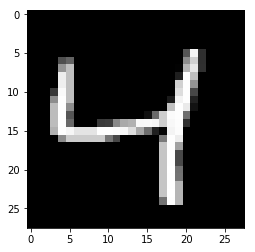

In [23]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [24]:
learning_rate = 0.001
# Input and target placeholders
img_size = mnist.train.images.shape[1]
inputs_ = tf.placeholder(tf.float32, (None,28,28,1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None,28,28,1),name='targets')

kernalsize = 3
poolsize = 2

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, kernalsize, padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1,poolsize,2)
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, kernalsize, padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2,poolsize,2)
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, kernalsize, padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3,poolsize,2)
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, kernalsize, padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(encoded, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, kernalsize, padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(encoded, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, kernalsize, padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6,1, kernalsize, padding='same')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels =targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [25]:
sess = tf.Session()

In [26]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6877
Epoch: 1/20... Training loss: 0.6820
Epoch: 1/20... Training loss: 0.6756
Epoch: 1/20... Training loss: 0.6682
Epoch: 1/20... Training loss: 0.6596
Epoch: 1/20... Training loss: 0.6493
Epoch: 1/20... Training loss: 0.6383
Epoch: 1/20... Training loss: 0.6234
Epoch: 1/20... Training loss: 0.6076
Epoch: 1/20... Training loss: 0.5888
Epoch: 1/20... Training loss: 0.5679
Epoch: 1/20... Training loss: 0.5457
Epoch: 1/20... Training loss: 0.5262
Epoch: 1/20... Training loss: 0.5088
Epoch: 1/20... Training loss: 0.4946
Epoch: 1/20... Training loss: 0.4892
Epoch: 1/20... Training loss: 0.5034
Epoch: 1/20... Training loss: 0.5042
Epoch: 1/20... Training loss: 0.5068
Epoch: 1/20... Training loss: 0.5172
Epoch: 1/20... Training loss: 0.5113
Epoch: 1/20... Training loss: 0.4952
Epoch: 1/20... Training loss: 0.4925
Epoch: 1/20... Training loss: 0.4804
Epoch: 1/20... Training loss: 0.4794
Epoch: 1/20... Training loss: 0.4670
Epoch: 1/20... Training loss: 0.4650
E

Epoch: 1/20... Training loss: 0.2213
Epoch: 1/20... Training loss: 0.2222
Epoch: 1/20... Training loss: 0.2230
Epoch: 1/20... Training loss: 0.2167
Epoch: 1/20... Training loss: 0.2268
Epoch: 1/20... Training loss: 0.2325
Epoch: 1/20... Training loss: 0.2245
Epoch: 1/20... Training loss: 0.2286
Epoch: 1/20... Training loss: 0.2212
Epoch: 1/20... Training loss: 0.2177
Epoch: 1/20... Training loss: 0.2259
Epoch: 1/20... Training loss: 0.2224
Epoch: 1/20... Training loss: 0.2370
Epoch: 1/20... Training loss: 0.2172
Epoch: 1/20... Training loss: 0.2275
Epoch: 1/20... Training loss: 0.2235
Epoch: 1/20... Training loss: 0.2240
Epoch: 1/20... Training loss: 0.2256
Epoch: 1/20... Training loss: 0.2264
Epoch: 1/20... Training loss: 0.2239
Epoch: 1/20... Training loss: 0.2273
Epoch: 1/20... Training loss: 0.2167
Epoch: 1/20... Training loss: 0.2270
Epoch: 1/20... Training loss: 0.2256
Epoch: 1/20... Training loss: 0.2186
Epoch: 1/20... Training loss: 0.2164
Epoch: 1/20... Training loss: 0.2164
E

Epoch: 2/20... Training loss: 0.2114
Epoch: 2/20... Training loss: 0.2139
Epoch: 2/20... Training loss: 0.2197
Epoch: 2/20... Training loss: 0.2093
Epoch: 2/20... Training loss: 0.2162
Epoch: 2/20... Training loss: 0.2158
Epoch: 2/20... Training loss: 0.2214
Epoch: 2/20... Training loss: 0.2113
Epoch: 2/20... Training loss: 0.2203
Epoch: 2/20... Training loss: 0.2053
Epoch: 2/20... Training loss: 0.2186
Epoch: 2/20... Training loss: 0.2137
Epoch: 2/20... Training loss: 0.2182
Epoch: 2/20... Training loss: 0.2106
Epoch: 2/20... Training loss: 0.2061
Epoch: 2/20... Training loss: 0.2159
Epoch: 2/20... Training loss: 0.2074
Epoch: 2/20... Training loss: 0.2076
Epoch: 2/20... Training loss: 0.2111
Epoch: 2/20... Training loss: 0.2160
Epoch: 2/20... Training loss: 0.2152
Epoch: 2/20... Training loss: 0.2248
Epoch: 2/20... Training loss: 0.2144
Epoch: 2/20... Training loss: 0.2196
Epoch: 2/20... Training loss: 0.2199
Epoch: 2/20... Training loss: 0.2143
Epoch: 2/20... Training loss: 0.2103
E

Epoch: 3/20... Training loss: 0.2092
Epoch: 3/20... Training loss: 0.2076
Epoch: 3/20... Training loss: 0.2142
Epoch: 3/20... Training loss: 0.2071
Epoch: 3/20... Training loss: 0.2145
Epoch: 3/20... Training loss: 0.2039
Epoch: 3/20... Training loss: 0.2088
Epoch: 3/20... Training loss: 0.2050
Epoch: 3/20... Training loss: 0.2105
Epoch: 3/20... Training loss: 0.2091
Epoch: 3/20... Training loss: 0.2156
Epoch: 3/20... Training loss: 0.2040
Epoch: 3/20... Training loss: 0.2110
Epoch: 3/20... Training loss: 0.2096
Epoch: 3/20... Training loss: 0.2036
Epoch: 3/20... Training loss: 0.2060
Epoch: 3/20... Training loss: 0.2138
Epoch: 3/20... Training loss: 0.2080
Epoch: 3/20... Training loss: 0.2099
Epoch: 3/20... Training loss: 0.2134
Epoch: 3/20... Training loss: 0.2145
Epoch: 3/20... Training loss: 0.2095
Epoch: 3/20... Training loss: 0.2125
Epoch: 3/20... Training loss: 0.2057
Epoch: 3/20... Training loss: 0.2101
Epoch: 3/20... Training loss: 0.2004
Epoch: 3/20... Training loss: 0.2071
E

Epoch: 3/20... Training loss: 0.2051
Epoch: 3/20... Training loss: 0.2080
Epoch: 3/20... Training loss: 0.2016
Epoch: 3/20... Training loss: 0.2017
Epoch: 3/20... Training loss: 0.2065
Epoch: 3/20... Training loss: 0.2045
Epoch: 3/20... Training loss: 0.2091
Epoch: 3/20... Training loss: 0.2059
Epoch: 3/20... Training loss: 0.2038
Epoch: 3/20... Training loss: 0.2141
Epoch: 4/20... Training loss: 0.2067
Epoch: 4/20... Training loss: 0.2012
Epoch: 4/20... Training loss: 0.2138
Epoch: 4/20... Training loss: 0.2067
Epoch: 4/20... Training loss: 0.2033
Epoch: 4/20... Training loss: 0.2023
Epoch: 4/20... Training loss: 0.2054
Epoch: 4/20... Training loss: 0.2041
Epoch: 4/20... Training loss: 0.2020
Epoch: 4/20... Training loss: 0.2080
Epoch: 4/20... Training loss: 0.2088
Epoch: 4/20... Training loss: 0.2064
Epoch: 4/20... Training loss: 0.2040
Epoch: 4/20... Training loss: 0.2038
Epoch: 4/20... Training loss: 0.2034
Epoch: 4/20... Training loss: 0.2129
Epoch: 4/20... Training loss: 0.2015
E

Epoch: 4/20... Training loss: 0.2044
Epoch: 4/20... Training loss: 0.2040
Epoch: 4/20... Training loss: 0.2048
Epoch: 4/20... Training loss: 0.2011
Epoch: 4/20... Training loss: 0.2066
Epoch: 4/20... Training loss: 0.2053
Epoch: 4/20... Training loss: 0.2042
Epoch: 4/20... Training loss: 0.2143
Epoch: 4/20... Training loss: 0.2042
Epoch: 4/20... Training loss: 0.2068
Epoch: 4/20... Training loss: 0.2001
Epoch: 4/20... Training loss: 0.1976
Epoch: 4/20... Training loss: 0.2005
Epoch: 4/20... Training loss: 0.2084
Epoch: 4/20... Training loss: 0.2093
Epoch: 4/20... Training loss: 0.2094
Epoch: 4/20... Training loss: 0.2051
Epoch: 4/20... Training loss: 0.2118
Epoch: 4/20... Training loss: 0.2036
Epoch: 4/20... Training loss: 0.2095
Epoch: 4/20... Training loss: 0.2026
Epoch: 4/20... Training loss: 0.2022
Epoch: 4/20... Training loss: 0.2139
Epoch: 4/20... Training loss: 0.2070
Epoch: 4/20... Training loss: 0.1998
Epoch: 4/20... Training loss: 0.2123
Epoch: 4/20... Training loss: 0.2085
E

Epoch: 5/20... Training loss: 0.2033
Epoch: 5/20... Training loss: 0.1963
Epoch: 5/20... Training loss: 0.1987
Epoch: 5/20... Training loss: 0.2082
Epoch: 5/20... Training loss: 0.2008
Epoch: 5/20... Training loss: 0.2060
Epoch: 5/20... Training loss: 0.2024
Epoch: 5/20... Training loss: 0.2052
Epoch: 5/20... Training loss: 0.2028
Epoch: 5/20... Training loss: 0.2047
Epoch: 5/20... Training loss: 0.2066
Epoch: 5/20... Training loss: 0.2048
Epoch: 5/20... Training loss: 0.2081
Epoch: 5/20... Training loss: 0.2017
Epoch: 5/20... Training loss: 0.2043
Epoch: 5/20... Training loss: 0.1969
Epoch: 5/20... Training loss: 0.2018
Epoch: 5/20... Training loss: 0.1999
Epoch: 5/20... Training loss: 0.2063
Epoch: 5/20... Training loss: 0.1960
Epoch: 5/20... Training loss: 0.2020
Epoch: 5/20... Training loss: 0.1984
Epoch: 5/20... Training loss: 0.1939
Epoch: 5/20... Training loss: 0.2003
Epoch: 5/20... Training loss: 0.2073
Epoch: 5/20... Training loss: 0.2085
Epoch: 5/20... Training loss: 0.1999
E

Epoch: 6/20... Training loss: 0.2027
Epoch: 6/20... Training loss: 0.2034
Epoch: 6/20... Training loss: 0.2070
Epoch: 6/20... Training loss: 0.1994
Epoch: 6/20... Training loss: 0.2077
Epoch: 6/20... Training loss: 0.2059
Epoch: 6/20... Training loss: 0.1969
Epoch: 6/20... Training loss: 0.1993
Epoch: 6/20... Training loss: 0.2014
Epoch: 6/20... Training loss: 0.2047
Epoch: 6/20... Training loss: 0.2000
Epoch: 6/20... Training loss: 0.1963
Epoch: 6/20... Training loss: 0.2077
Epoch: 6/20... Training loss: 0.2057
Epoch: 6/20... Training loss: 0.2026
Epoch: 6/20... Training loss: 0.2032
Epoch: 6/20... Training loss: 0.1956
Epoch: 6/20... Training loss: 0.2031
Epoch: 6/20... Training loss: 0.1948
Epoch: 6/20... Training loss: 0.2013
Epoch: 6/20... Training loss: 0.2044
Epoch: 6/20... Training loss: 0.1992
Epoch: 6/20... Training loss: 0.2013
Epoch: 6/20... Training loss: 0.2036
Epoch: 6/20... Training loss: 0.2024
Epoch: 6/20... Training loss: 0.2037
Epoch: 6/20... Training loss: 0.1944
E

Epoch: 6/20... Training loss: 0.1960
Epoch: 6/20... Training loss: 0.1986
Epoch: 6/20... Training loss: 0.2027
Epoch: 6/20... Training loss: 0.1988
Epoch: 6/20... Training loss: 0.1941
Epoch: 6/20... Training loss: 0.1974
Epoch: 6/20... Training loss: 0.1944
Epoch: 6/20... Training loss: 0.2000
Epoch: 6/20... Training loss: 0.1969
Epoch: 6/20... Training loss: 0.2036
Epoch: 6/20... Training loss: 0.2060
Epoch: 6/20... Training loss: 0.1973
Epoch: 6/20... Training loss: 0.2063
Epoch: 6/20... Training loss: 0.2029
Epoch: 6/20... Training loss: 0.1927
Epoch: 6/20... Training loss: 0.1962
Epoch: 6/20... Training loss: 0.1979
Epoch: 6/20... Training loss: 0.2018
Epoch: 6/20... Training loss: 0.2049
Epoch: 6/20... Training loss: 0.2000
Epoch: 7/20... Training loss: 0.2066
Epoch: 7/20... Training loss: 0.2043
Epoch: 7/20... Training loss: 0.1998
Epoch: 7/20... Training loss: 0.1977
Epoch: 7/20... Training loss: 0.2053
Epoch: 7/20... Training loss: 0.1985
Epoch: 7/20... Training loss: 0.1970
E

Epoch: 7/20... Training loss: 0.1973
Epoch: 7/20... Training loss: 0.1938
Epoch: 7/20... Training loss: 0.1926
Epoch: 7/20... Training loss: 0.1997
Epoch: 7/20... Training loss: 0.1956
Epoch: 7/20... Training loss: 0.2015
Epoch: 7/20... Training loss: 0.1961
Epoch: 7/20... Training loss: 0.1996
Epoch: 7/20... Training loss: 0.2011
Epoch: 7/20... Training loss: 0.1959
Epoch: 7/20... Training loss: 0.1938
Epoch: 7/20... Training loss: 0.1968
Epoch: 7/20... Training loss: 0.2015
Epoch: 7/20... Training loss: 0.1990
Epoch: 7/20... Training loss: 0.1922
Epoch: 7/20... Training loss: 0.1990
Epoch: 7/20... Training loss: 0.1943
Epoch: 7/20... Training loss: 0.1995
Epoch: 7/20... Training loss: 0.1997
Epoch: 7/20... Training loss: 0.1990
Epoch: 7/20... Training loss: 0.2043
Epoch: 7/20... Training loss: 0.1972
Epoch: 7/20... Training loss: 0.1941
Epoch: 7/20... Training loss: 0.1991
Epoch: 7/20... Training loss: 0.1963
Epoch: 7/20... Training loss: 0.2008
Epoch: 7/20... Training loss: 0.2021
E

Epoch: 8/20... Training loss: 0.1992
Epoch: 8/20... Training loss: 0.1967
Epoch: 8/20... Training loss: 0.1981
Epoch: 8/20... Training loss: 0.2003
Epoch: 8/20... Training loss: 0.2053
Epoch: 8/20... Training loss: 0.1846
Epoch: 8/20... Training loss: 0.1929
Epoch: 8/20... Training loss: 0.1961
Epoch: 8/20... Training loss: 0.1885
Epoch: 8/20... Training loss: 0.1980
Epoch: 8/20... Training loss: 0.2009
Epoch: 8/20... Training loss: 0.1935
Epoch: 8/20... Training loss: 0.1979
Epoch: 8/20... Training loss: 0.1922
Epoch: 8/20... Training loss: 0.1991
Epoch: 8/20... Training loss: 0.1957
Epoch: 8/20... Training loss: 0.1968
Epoch: 8/20... Training loss: 0.1965
Epoch: 8/20... Training loss: 0.1958
Epoch: 8/20... Training loss: 0.2034
Epoch: 8/20... Training loss: 0.1961
Epoch: 8/20... Training loss: 0.1943
Epoch: 8/20... Training loss: 0.1974
Epoch: 8/20... Training loss: 0.2038
Epoch: 8/20... Training loss: 0.1976
Epoch: 8/20... Training loss: 0.1983
Epoch: 8/20... Training loss: 0.1984
E

Epoch: 9/20... Training loss: 0.2008
Epoch: 9/20... Training loss: 0.1977
Epoch: 9/20... Training loss: 0.2011
Epoch: 9/20... Training loss: 0.1957
Epoch: 9/20... Training loss: 0.1916
Epoch: 9/20... Training loss: 0.2022
Epoch: 9/20... Training loss: 0.2004
Epoch: 9/20... Training loss: 0.1959
Epoch: 9/20... Training loss: 0.1946
Epoch: 9/20... Training loss: 0.1875
Epoch: 9/20... Training loss: 0.1980
Epoch: 9/20... Training loss: 0.1967
Epoch: 9/20... Training loss: 0.1961
Epoch: 9/20... Training loss: 0.1974
Epoch: 9/20... Training loss: 0.1952
Epoch: 9/20... Training loss: 0.1962
Epoch: 9/20... Training loss: 0.1973
Epoch: 9/20... Training loss: 0.2000
Epoch: 9/20... Training loss: 0.1993
Epoch: 9/20... Training loss: 0.1964
Epoch: 9/20... Training loss: 0.1977
Epoch: 9/20... Training loss: 0.1969
Epoch: 9/20... Training loss: 0.1985
Epoch: 9/20... Training loss: 0.2014
Epoch: 9/20... Training loss: 0.2014
Epoch: 9/20... Training loss: 0.2069
Epoch: 9/20... Training loss: 0.1984
E

Epoch: 9/20... Training loss: 0.1915
Epoch: 9/20... Training loss: 0.1998
Epoch: 9/20... Training loss: 0.2018
Epoch: 9/20... Training loss: 0.1931
Epoch: 9/20... Training loss: 0.1859
Epoch: 9/20... Training loss: 0.2026
Epoch: 9/20... Training loss: 0.1967
Epoch: 9/20... Training loss: 0.1955
Epoch: 9/20... Training loss: 0.1932
Epoch: 9/20... Training loss: 0.1949
Epoch: 9/20... Training loss: 0.2011
Epoch: 9/20... Training loss: 0.1912
Epoch: 9/20... Training loss: 0.1995
Epoch: 9/20... Training loss: 0.1880
Epoch: 9/20... Training loss: 0.1908
Epoch: 9/20... Training loss: 0.1858
Epoch: 9/20... Training loss: 0.1983
Epoch: 9/20... Training loss: 0.1992
Epoch: 9/20... Training loss: 0.1948
Epoch: 9/20... Training loss: 0.1926
Epoch: 9/20... Training loss: 0.1974
Epoch: 9/20... Training loss: 0.2027
Epoch: 9/20... Training loss: 0.2002
Epoch: 9/20... Training loss: 0.2019
Epoch: 9/20... Training loss: 0.1927
Epoch: 9/20... Training loss: 0.1959
Epoch: 9/20... Training loss: 0.2007
E

Epoch: 10/20... Training loss: 0.1969
Epoch: 10/20... Training loss: 0.1939
Epoch: 10/20... Training loss: 0.2014
Epoch: 10/20... Training loss: 0.1930
Epoch: 10/20... Training loss: 0.1912
Epoch: 10/20... Training loss: 0.1972
Epoch: 10/20... Training loss: 0.1978
Epoch: 10/20... Training loss: 0.1951
Epoch: 10/20... Training loss: 0.1896
Epoch: 10/20... Training loss: 0.1938
Epoch: 10/20... Training loss: 0.1901
Epoch: 10/20... Training loss: 0.1968
Epoch: 10/20... Training loss: 0.1976
Epoch: 10/20... Training loss: 0.1982
Epoch: 10/20... Training loss: 0.1922
Epoch: 10/20... Training loss: 0.1958
Epoch: 10/20... Training loss: 0.1918
Epoch: 10/20... Training loss: 0.1964
Epoch: 10/20... Training loss: 0.1949
Epoch: 10/20... Training loss: 0.1937
Epoch: 10/20... Training loss: 0.2011
Epoch: 10/20... Training loss: 0.1984
Epoch: 10/20... Training loss: 0.2000
Epoch: 10/20... Training loss: 0.1961
Epoch: 10/20... Training loss: 0.1967
Epoch: 10/20... Training loss: 0.2005
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1931
Epoch: 11/20... Training loss: 0.1951
Epoch: 11/20... Training loss: 0.1928
Epoch: 11/20... Training loss: 0.1902
Epoch: 11/20... Training loss: 0.1968
Epoch: 11/20... Training loss: 0.1954
Epoch: 11/20... Training loss: 0.1988
Epoch: 11/20... Training loss: 0.1931
Epoch: 11/20... Training loss: 0.1887
Epoch: 11/20... Training loss: 0.1940
Epoch: 11/20... Training loss: 0.1941
Epoch: 11/20... Training loss: 0.1928
Epoch: 11/20... Training loss: 0.1890
Epoch: 11/20... Training loss: 0.1989
Epoch: 11/20... Training loss: 0.1992
Epoch: 11/20... Training loss: 0.1903
Epoch: 11/20... Training loss: 0.1905
Epoch: 11/20... Training loss: 0.1913
Epoch: 11/20... Training loss: 0.2019
Epoch: 11/20... Training loss: 0.1956
Epoch: 11/20... Training loss: 0.1917
Epoch: 11/20... Training loss: 0.1981
Epoch: 11/20... Training loss: 0.1911
Epoch: 11/20... Training loss: 0.2031
Epoch: 11/20... Training loss: 0.1964
Epoch: 11/20... Training loss: 0.2004
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1925
Epoch: 12/20... Training loss: 0.1953
Epoch: 12/20... Training loss: 0.1886
Epoch: 12/20... Training loss: 0.1929
Epoch: 12/20... Training loss: 0.2032
Epoch: 12/20... Training loss: 0.1951
Epoch: 12/20... Training loss: 0.1960
Epoch: 12/20... Training loss: 0.1927
Epoch: 12/20... Training loss: 0.1856
Epoch: 12/20... Training loss: 0.1948
Epoch: 12/20... Training loss: 0.1936
Epoch: 12/20... Training loss: 0.1869
Epoch: 12/20... Training loss: 0.1901
Epoch: 12/20... Training loss: 0.1934
Epoch: 12/20... Training loss: 0.2001
Epoch: 12/20... Training loss: 0.1957
Epoch: 12/20... Training loss: 0.1957
Epoch: 12/20... Training loss: 0.1948
Epoch: 12/20... Training loss: 0.1959
Epoch: 12/20... Training loss: 0.1988
Epoch: 12/20... Training loss: 0.1903
Epoch: 12/20... Training loss: 0.1888
Epoch: 12/20... Training loss: 0.1982
Epoch: 12/20... Training loss: 0.1981
Epoch: 12/20... Training loss: 0.1983
Epoch: 12/20... Training loss: 0.1961
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1937
Epoch: 12/20... Training loss: 0.1934
Epoch: 12/20... Training loss: 0.2004
Epoch: 12/20... Training loss: 0.1987
Epoch: 12/20... Training loss: 0.1961
Epoch: 12/20... Training loss: 0.1945
Epoch: 12/20... Training loss: 0.1999
Epoch: 12/20... Training loss: 0.1895
Epoch: 12/20... Training loss: 0.1924
Epoch: 12/20... Training loss: 0.1968
Epoch: 12/20... Training loss: 0.1985
Epoch: 12/20... Training loss: 0.1905
Epoch: 12/20... Training loss: 0.1882
Epoch: 12/20... Training loss: 0.1911
Epoch: 12/20... Training loss: 0.1975
Epoch: 12/20... Training loss: 0.1888
Epoch: 12/20... Training loss: 0.1894
Epoch: 12/20... Training loss: 0.1943
Epoch: 12/20... Training loss: 0.1971
Epoch: 12/20... Training loss: 0.1980
Epoch: 12/20... Training loss: 0.1890
Epoch: 12/20... Training loss: 0.1934
Epoch: 12/20... Training loss: 0.1887
Epoch: 12/20... Training loss: 0.1964
Epoch: 12/20... Training loss: 0.1901
Epoch: 12/20... Training loss: 0.1928
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1912
Epoch: 13/20... Training loss: 0.1935
Epoch: 13/20... Training loss: 0.1950
Epoch: 13/20... Training loss: 0.1900
Epoch: 13/20... Training loss: 0.1953
Epoch: 13/20... Training loss: 0.1921
Epoch: 13/20... Training loss: 0.1989
Epoch: 13/20... Training loss: 0.1884
Epoch: 13/20... Training loss: 0.1844
Epoch: 13/20... Training loss: 0.1997
Epoch: 13/20... Training loss: 0.1937
Epoch: 13/20... Training loss: 0.1856
Epoch: 13/20... Training loss: 0.1994
Epoch: 13/20... Training loss: 0.1876
Epoch: 13/20... Training loss: 0.1897
Epoch: 13/20... Training loss: 0.1897
Epoch: 13/20... Training loss: 0.1859
Epoch: 13/20... Training loss: 0.1923
Epoch: 13/20... Training loss: 0.2010
Epoch: 13/20... Training loss: 0.1941
Epoch: 13/20... Training loss: 0.1969
Epoch: 13/20... Training loss: 0.1978
Epoch: 13/20... Training loss: 0.1978
Epoch: 13/20... Training loss: 0.1968
Epoch: 13/20... Training loss: 0.1967
Epoch: 13/20... Training loss: 0.1925
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1953
Epoch: 14/20... Training loss: 0.1905
Epoch: 14/20... Training loss: 0.1922
Epoch: 14/20... Training loss: 0.1838
Epoch: 14/20... Training loss: 0.2015
Epoch: 14/20... Training loss: 0.1838
Epoch: 14/20... Training loss: 0.1872
Epoch: 14/20... Training loss: 0.1964
Epoch: 14/20... Training loss: 0.1908
Epoch: 14/20... Training loss: 0.1976
Epoch: 14/20... Training loss: 0.1880
Epoch: 14/20... Training loss: 0.1928
Epoch: 14/20... Training loss: 0.1881
Epoch: 14/20... Training loss: 0.1981
Epoch: 14/20... Training loss: 0.1972
Epoch: 14/20... Training loss: 0.1893
Epoch: 14/20... Training loss: 0.1916
Epoch: 14/20... Training loss: 0.1969
Epoch: 14/20... Training loss: 0.1924
Epoch: 14/20... Training loss: 0.1899
Epoch: 14/20... Training loss: 0.1867
Epoch: 14/20... Training loss: 0.1887
Epoch: 14/20... Training loss: 0.1922
Epoch: 14/20... Training loss: 0.1974
Epoch: 14/20... Training loss: 0.1895
Epoch: 14/20... Training loss: 0.1925
Epoch: 14/20

Epoch: 14/20... Training loss: 0.1918
Epoch: 14/20... Training loss: 0.1977
Epoch: 14/20... Training loss: 0.1988
Epoch: 14/20... Training loss: 0.1829
Epoch: 14/20... Training loss: 0.1932
Epoch: 14/20... Training loss: 0.1916
Epoch: 14/20... Training loss: 0.1926
Epoch: 14/20... Training loss: 0.1948
Epoch: 14/20... Training loss: 0.1960
Epoch: 14/20... Training loss: 0.1974
Epoch: 14/20... Training loss: 0.1974
Epoch: 14/20... Training loss: 0.1899
Epoch: 14/20... Training loss: 0.1909
Epoch: 14/20... Training loss: 0.1907
Epoch: 15/20... Training loss: 0.1953
Epoch: 15/20... Training loss: 0.1941
Epoch: 15/20... Training loss: 0.1869
Epoch: 15/20... Training loss: 0.1930
Epoch: 15/20... Training loss: 0.1912
Epoch: 15/20... Training loss: 0.1902
Epoch: 15/20... Training loss: 0.1974
Epoch: 15/20... Training loss: 0.1903
Epoch: 15/20... Training loss: 0.1930
Epoch: 15/20... Training loss: 0.1885
Epoch: 15/20... Training loss: 0.1956
Epoch: 15/20... Training loss: 0.1920
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1975
Epoch: 15/20... Training loss: 0.1908
Epoch: 15/20... Training loss: 0.1965
Epoch: 15/20... Training loss: 0.1908
Epoch: 15/20... Training loss: 0.1943
Epoch: 15/20... Training loss: 0.1902
Epoch: 15/20... Training loss: 0.1865
Epoch: 15/20... Training loss: 0.1918
Epoch: 15/20... Training loss: 0.1872
Epoch: 15/20... Training loss: 0.1966
Epoch: 15/20... Training loss: 0.2027
Epoch: 15/20... Training loss: 0.1968
Epoch: 15/20... Training loss: 0.1916
Epoch: 15/20... Training loss: 0.1993
Epoch: 15/20... Training loss: 0.1975
Epoch: 15/20... Training loss: 0.1953
Epoch: 15/20... Training loss: 0.1882
Epoch: 15/20... Training loss: 0.1939
Epoch: 15/20... Training loss: 0.2009
Epoch: 15/20... Training loss: 0.1881
Epoch: 15/20... Training loss: 0.1874
Epoch: 15/20... Training loss: 0.1893
Epoch: 15/20... Training loss: 0.1890
Epoch: 15/20... Training loss: 0.1955
Epoch: 15/20... Training loss: 0.1945
Epoch: 15/20... Training loss: 0.1916
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1889
Epoch: 16/20... Training loss: 0.1882
Epoch: 16/20... Training loss: 0.1887
Epoch: 16/20... Training loss: 0.1882
Epoch: 16/20... Training loss: 0.1949
Epoch: 16/20... Training loss: 0.1935
Epoch: 16/20... Training loss: 0.1900
Epoch: 16/20... Training loss: 0.1893
Epoch: 16/20... Training loss: 0.1981
Epoch: 16/20... Training loss: 0.1910
Epoch: 16/20... Training loss: 0.1899
Epoch: 16/20... Training loss: 0.1923
Epoch: 16/20... Training loss: 0.1967
Epoch: 16/20... Training loss: 0.1889
Epoch: 16/20... Training loss: 0.1896
Epoch: 16/20... Training loss: 0.1921
Epoch: 16/20... Training loss: 0.1917
Epoch: 16/20... Training loss: 0.1983
Epoch: 16/20... Training loss: 0.1870
Epoch: 16/20... Training loss: 0.1995
Epoch: 16/20... Training loss: 0.1805
Epoch: 16/20... Training loss: 0.1876
Epoch: 16/20... Training loss: 0.1954
Epoch: 16/20... Training loss: 0.1887
Epoch: 16/20... Training loss: 0.1900
Epoch: 16/20... Training loss: 0.1956
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1903
Epoch: 17/20... Training loss: 0.1904
Epoch: 17/20... Training loss: 0.1851
Epoch: 17/20... Training loss: 0.1948
Epoch: 17/20... Training loss: 0.1953
Epoch: 17/20... Training loss: 0.1957
Epoch: 17/20... Training loss: 0.1853
Epoch: 17/20... Training loss: 0.1872
Epoch: 17/20... Training loss: 0.1831
Epoch: 17/20... Training loss: 0.1958
Epoch: 17/20... Training loss: 0.1916
Epoch: 17/20... Training loss: 0.1903
Epoch: 17/20... Training loss: 0.1957
Epoch: 17/20... Training loss: 0.1945
Epoch: 17/20... Training loss: 0.1962
Epoch: 17/20... Training loss: 0.1929
Epoch: 17/20... Training loss: 0.1854
Epoch: 17/20... Training loss: 0.1875
Epoch: 17/20... Training loss: 0.1854
Epoch: 17/20... Training loss: 0.1962
Epoch: 17/20... Training loss: 0.1951
Epoch: 17/20... Training loss: 0.1893
Epoch: 17/20... Training loss: 0.1856
Epoch: 17/20... Training loss: 0.1837
Epoch: 17/20... Training loss: 0.1864
Epoch: 17/20... Training loss: 0.1881
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1952
Epoch: 17/20... Training loss: 0.1911
Epoch: 17/20... Training loss: 0.1900
Epoch: 17/20... Training loss: 0.1945
Epoch: 17/20... Training loss: 0.1858
Epoch: 17/20... Training loss: 0.1882
Epoch: 17/20... Training loss: 0.1898
Epoch: 17/20... Training loss: 0.1927
Epoch: 17/20... Training loss: 0.1939
Epoch: 17/20... Training loss: 0.1946
Epoch: 17/20... Training loss: 0.1868
Epoch: 17/20... Training loss: 0.1879
Epoch: 17/20... Training loss: 0.1879
Epoch: 17/20... Training loss: 0.1845
Epoch: 17/20... Training loss: 0.1936
Epoch: 17/20... Training loss: 0.1948
Epoch: 17/20... Training loss: 0.1880
Epoch: 17/20... Training loss: 0.1908
Epoch: 17/20... Training loss: 0.1896
Epoch: 17/20... Training loss: 0.1871
Epoch: 17/20... Training loss: 0.1955
Epoch: 17/20... Training loss: 0.1912
Epoch: 17/20... Training loss: 0.1944
Epoch: 17/20... Training loss: 0.1863
Epoch: 17/20... Training loss: 0.1859
Epoch: 17/20... Training loss: 0.1894
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1913
Epoch: 18/20... Training loss: 0.1854
Epoch: 18/20... Training loss: 0.1868
Epoch: 18/20... Training loss: 0.1860
Epoch: 18/20... Training loss: 0.1897
Epoch: 18/20... Training loss: 0.1928
Epoch: 18/20... Training loss: 0.1949
Epoch: 18/20... Training loss: 0.1814
Epoch: 18/20... Training loss: 0.1909
Epoch: 18/20... Training loss: 0.1939
Epoch: 18/20... Training loss: 0.1901
Epoch: 18/20... Training loss: 0.1960
Epoch: 18/20... Training loss: 0.1929
Epoch: 18/20... Training loss: 0.1913
Epoch: 18/20... Training loss: 0.1954
Epoch: 18/20... Training loss: 0.1905
Epoch: 18/20... Training loss: 0.1859
Epoch: 18/20... Training loss: 0.1923
Epoch: 18/20... Training loss: 0.1959
Epoch: 18/20... Training loss: 0.1955
Epoch: 18/20... Training loss: 0.1907
Epoch: 18/20... Training loss: 0.1942
Epoch: 18/20... Training loss: 0.1927
Epoch: 18/20... Training loss: 0.1903
Epoch: 18/20... Training loss: 0.1887
Epoch: 18/20... Training loss: 0.1884
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1978
Epoch: 19/20... Training loss: 0.1928
Epoch: 19/20... Training loss: 0.1948
Epoch: 19/20... Training loss: 0.1820
Epoch: 19/20... Training loss: 0.1882
Epoch: 19/20... Training loss: 0.1928
Epoch: 19/20... Training loss: 0.1874
Epoch: 19/20... Training loss: 0.1878
Epoch: 19/20... Training loss: 0.1857
Epoch: 19/20... Training loss: 0.1861
Epoch: 19/20... Training loss: 0.1926
Epoch: 19/20... Training loss: 0.1919
Epoch: 19/20... Training loss: 0.1917
Epoch: 19/20... Training loss: 0.1940
Epoch: 19/20... Training loss: 0.1872
Epoch: 19/20... Training loss: 0.1841
Epoch: 19/20... Training loss: 0.1998
Epoch: 19/20... Training loss: 0.1931
Epoch: 19/20... Training loss: 0.1868
Epoch: 19/20... Training loss: 0.1995
Epoch: 19/20... Training loss: 0.1937
Epoch: 19/20... Training loss: 0.1865
Epoch: 19/20... Training loss: 0.1922
Epoch: 19/20... Training loss: 0.1931
Epoch: 19/20... Training loss: 0.1945
Epoch: 19/20... Training loss: 0.1870
Epoch: 19/20

Epoch: 20/20... Training loss: 0.1902
Epoch: 20/20... Training loss: 0.1922
Epoch: 20/20... Training loss: 0.1906
Epoch: 20/20... Training loss: 0.1918
Epoch: 20/20... Training loss: 0.1887
Epoch: 20/20... Training loss: 0.1934
Epoch: 20/20... Training loss: 0.1855
Epoch: 20/20... Training loss: 0.1909
Epoch: 20/20... Training loss: 0.1937
Epoch: 20/20... Training loss: 0.1875
Epoch: 20/20... Training loss: 0.1822
Epoch: 20/20... Training loss: 0.1882
Epoch: 20/20... Training loss: 0.1811
Epoch: 20/20... Training loss: 0.1894
Epoch: 20/20... Training loss: 0.1937
Epoch: 20/20... Training loss: 0.1891
Epoch: 20/20... Training loss: 0.1900
Epoch: 20/20... Training loss: 0.1890
Epoch: 20/20... Training loss: 0.1895
Epoch: 20/20... Training loss: 0.1899
Epoch: 20/20... Training loss: 0.1877
Epoch: 20/20... Training loss: 0.1826
Epoch: 20/20... Training loss: 0.1858
Epoch: 20/20... Training loss: 0.1899
Epoch: 20/20... Training loss: 0.1911
Epoch: 20/20... Training loss: 0.1873
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1898
Epoch: 20/20... Training loss: 0.1890
Epoch: 20/20... Training loss: 0.1933
Epoch: 20/20... Training loss: 0.1877
Epoch: 20/20... Training loss: 0.1939
Epoch: 20/20... Training loss: 0.1878
Epoch: 20/20... Training loss: 0.1915
Epoch: 20/20... Training loss: 0.1965
Epoch: 20/20... Training loss: 0.1853
Epoch: 20/20... Training loss: 0.1942
Epoch: 20/20... Training loss: 0.1875
Epoch: 20/20... Training loss: 0.1934
Epoch: 20/20... Training loss: 0.1949
Epoch: 20/20... Training loss: 0.1913
Epoch: 20/20... Training loss: 0.1854
Epoch: 20/20... Training loss: 0.1851
Epoch: 20/20... Training loss: 0.1829
Epoch: 20/20... Training loss: 0.1903
Epoch: 20/20... Training loss: 0.1916
Epoch: 20/20... Training loss: 0.1847
Epoch: 20/20... Training loss: 0.1894
Epoch: 20/20... Training loss: 0.1895
Epoch: 20/20... Training loss: 0.1930
Epoch: 20/20... Training loss: 0.1967
Epoch: 20/20... Training loss: 0.1906
Epoch: 20/20... Training loss: 0.1946
Epoch: 20/20

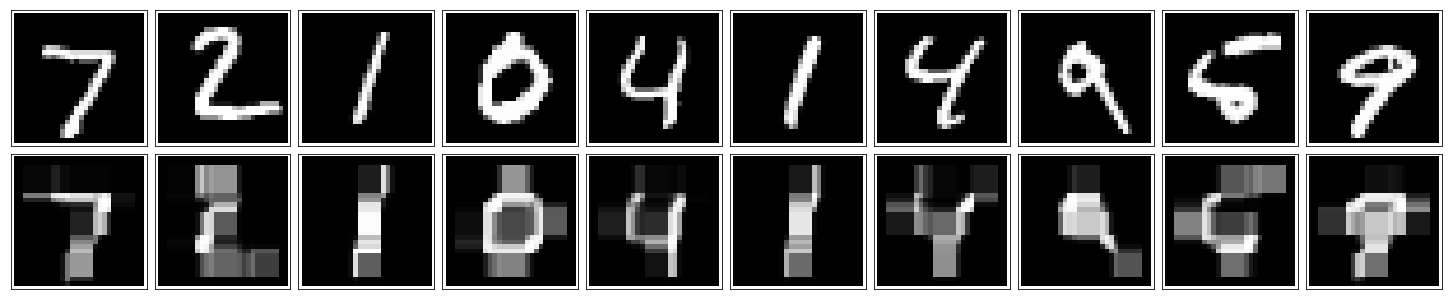

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [28]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [30]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')


kernalsize = 3
poolsize = 2

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, kernalsize, padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1,poolsize,2)
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, kernalsize, padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2,poolsize,2)
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, kernalsize, padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3,poolsize,2)
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, kernalsize, padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, kernalsize, padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, kernalsize, padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, kernalsize, padding='same')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels =targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [31]:
sess = tf.Session()

In [32]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6975
Epoch: 1/100... Training loss: 0.6895
Epoch: 1/100... Training loss: 0.6819
Epoch: 1/100... Training loss: 0.6704
Epoch: 1/100... Training loss: 0.6525
Epoch: 1/100... Training loss: 0.6255
Epoch: 1/100... Training loss: 0.5879
Epoch: 1/100... Training loss: 0.5419
Epoch: 1/100... Training loss: 0.4975
Epoch: 1/100... Training loss: 0.4844
Epoch: 1/100... Training loss: 0.5104
Epoch: 1/100... Training loss: 0.5297
Epoch: 1/100... Training loss: 0.5218
Epoch: 1/100... Training loss: 0.4731
Epoch: 1/100... Training loss: 0.4701
Epoch: 1/100... Training loss: 0.4671
Epoch: 1/100... Training loss: 0.4592
Epoch: 1/100... Training loss: 0.4641
Epoch: 1/100... Training loss: 0.4547
Epoch: 1/100... Training loss: 0.4348
Epoch: 1/100... Training loss: 0.4275
Epoch: 1/100... Training loss: 0.4108
Epoch: 1/100... Training loss: 0.4097
Epoch: 1/100... Training loss: 0.4042
Epoch: 1/100... Training loss: 0.3788
Epoch: 1/100... Training loss: 0.3813
Epoch: 1/100

Epoch: 1/100... Training loss: 0.1836
Epoch: 1/100... Training loss: 0.1856
Epoch: 1/100... Training loss: 0.1789
Epoch: 1/100... Training loss: 0.1806
Epoch: 1/100... Training loss: 0.1834
Epoch: 1/100... Training loss: 0.1836
Epoch: 1/100... Training loss: 0.1820
Epoch: 1/100... Training loss: 0.1857
Epoch: 1/100... Training loss: 0.1855
Epoch: 1/100... Training loss: 0.1809
Epoch: 1/100... Training loss: 0.1850
Epoch: 1/100... Training loss: 0.1838
Epoch: 1/100... Training loss: 0.1770
Epoch: 1/100... Training loss: 0.1795
Epoch: 1/100... Training loss: 0.1826
Epoch: 1/100... Training loss: 0.1851
Epoch: 1/100... Training loss: 0.1793
Epoch: 1/100... Training loss: 0.1773
Epoch: 1/100... Training loss: 0.1883
Epoch: 1/100... Training loss: 0.1831
Epoch: 1/100... Training loss: 0.1788
Epoch: 1/100... Training loss: 0.1794
Epoch: 1/100... Training loss: 0.1806
Epoch: 1/100... Training loss: 0.1812
Epoch: 1/100... Training loss: 0.1782
Epoch: 1/100... Training loss: 0.1771
Epoch: 1/100

Epoch: 2/100... Training loss: 0.1576
Epoch: 2/100... Training loss: 0.1609
Epoch: 2/100... Training loss: 0.1601
Epoch: 2/100... Training loss: 0.1552
Epoch: 2/100... Training loss: 0.1539
Epoch: 2/100... Training loss: 0.1522
Epoch: 2/100... Training loss: 0.1553
Epoch: 2/100... Training loss: 0.1597
Epoch: 2/100... Training loss: 0.1502
Epoch: 2/100... Training loss: 0.1529
Epoch: 2/100... Training loss: 0.1536
Epoch: 2/100... Training loss: 0.1589
Epoch: 2/100... Training loss: 0.1487
Epoch: 2/100... Training loss: 0.1611
Epoch: 2/100... Training loss: 0.1583
Epoch: 2/100... Training loss: 0.1558
Epoch: 2/100... Training loss: 0.1572
Epoch: 2/100... Training loss: 0.1577
Epoch: 2/100... Training loss: 0.1534
Epoch: 2/100... Training loss: 0.1531
Epoch: 2/100... Training loss: 0.1564
Epoch: 2/100... Training loss: 0.1606
Epoch: 2/100... Training loss: 0.1534
Epoch: 2/100... Training loss: 0.1573
Epoch: 2/100... Training loss: 0.1539
Epoch: 2/100... Training loss: 0.1525
Epoch: 2/100

Epoch: 3/100... Training loss: 0.1388
Epoch: 3/100... Training loss: 0.1466
Epoch: 3/100... Training loss: 0.1418
Epoch: 3/100... Training loss: 0.1443
Epoch: 3/100... Training loss: 0.1428
Epoch: 3/100... Training loss: 0.1405
Epoch: 3/100... Training loss: 0.1400
Epoch: 3/100... Training loss: 0.1427
Epoch: 3/100... Training loss: 0.1435
Epoch: 3/100... Training loss: 0.1438
Epoch: 3/100... Training loss: 0.1465
Epoch: 3/100... Training loss: 0.1429
Epoch: 3/100... Training loss: 0.1400
Epoch: 3/100... Training loss: 0.1441
Epoch: 3/100... Training loss: 0.1449
Epoch: 3/100... Training loss: 0.1447
Epoch: 3/100... Training loss: 0.1399
Epoch: 3/100... Training loss: 0.1491
Epoch: 3/100... Training loss: 0.1429
Epoch: 3/100... Training loss: 0.1476
Epoch: 3/100... Training loss: 0.1403
Epoch: 3/100... Training loss: 0.1411
Epoch: 3/100... Training loss: 0.1436
Epoch: 3/100... Training loss: 0.1463
Epoch: 3/100... Training loss: 0.1446
Epoch: 3/100... Training loss: 0.1440
Epoch: 3/100

Epoch: 3/100... Training loss: 0.1362
Epoch: 3/100... Training loss: 0.1366
Epoch: 3/100... Training loss: 0.1391
Epoch: 3/100... Training loss: 0.1295
Epoch: 3/100... Training loss: 0.1361
Epoch: 3/100... Training loss: 0.1358
Epoch: 3/100... Training loss: 0.1376
Epoch: 3/100... Training loss: 0.1328
Epoch: 3/100... Training loss: 0.1366
Epoch: 3/100... Training loss: 0.1402
Epoch: 3/100... Training loss: 0.1392
Epoch: 3/100... Training loss: 0.1380
Epoch: 3/100... Training loss: 0.1347
Epoch: 3/100... Training loss: 0.1349
Epoch: 3/100... Training loss: 0.1336
Epoch: 3/100... Training loss: 0.1352
Epoch: 3/100... Training loss: 0.1358
Epoch: 3/100... Training loss: 0.1321
Epoch: 3/100... Training loss: 0.1375
Epoch: 3/100... Training loss: 0.1359
Epoch: 3/100... Training loss: 0.1394
Epoch: 3/100... Training loss: 0.1318
Epoch: 3/100... Training loss: 0.1333
Epoch: 3/100... Training loss: 0.1400
Epoch: 3/100... Training loss: 0.1344
Epoch: 3/100... Training loss: 0.1366
Epoch: 3/100

Epoch: 4/100... Training loss: 0.1285
Epoch: 4/100... Training loss: 0.1276
Epoch: 4/100... Training loss: 0.1300
Epoch: 4/100... Training loss: 0.1291
Epoch: 4/100... Training loss: 0.1345
Epoch: 4/100... Training loss: 0.1320
Epoch: 4/100... Training loss: 0.1314
Epoch: 4/100... Training loss: 0.1340
Epoch: 4/100... Training loss: 0.1323
Epoch: 4/100... Training loss: 0.1302
Epoch: 4/100... Training loss: 0.1302
Epoch: 4/100... Training loss: 0.1294
Epoch: 4/100... Training loss: 0.1354
Epoch: 4/100... Training loss: 0.1325
Epoch: 4/100... Training loss: 0.1314
Epoch: 4/100... Training loss: 0.1306
Epoch: 4/100... Training loss: 0.1327
Epoch: 4/100... Training loss: 0.1344
Epoch: 4/100... Training loss: 0.1316
Epoch: 4/100... Training loss: 0.1304
Epoch: 4/100... Training loss: 0.1285
Epoch: 4/100... Training loss: 0.1304
Epoch: 4/100... Training loss: 0.1329
Epoch: 4/100... Training loss: 0.1297
Epoch: 4/100... Training loss: 0.1301
Epoch: 4/100... Training loss: 0.1322
Epoch: 4/100

Epoch: 5/100... Training loss: 0.1262
Epoch: 5/100... Training loss: 0.1293
Epoch: 5/100... Training loss: 0.1264
Epoch: 5/100... Training loss: 0.1254
Epoch: 5/100... Training loss: 0.1303
Epoch: 5/100... Training loss: 0.1280
Epoch: 5/100... Training loss: 0.1292
Epoch: 5/100... Training loss: 0.1313
Epoch: 5/100... Training loss: 0.1271
Epoch: 5/100... Training loss: 0.1313
Epoch: 5/100... Training loss: 0.1280
Epoch: 5/100... Training loss: 0.1282
Epoch: 5/100... Training loss: 0.1307
Epoch: 5/100... Training loss: 0.1283
Epoch: 5/100... Training loss: 0.1274
Epoch: 5/100... Training loss: 0.1281
Epoch: 5/100... Training loss: 0.1298
Epoch: 5/100... Training loss: 0.1235
Epoch: 5/100... Training loss: 0.1282
Epoch: 5/100... Training loss: 0.1284
Epoch: 5/100... Training loss: 0.1268
Epoch: 5/100... Training loss: 0.1296
Epoch: 5/100... Training loss: 0.1289
Epoch: 5/100... Training loss: 0.1289
Epoch: 5/100... Training loss: 0.1299
Epoch: 5/100... Training loss: 0.1253
Epoch: 5/100

Epoch: 6/100... Training loss: 0.1303
Epoch: 6/100... Training loss: 0.1234
Epoch: 6/100... Training loss: 0.1238
Epoch: 6/100... Training loss: 0.1282
Epoch: 6/100... Training loss: 0.1203
Epoch: 6/100... Training loss: 0.1297
Epoch: 6/100... Training loss: 0.1246
Epoch: 6/100... Training loss: 0.1228
Epoch: 6/100... Training loss: 0.1229
Epoch: 6/100... Training loss: 0.1274
Epoch: 6/100... Training loss: 0.1247
Epoch: 6/100... Training loss: 0.1281
Epoch: 6/100... Training loss: 0.1274
Epoch: 6/100... Training loss: 0.1294
Epoch: 6/100... Training loss: 0.1229
Epoch: 6/100... Training loss: 0.1280
Epoch: 6/100... Training loss: 0.1269
Epoch: 6/100... Training loss: 0.1257
Epoch: 6/100... Training loss: 0.1275
Epoch: 6/100... Training loss: 0.1241
Epoch: 6/100... Training loss: 0.1219
Epoch: 6/100... Training loss: 0.1238
Epoch: 6/100... Training loss: 0.1246
Epoch: 6/100... Training loss: 0.1273
Epoch: 6/100... Training loss: 0.1238
Epoch: 6/100... Training loss: 0.1295
Epoch: 6/100

Epoch: 6/100... Training loss: 0.1205
Epoch: 6/100... Training loss: 0.1271
Epoch: 6/100... Training loss: 0.1253
Epoch: 6/100... Training loss: 0.1238
Epoch: 6/100... Training loss: 0.1254
Epoch: 6/100... Training loss: 0.1284
Epoch: 6/100... Training loss: 0.1215
Epoch: 6/100... Training loss: 0.1249
Epoch: 6/100... Training loss: 0.1222
Epoch: 6/100... Training loss: 0.1252
Epoch: 6/100... Training loss: 0.1236
Epoch: 6/100... Training loss: 0.1250
Epoch: 6/100... Training loss: 0.1251
Epoch: 6/100... Training loss: 0.1207
Epoch: 6/100... Training loss: 0.1256
Epoch: 6/100... Training loss: 0.1176
Epoch: 6/100... Training loss: 0.1200
Epoch: 6/100... Training loss: 0.1212
Epoch: 6/100... Training loss: 0.1232
Epoch: 6/100... Training loss: 0.1217
Epoch: 6/100... Training loss: 0.1232
Epoch: 6/100... Training loss: 0.1245
Epoch: 6/100... Training loss: 0.1242
Epoch: 6/100... Training loss: 0.1282
Epoch: 6/100... Training loss: 0.1217
Epoch: 6/100... Training loss: 0.1207
Epoch: 6/100

Epoch: 7/100... Training loss: 0.1258
Epoch: 7/100... Training loss: 0.1203
Epoch: 7/100... Training loss: 0.1188
Epoch: 7/100... Training loss: 0.1197
Epoch: 7/100... Training loss: 0.1203
Epoch: 7/100... Training loss: 0.1219
Epoch: 7/100... Training loss: 0.1246
Epoch: 7/100... Training loss: 0.1180
Epoch: 7/100... Training loss: 0.1181
Epoch: 7/100... Training loss: 0.1219
Epoch: 7/100... Training loss: 0.1278
Epoch: 7/100... Training loss: 0.1265
Epoch: 7/100... Training loss: 0.1230
Epoch: 7/100... Training loss: 0.1199
Epoch: 7/100... Training loss: 0.1259
Epoch: 7/100... Training loss: 0.1227
Epoch: 7/100... Training loss: 0.1209
Epoch: 7/100... Training loss: 0.1216
Epoch: 7/100... Training loss: 0.1174
Epoch: 7/100... Training loss: 0.1230
Epoch: 7/100... Training loss: 0.1214
Epoch: 7/100... Training loss: 0.1178
Epoch: 7/100... Training loss: 0.1249
Epoch: 7/100... Training loss: 0.1266
Epoch: 7/100... Training loss: 0.1206
Epoch: 7/100... Training loss: 0.1240
Epoch: 7/100

Epoch: 8/100... Training loss: 0.1217
Epoch: 8/100... Training loss: 0.1225
Epoch: 8/100... Training loss: 0.1182
Epoch: 8/100... Training loss: 0.1189
Epoch: 8/100... Training loss: 0.1201
Epoch: 8/100... Training loss: 0.1199
Epoch: 8/100... Training loss: 0.1257
Epoch: 8/100... Training loss: 0.1203
Epoch: 8/100... Training loss: 0.1262
Epoch: 8/100... Training loss: 0.1214
Epoch: 8/100... Training loss: 0.1213
Epoch: 8/100... Training loss: 0.1191
Epoch: 8/100... Training loss: 0.1179
Epoch: 8/100... Training loss: 0.1173
Epoch: 8/100... Training loss: 0.1192
Epoch: 8/100... Training loss: 0.1231
Epoch: 8/100... Training loss: 0.1181
Epoch: 8/100... Training loss: 0.1221
Epoch: 8/100... Training loss: 0.1185
Epoch: 8/100... Training loss: 0.1171
Epoch: 8/100... Training loss: 0.1225
Epoch: 8/100... Training loss: 0.1195
Epoch: 8/100... Training loss: 0.1210
Epoch: 8/100... Training loss: 0.1208
Epoch: 8/100... Training loss: 0.1186
Epoch: 8/100... Training loss: 0.1180
Epoch: 8/100

Epoch: 8/100... Training loss: 0.1176
Epoch: 8/100... Training loss: 0.1159
Epoch: 8/100... Training loss: 0.1164
Epoch: 8/100... Training loss: 0.1206
Epoch: 8/100... Training loss: 0.1191
Epoch: 8/100... Training loss: 0.1181
Epoch: 8/100... Training loss: 0.1145
Epoch: 8/100... Training loss: 0.1191
Epoch: 8/100... Training loss: 0.1164
Epoch: 8/100... Training loss: 0.1176
Epoch: 8/100... Training loss: 0.1207
Epoch: 8/100... Training loss: 0.1189
Epoch: 8/100... Training loss: 0.1185
Epoch: 8/100... Training loss: 0.1227
Epoch: 8/100... Training loss: 0.1188
Epoch: 8/100... Training loss: 0.1220
Epoch: 8/100... Training loss: 0.1181
Epoch: 8/100... Training loss: 0.1171
Epoch: 8/100... Training loss: 0.1182
Epoch: 8/100... Training loss: 0.1213
Epoch: 8/100... Training loss: 0.1175
Epoch: 8/100... Training loss: 0.1186
Epoch: 8/100... Training loss: 0.1171
Epoch: 8/100... Training loss: 0.1216
Epoch: 9/100... Training loss: 0.1208
Epoch: 9/100... Training loss: 0.1192
Epoch: 9/100

Epoch: 9/100... Training loss: 0.1146
Epoch: 9/100... Training loss: 0.1211
Epoch: 9/100... Training loss: 0.1183
Epoch: 9/100... Training loss: 0.1183
Epoch: 9/100... Training loss: 0.1156
Epoch: 9/100... Training loss: 0.1203
Epoch: 9/100... Training loss: 0.1178
Epoch: 9/100... Training loss: 0.1220
Epoch: 9/100... Training loss: 0.1170
Epoch: 9/100... Training loss: 0.1173
Epoch: 9/100... Training loss: 0.1178
Epoch: 9/100... Training loss: 0.1199
Epoch: 9/100... Training loss: 0.1179
Epoch: 9/100... Training loss: 0.1169
Epoch: 9/100... Training loss: 0.1179
Epoch: 9/100... Training loss: 0.1153
Epoch: 9/100... Training loss: 0.1161
Epoch: 9/100... Training loss: 0.1186
Epoch: 9/100... Training loss: 0.1197
Epoch: 9/100... Training loss: 0.1188
Epoch: 9/100... Training loss: 0.1230
Epoch: 9/100... Training loss: 0.1159
Epoch: 9/100... Training loss: 0.1201
Epoch: 9/100... Training loss: 0.1168
Epoch: 9/100... Training loss: 0.1176
Epoch: 9/100... Training loss: 0.1186
Epoch: 9/100

Epoch: 10/100... Training loss: 0.1138
Epoch: 10/100... Training loss: 0.1154
Epoch: 10/100... Training loss: 0.1158
Epoch: 10/100... Training loss: 0.1138
Epoch: 10/100... Training loss: 0.1180
Epoch: 10/100... Training loss: 0.1170
Epoch: 10/100... Training loss: 0.1184
Epoch: 10/100... Training loss: 0.1138
Epoch: 10/100... Training loss: 0.1156
Epoch: 10/100... Training loss: 0.1176
Epoch: 10/100... Training loss: 0.1130
Epoch: 10/100... Training loss: 0.1168
Epoch: 10/100... Training loss: 0.1164
Epoch: 10/100... Training loss: 0.1203
Epoch: 10/100... Training loss: 0.1167
Epoch: 10/100... Training loss: 0.1190
Epoch: 10/100... Training loss: 0.1168
Epoch: 10/100... Training loss: 0.1192
Epoch: 10/100... Training loss: 0.1196
Epoch: 10/100... Training loss: 0.1157
Epoch: 10/100... Training loss: 0.1155
Epoch: 10/100... Training loss: 0.1162
Epoch: 10/100... Training loss: 0.1176
Epoch: 10/100... Training loss: 0.1175
Epoch: 10/100... Training loss: 0.1151
Epoch: 10/100... Training

Epoch: 11/100... Training loss: 0.1136
Epoch: 11/100... Training loss: 0.1163
Epoch: 11/100... Training loss: 0.1182
Epoch: 11/100... Training loss: 0.1178
Epoch: 11/100... Training loss: 0.1165
Epoch: 11/100... Training loss: 0.1113
Epoch: 11/100... Training loss: 0.1169
Epoch: 11/100... Training loss: 0.1168
Epoch: 11/100... Training loss: 0.1141
Epoch: 11/100... Training loss: 0.1199
Epoch: 11/100... Training loss: 0.1162
Epoch: 11/100... Training loss: 0.1165
Epoch: 11/100... Training loss: 0.1180
Epoch: 11/100... Training loss: 0.1163
Epoch: 11/100... Training loss: 0.1147
Epoch: 11/100... Training loss: 0.1181
Epoch: 11/100... Training loss: 0.1140
Epoch: 11/100... Training loss: 0.1161
Epoch: 11/100... Training loss: 0.1143
Epoch: 11/100... Training loss: 0.1148
Epoch: 11/100... Training loss: 0.1151
Epoch: 11/100... Training loss: 0.1159
Epoch: 11/100... Training loss: 0.1140
Epoch: 11/100... Training loss: 0.1154
Epoch: 11/100... Training loss: 0.1137
Epoch: 11/100... Training

Epoch: 11/100... Training loss: 0.1156
Epoch: 11/100... Training loss: 0.1149
Epoch: 11/100... Training loss: 0.1182
Epoch: 11/100... Training loss: 0.1122
Epoch: 11/100... Training loss: 0.1118
Epoch: 11/100... Training loss: 0.1198
Epoch: 11/100... Training loss: 0.1174
Epoch: 11/100... Training loss: 0.1146
Epoch: 11/100... Training loss: 0.1139
Epoch: 11/100... Training loss: 0.1140
Epoch: 11/100... Training loss: 0.1152
Epoch: 11/100... Training loss: 0.1134
Epoch: 11/100... Training loss: 0.1145
Epoch: 11/100... Training loss: 0.1107
Epoch: 11/100... Training loss: 0.1170
Epoch: 11/100... Training loss: 0.1129
Epoch: 11/100... Training loss: 0.1157
Epoch: 11/100... Training loss: 0.1157
Epoch: 11/100... Training loss: 0.1110
Epoch: 11/100... Training loss: 0.1141
Epoch: 11/100... Training loss: 0.1157
Epoch: 11/100... Training loss: 0.1178
Epoch: 11/100... Training loss: 0.1174
Epoch: 11/100... Training loss: 0.1104
Epoch: 11/100... Training loss: 0.1146
Epoch: 11/100... Training

Epoch: 12/100... Training loss: 0.1125
Epoch: 12/100... Training loss: 0.1150
Epoch: 12/100... Training loss: 0.1148
Epoch: 12/100... Training loss: 0.1130
Epoch: 12/100... Training loss: 0.1143
Epoch: 12/100... Training loss: 0.1144
Epoch: 12/100... Training loss: 0.1144
Epoch: 12/100... Training loss: 0.1156
Epoch: 12/100... Training loss: 0.1154
Epoch: 12/100... Training loss: 0.1126
Epoch: 12/100... Training loss: 0.1130
Epoch: 12/100... Training loss: 0.1127
Epoch: 12/100... Training loss: 0.1161
Epoch: 12/100... Training loss: 0.1119
Epoch: 12/100... Training loss: 0.1108
Epoch: 12/100... Training loss: 0.1142
Epoch: 12/100... Training loss: 0.1119
Epoch: 12/100... Training loss: 0.1147
Epoch: 12/100... Training loss: 0.1109
Epoch: 12/100... Training loss: 0.1162
Epoch: 12/100... Training loss: 0.1129
Epoch: 12/100... Training loss: 0.1130
Epoch: 12/100... Training loss: 0.1174
Epoch: 12/100... Training loss: 0.1146
Epoch: 12/100... Training loss: 0.1117
Epoch: 12/100... Training

Epoch: 13/100... Training loss: 0.1175
Epoch: 13/100... Training loss: 0.1149
Epoch: 13/100... Training loss: 0.1111
Epoch: 13/100... Training loss: 0.1142
Epoch: 13/100... Training loss: 0.1146
Epoch: 13/100... Training loss: 0.1123
Epoch: 13/100... Training loss: 0.1109
Epoch: 13/100... Training loss: 0.1124
Epoch: 13/100... Training loss: 0.1101
Epoch: 13/100... Training loss: 0.1091
Epoch: 13/100... Training loss: 0.1094
Epoch: 13/100... Training loss: 0.1102
Epoch: 13/100... Training loss: 0.1149
Epoch: 13/100... Training loss: 0.1098
Epoch: 13/100... Training loss: 0.1161
Epoch: 13/100... Training loss: 0.1121
Epoch: 13/100... Training loss: 0.1134
Epoch: 13/100... Training loss: 0.1122
Epoch: 13/100... Training loss: 0.1129
Epoch: 13/100... Training loss: 0.1144
Epoch: 13/100... Training loss: 0.1153
Epoch: 13/100... Training loss: 0.1105
Epoch: 13/100... Training loss: 0.1150
Epoch: 13/100... Training loss: 0.1136
Epoch: 13/100... Training loss: 0.1159
Epoch: 13/100... Training

Epoch: 13/100... Training loss: 0.1120
Epoch: 13/100... Training loss: 0.1134
Epoch: 13/100... Training loss: 0.1103
Epoch: 13/100... Training loss: 0.1176
Epoch: 13/100... Training loss: 0.1097
Epoch: 13/100... Training loss: 0.1113
Epoch: 13/100... Training loss: 0.1100
Epoch: 13/100... Training loss: 0.1106
Epoch: 13/100... Training loss: 0.1124
Epoch: 13/100... Training loss: 0.1141
Epoch: 13/100... Training loss: 0.1095
Epoch: 13/100... Training loss: 0.1140
Epoch: 13/100... Training loss: 0.1124
Epoch: 13/100... Training loss: 0.1152
Epoch: 13/100... Training loss: 0.1120
Epoch: 13/100... Training loss: 0.1163
Epoch: 13/100... Training loss: 0.1136
Epoch: 13/100... Training loss: 0.1142
Epoch: 13/100... Training loss: 0.1125
Epoch: 13/100... Training loss: 0.1135
Epoch: 13/100... Training loss: 0.1110
Epoch: 13/100... Training loss: 0.1155
Epoch: 13/100... Training loss: 0.1112
Epoch: 13/100... Training loss: 0.1166
Epoch: 13/100... Training loss: 0.1127
Epoch: 13/100... Training

Epoch: 14/100... Training loss: 0.1143
Epoch: 14/100... Training loss: 0.1102
Epoch: 14/100... Training loss: 0.1107
Epoch: 14/100... Training loss: 0.1169
Epoch: 14/100... Training loss: 0.1094
Epoch: 14/100... Training loss: 0.1121
Epoch: 14/100... Training loss: 0.1109
Epoch: 14/100... Training loss: 0.1106
Epoch: 14/100... Training loss: 0.1128
Epoch: 14/100... Training loss: 0.1111
Epoch: 14/100... Training loss: 0.1130
Epoch: 14/100... Training loss: 0.1131
Epoch: 14/100... Training loss: 0.1123
Epoch: 14/100... Training loss: 0.1082
Epoch: 14/100... Training loss: 0.1151
Epoch: 14/100... Training loss: 0.1140
Epoch: 14/100... Training loss: 0.1091
Epoch: 14/100... Training loss: 0.1140
Epoch: 14/100... Training loss: 0.1063
Epoch: 14/100... Training loss: 0.1146
Epoch: 14/100... Training loss: 0.1143
Epoch: 14/100... Training loss: 0.1087
Epoch: 14/100... Training loss: 0.1127
Epoch: 14/100... Training loss: 0.1100
Epoch: 14/100... Training loss: 0.1160
Epoch: 14/100... Training

Epoch: 15/100... Training loss: 0.1114
Epoch: 15/100... Training loss: 0.1109
Epoch: 15/100... Training loss: 0.1134
Epoch: 15/100... Training loss: 0.1125
Epoch: 15/100... Training loss: 0.1113
Epoch: 15/100... Training loss: 0.1140
Epoch: 15/100... Training loss: 0.1101
Epoch: 15/100... Training loss: 0.1133
Epoch: 15/100... Training loss: 0.1157
Epoch: 15/100... Training loss: 0.1118
Epoch: 15/100... Training loss: 0.1126
Epoch: 15/100... Training loss: 0.1114
Epoch: 15/100... Training loss: 0.1103
Epoch: 15/100... Training loss: 0.1130
Epoch: 15/100... Training loss: 0.1120
Epoch: 15/100... Training loss: 0.1131
Epoch: 15/100... Training loss: 0.1176
Epoch: 15/100... Training loss: 0.1117
Epoch: 15/100... Training loss: 0.1094
Epoch: 15/100... Training loss: 0.1092
Epoch: 15/100... Training loss: 0.1064
Epoch: 15/100... Training loss: 0.1123
Epoch: 15/100... Training loss: 0.1134
Epoch: 15/100... Training loss: 0.1137
Epoch: 15/100... Training loss: 0.1142
Epoch: 15/100... Training

Epoch: 15/100... Training loss: 0.1087
Epoch: 15/100... Training loss: 0.1100
Epoch: 15/100... Training loss: 0.1098
Epoch: 15/100... Training loss: 0.1089
Epoch: 15/100... Training loss: 0.1064
Epoch: 15/100... Training loss: 0.1128
Epoch: 15/100... Training loss: 0.1145
Epoch: 16/100... Training loss: 0.1136
Epoch: 16/100... Training loss: 0.1125
Epoch: 16/100... Training loss: 0.1118
Epoch: 16/100... Training loss: 0.1084
Epoch: 16/100... Training loss: 0.1086
Epoch: 16/100... Training loss: 0.1070
Epoch: 16/100... Training loss: 0.1138
Epoch: 16/100... Training loss: 0.1070
Epoch: 16/100... Training loss: 0.1107
Epoch: 16/100... Training loss: 0.1072
Epoch: 16/100... Training loss: 0.1122
Epoch: 16/100... Training loss: 0.1075
Epoch: 16/100... Training loss: 0.1111
Epoch: 16/100... Training loss: 0.1111
Epoch: 16/100... Training loss: 0.1121
Epoch: 16/100... Training loss: 0.1088
Epoch: 16/100... Training loss: 0.1136
Epoch: 16/100... Training loss: 0.1113
Epoch: 16/100... Training

Epoch: 16/100... Training loss: 0.1088
Epoch: 16/100... Training loss: 0.1074
Epoch: 16/100... Training loss: 0.1136
Epoch: 16/100... Training loss: 0.1100
Epoch: 16/100... Training loss: 0.1081
Epoch: 16/100... Training loss: 0.1091
Epoch: 16/100... Training loss: 0.1072
Epoch: 16/100... Training loss: 0.1101
Epoch: 16/100... Training loss: 0.1094
Epoch: 16/100... Training loss: 0.1095
Epoch: 16/100... Training loss: 0.1122
Epoch: 16/100... Training loss: 0.1111
Epoch: 16/100... Training loss: 0.1077
Epoch: 16/100... Training loss: 0.1083
Epoch: 16/100... Training loss: 0.1136
Epoch: 16/100... Training loss: 0.1115
Epoch: 16/100... Training loss: 0.1105
Epoch: 16/100... Training loss: 0.1118
Epoch: 16/100... Training loss: 0.1086
Epoch: 16/100... Training loss: 0.1122
Epoch: 16/100... Training loss: 0.1104
Epoch: 16/100... Training loss: 0.1112
Epoch: 16/100... Training loss: 0.1095
Epoch: 16/100... Training loss: 0.1091
Epoch: 16/100... Training loss: 0.1095
Epoch: 16/100... Training

Epoch: 17/100... Training loss: 0.1094
Epoch: 17/100... Training loss: 0.1098
Epoch: 17/100... Training loss: 0.1111
Epoch: 17/100... Training loss: 0.1085
Epoch: 17/100... Training loss: 0.1153
Epoch: 17/100... Training loss: 0.1072
Epoch: 17/100... Training loss: 0.1119
Epoch: 17/100... Training loss: 0.1098
Epoch: 17/100... Training loss: 0.1084
Epoch: 17/100... Training loss: 0.1120
Epoch: 17/100... Training loss: 0.1117
Epoch: 17/100... Training loss: 0.1111
Epoch: 17/100... Training loss: 0.1133
Epoch: 17/100... Training loss: 0.1129
Epoch: 17/100... Training loss: 0.1092
Epoch: 17/100... Training loss: 0.1083
Epoch: 17/100... Training loss: 0.1109
Epoch: 17/100... Training loss: 0.1122
Epoch: 17/100... Training loss: 0.1072
Epoch: 17/100... Training loss: 0.1035
Epoch: 17/100... Training loss: 0.1110
Epoch: 17/100... Training loss: 0.1092
Epoch: 17/100... Training loss: 0.1159
Epoch: 17/100... Training loss: 0.1109
Epoch: 17/100... Training loss: 0.1097
Epoch: 17/100... Training

Epoch: 18/100... Training loss: 0.1115
Epoch: 18/100... Training loss: 0.1078
Epoch: 18/100... Training loss: 0.1077
Epoch: 18/100... Training loss: 0.1091
Epoch: 18/100... Training loss: 0.1102
Epoch: 18/100... Training loss: 0.1111
Epoch: 18/100... Training loss: 0.1097
Epoch: 18/100... Training loss: 0.1130
Epoch: 18/100... Training loss: 0.1101
Epoch: 18/100... Training loss: 0.1072
Epoch: 18/100... Training loss: 0.1064
Epoch: 18/100... Training loss: 0.1088
Epoch: 18/100... Training loss: 0.1079
Epoch: 18/100... Training loss: 0.1133
Epoch: 18/100... Training loss: 0.1067
Epoch: 18/100... Training loss: 0.1079
Epoch: 18/100... Training loss: 0.1086
Epoch: 18/100... Training loss: 0.1121
Epoch: 18/100... Training loss: 0.1070
Epoch: 18/100... Training loss: 0.1091
Epoch: 18/100... Training loss: 0.1106
Epoch: 18/100... Training loss: 0.1080
Epoch: 18/100... Training loss: 0.1147
Epoch: 18/100... Training loss: 0.1097
Epoch: 18/100... Training loss: 0.1084
Epoch: 18/100... Training

Epoch: 18/100... Training loss: 0.1104
Epoch: 18/100... Training loss: 0.1084
Epoch: 18/100... Training loss: 0.1076
Epoch: 18/100... Training loss: 0.1078
Epoch: 18/100... Training loss: 0.1103
Epoch: 18/100... Training loss: 0.1089
Epoch: 18/100... Training loss: 0.1075
Epoch: 18/100... Training loss: 0.1074
Epoch: 18/100... Training loss: 0.1092
Epoch: 18/100... Training loss: 0.1086
Epoch: 18/100... Training loss: 0.1072
Epoch: 18/100... Training loss: 0.1049
Epoch: 18/100... Training loss: 0.1104
Epoch: 18/100... Training loss: 0.1138
Epoch: 18/100... Training loss: 0.1101
Epoch: 18/100... Training loss: 0.1102
Epoch: 18/100... Training loss: 0.1140
Epoch: 18/100... Training loss: 0.1064
Epoch: 18/100... Training loss: 0.1066
Epoch: 18/100... Training loss: 0.1080
Epoch: 18/100... Training loss: 0.1071
Epoch: 18/100... Training loss: 0.1092
Epoch: 18/100... Training loss: 0.1072
Epoch: 18/100... Training loss: 0.1068
Epoch: 18/100... Training loss: 0.1123
Epoch: 18/100... Training

Epoch: 19/100... Training loss: 0.1095
Epoch: 19/100... Training loss: 0.1079
Epoch: 19/100... Training loss: 0.1118
Epoch: 19/100... Training loss: 0.1082
Epoch: 19/100... Training loss: 0.1103
Epoch: 19/100... Training loss: 0.1083
Epoch: 19/100... Training loss: 0.1093
Epoch: 19/100... Training loss: 0.1094
Epoch: 19/100... Training loss: 0.1101
Epoch: 19/100... Training loss: 0.1069
Epoch: 19/100... Training loss: 0.1094
Epoch: 19/100... Training loss: 0.1074
Epoch: 19/100... Training loss: 0.1075
Epoch: 19/100... Training loss: 0.1119
Epoch: 19/100... Training loss: 0.1090
Epoch: 19/100... Training loss: 0.1111
Epoch: 19/100... Training loss: 0.1112
Epoch: 19/100... Training loss: 0.1103
Epoch: 19/100... Training loss: 0.1107
Epoch: 19/100... Training loss: 0.1083
Epoch: 19/100... Training loss: 0.1083
Epoch: 19/100... Training loss: 0.1078
Epoch: 19/100... Training loss: 0.1068
Epoch: 19/100... Training loss: 0.1118
Epoch: 19/100... Training loss: 0.1085
Epoch: 19/100... Training

Epoch: 20/100... Training loss: 0.1103
Epoch: 20/100... Training loss: 0.1106
Epoch: 20/100... Training loss: 0.1135
Epoch: 20/100... Training loss: 0.1065
Epoch: 20/100... Training loss: 0.1096
Epoch: 20/100... Training loss: 0.1068
Epoch: 20/100... Training loss: 0.1105
Epoch: 20/100... Training loss: 0.1091
Epoch: 20/100... Training loss: 0.1084
Epoch: 20/100... Training loss: 0.1113
Epoch: 20/100... Training loss: 0.1080
Epoch: 20/100... Training loss: 0.1073
Epoch: 20/100... Training loss: 0.1100
Epoch: 20/100... Training loss: 0.1078
Epoch: 20/100... Training loss: 0.1119
Epoch: 20/100... Training loss: 0.1104
Epoch: 20/100... Training loss: 0.1155
Epoch: 20/100... Training loss: 0.1096
Epoch: 20/100... Training loss: 0.1092
Epoch: 20/100... Training loss: 0.1115
Epoch: 20/100... Training loss: 0.1099
Epoch: 20/100... Training loss: 0.1112
Epoch: 20/100... Training loss: 0.1081
Epoch: 20/100... Training loss: 0.1072
Epoch: 20/100... Training loss: 0.1129
Epoch: 20/100... Training

Epoch: 20/100... Training loss: 0.1089
Epoch: 20/100... Training loss: 0.1112
Epoch: 20/100... Training loss: 0.1090
Epoch: 20/100... Training loss: 0.1105
Epoch: 20/100... Training loss: 0.1143
Epoch: 20/100... Training loss: 0.1112
Epoch: 20/100... Training loss: 0.1053
Epoch: 20/100... Training loss: 0.1095
Epoch: 20/100... Training loss: 0.1057
Epoch: 20/100... Training loss: 0.1099
Epoch: 20/100... Training loss: 0.1078
Epoch: 20/100... Training loss: 0.1086
Epoch: 20/100... Training loss: 0.1079
Epoch: 20/100... Training loss: 0.1100
Epoch: 20/100... Training loss: 0.1075
Epoch: 20/100... Training loss: 0.1079
Epoch: 20/100... Training loss: 0.1112
Epoch: 20/100... Training loss: 0.1084
Epoch: 20/100... Training loss: 0.1099
Epoch: 20/100... Training loss: 0.1082
Epoch: 20/100... Training loss: 0.1096
Epoch: 20/100... Training loss: 0.1119
Epoch: 20/100... Training loss: 0.1083
Epoch: 20/100... Training loss: 0.1105
Epoch: 20/100... Training loss: 0.1080
Epoch: 20/100... Training

Epoch: 21/100... Training loss: 0.1137
Epoch: 21/100... Training loss: 0.1077
Epoch: 21/100... Training loss: 0.1125
Epoch: 21/100... Training loss: 0.1067
Epoch: 21/100... Training loss: 0.1118
Epoch: 21/100... Training loss: 0.1071
Epoch: 21/100... Training loss: 0.1104
Epoch: 21/100... Training loss: 0.1117
Epoch: 21/100... Training loss: 0.1048
Epoch: 21/100... Training loss: 0.1119
Epoch: 21/100... Training loss: 0.1096
Epoch: 21/100... Training loss: 0.1081
Epoch: 21/100... Training loss: 0.1103
Epoch: 21/100... Training loss: 0.1089
Epoch: 21/100... Training loss: 0.1077
Epoch: 21/100... Training loss: 0.1074
Epoch: 21/100... Training loss: 0.1099
Epoch: 21/100... Training loss: 0.1100
Epoch: 21/100... Training loss: 0.1056
Epoch: 21/100... Training loss: 0.1077
Epoch: 21/100... Training loss: 0.1096
Epoch: 21/100... Training loss: 0.1076
Epoch: 21/100... Training loss: 0.1116
Epoch: 21/100... Training loss: 0.1096
Epoch: 21/100... Training loss: 0.1093
Epoch: 21/100... Training

Epoch: 22/100... Training loss: 0.1030
Epoch: 22/100... Training loss: 0.1059
Epoch: 22/100... Training loss: 0.1070
Epoch: 22/100... Training loss: 0.1091
Epoch: 22/100... Training loss: 0.1069
Epoch: 22/100... Training loss: 0.1086
Epoch: 22/100... Training loss: 0.1047
Epoch: 22/100... Training loss: 0.1072
Epoch: 22/100... Training loss: 0.1071
Epoch: 22/100... Training loss: 0.1059
Epoch: 22/100... Training loss: 0.1115
Epoch: 22/100... Training loss: 0.1056
Epoch: 22/100... Training loss: 0.1074
Epoch: 22/100... Training loss: 0.1078
Epoch: 22/100... Training loss: 0.1065
Epoch: 22/100... Training loss: 0.1074
Epoch: 22/100... Training loss: 0.1048
Epoch: 22/100... Training loss: 0.1123
Epoch: 22/100... Training loss: 0.1082
Epoch: 22/100... Training loss: 0.1108
Epoch: 22/100... Training loss: 0.1127
Epoch: 22/100... Training loss: 0.1081
Epoch: 22/100... Training loss: 0.1120
Epoch: 22/100... Training loss: 0.1074
Epoch: 22/100... Training loss: 0.1065
Epoch: 22/100... Training

Epoch: 23/100... Training loss: 0.1043
Epoch: 23/100... Training loss: 0.1114
Epoch: 23/100... Training loss: 0.1110
Epoch: 23/100... Training loss: 0.1110
Epoch: 23/100... Training loss: 0.1089
Epoch: 23/100... Training loss: 0.1094
Epoch: 23/100... Training loss: 0.1051
Epoch: 23/100... Training loss: 0.1057
Epoch: 23/100... Training loss: 0.1106
Epoch: 23/100... Training loss: 0.1087
Epoch: 23/100... Training loss: 0.1090
Epoch: 23/100... Training loss: 0.1079
Epoch: 23/100... Training loss: 0.1109
Epoch: 23/100... Training loss: 0.1038
Epoch: 23/100... Training loss: 0.1066
Epoch: 23/100... Training loss: 0.1111
Epoch: 23/100... Training loss: 0.1063
Epoch: 23/100... Training loss: 0.1103
Epoch: 23/100... Training loss: 0.1065
Epoch: 23/100... Training loss: 0.1103
Epoch: 23/100... Training loss: 0.1103
Epoch: 23/100... Training loss: 0.1070
Epoch: 23/100... Training loss: 0.1075
Epoch: 23/100... Training loss: 0.1064
Epoch: 23/100... Training loss: 0.1109
Epoch: 23/100... Training

Epoch: 23/100... Training loss: 0.1021
Epoch: 23/100... Training loss: 0.1084
Epoch: 23/100... Training loss: 0.1079
Epoch: 23/100... Training loss: 0.1061
Epoch: 23/100... Training loss: 0.1073
Epoch: 23/100... Training loss: 0.1062
Epoch: 23/100... Training loss: 0.1088
Epoch: 23/100... Training loss: 0.1053
Epoch: 23/100... Training loss: 0.1099
Epoch: 23/100... Training loss: 0.1095
Epoch: 23/100... Training loss: 0.1088
Epoch: 23/100... Training loss: 0.1099
Epoch: 23/100... Training loss: 0.1092
Epoch: 23/100... Training loss: 0.1064
Epoch: 23/100... Training loss: 0.1071
Epoch: 23/100... Training loss: 0.1068
Epoch: 23/100... Training loss: 0.1079
Epoch: 23/100... Training loss: 0.1080
Epoch: 23/100... Training loss: 0.1066
Epoch: 23/100... Training loss: 0.1072
Epoch: 23/100... Training loss: 0.1079
Epoch: 23/100... Training loss: 0.1082
Epoch: 23/100... Training loss: 0.1062
Epoch: 23/100... Training loss: 0.1070
Epoch: 23/100... Training loss: 0.1049
Epoch: 23/100... Training

Epoch: 24/100... Training loss: 0.1117
Epoch: 24/100... Training loss: 0.1062
Epoch: 24/100... Training loss: 0.1118
Epoch: 24/100... Training loss: 0.1093
Epoch: 24/100... Training loss: 0.1063
Epoch: 24/100... Training loss: 0.1061
Epoch: 24/100... Training loss: 0.1060
Epoch: 24/100... Training loss: 0.1088
Epoch: 24/100... Training loss: 0.1047
Epoch: 24/100... Training loss: 0.1082
Epoch: 24/100... Training loss: 0.1081
Epoch: 24/100... Training loss: 0.1067
Epoch: 24/100... Training loss: 0.1081
Epoch: 24/100... Training loss: 0.1111
Epoch: 24/100... Training loss: 0.1063
Epoch: 24/100... Training loss: 0.1025
Epoch: 24/100... Training loss: 0.1144
Epoch: 24/100... Training loss: 0.1049
Epoch: 24/100... Training loss: 0.1071
Epoch: 24/100... Training loss: 0.1104
Epoch: 24/100... Training loss: 0.1059
Epoch: 24/100... Training loss: 0.1072
Epoch: 24/100... Training loss: 0.1089
Epoch: 24/100... Training loss: 0.1049
Epoch: 24/100... Training loss: 0.1095
Epoch: 24/100... Training

Epoch: 25/100... Training loss: 0.1080
Epoch: 25/100... Training loss: 0.1079
Epoch: 25/100... Training loss: 0.1088
Epoch: 25/100... Training loss: 0.1050
Epoch: 25/100... Training loss: 0.1051
Epoch: 25/100... Training loss: 0.1077
Epoch: 25/100... Training loss: 0.1096
Epoch: 25/100... Training loss: 0.1071
Epoch: 25/100... Training loss: 0.1057
Epoch: 25/100... Training loss: 0.1066
Epoch: 25/100... Training loss: 0.1071
Epoch: 25/100... Training loss: 0.1062
Epoch: 25/100... Training loss: 0.1101
Epoch: 25/100... Training loss: 0.1069
Epoch: 25/100... Training loss: 0.1040
Epoch: 25/100... Training loss: 0.1064
Epoch: 25/100... Training loss: 0.1090
Epoch: 25/100... Training loss: 0.1102
Epoch: 25/100... Training loss: 0.1058
Epoch: 25/100... Training loss: 0.1048
Epoch: 25/100... Training loss: 0.1102
Epoch: 25/100... Training loss: 0.1098
Epoch: 25/100... Training loss: 0.1102
Epoch: 25/100... Training loss: 0.1098
Epoch: 25/100... Training loss: 0.1070
Epoch: 25/100... Training

Epoch: 25/100... Training loss: 0.1080
Epoch: 25/100... Training loss: 0.1065
Epoch: 25/100... Training loss: 0.1062
Epoch: 25/100... Training loss: 0.1065
Epoch: 25/100... Training loss: 0.1063
Epoch: 25/100... Training loss: 0.1033
Epoch: 25/100... Training loss: 0.1046
Epoch: 25/100... Training loss: 0.1087
Epoch: 25/100... Training loss: 0.1092
Epoch: 25/100... Training loss: 0.1054
Epoch: 25/100... Training loss: 0.1088
Epoch: 25/100... Training loss: 0.1062
Epoch: 25/100... Training loss: 0.1084
Epoch: 25/100... Training loss: 0.1093
Epoch: 25/100... Training loss: 0.1078
Epoch: 25/100... Training loss: 0.1098
Epoch: 25/100... Training loss: 0.1099
Epoch: 25/100... Training loss: 0.1070
Epoch: 25/100... Training loss: 0.1041
Epoch: 25/100... Training loss: 0.1072
Epoch: 25/100... Training loss: 0.1084
Epoch: 25/100... Training loss: 0.1073
Epoch: 25/100... Training loss: 0.1054
Epoch: 25/100... Training loss: 0.1070
Epoch: 25/100... Training loss: 0.1061
Epoch: 25/100... Training

Epoch: 26/100... Training loss: 0.1053
Epoch: 26/100... Training loss: 0.1071
Epoch: 26/100... Training loss: 0.1043
Epoch: 26/100... Training loss: 0.1086
Epoch: 26/100... Training loss: 0.1050
Epoch: 26/100... Training loss: 0.1060
Epoch: 26/100... Training loss: 0.1058
Epoch: 26/100... Training loss: 0.1028
Epoch: 26/100... Training loss: 0.1061
Epoch: 26/100... Training loss: 0.1064
Epoch: 26/100... Training loss: 0.1103
Epoch: 26/100... Training loss: 0.1073
Epoch: 26/100... Training loss: 0.1075
Epoch: 26/100... Training loss: 0.1077
Epoch: 26/100... Training loss: 0.1074
Epoch: 26/100... Training loss: 0.1080
Epoch: 26/100... Training loss: 0.1073
Epoch: 26/100... Training loss: 0.1096
Epoch: 26/100... Training loss: 0.1088
Epoch: 26/100... Training loss: 0.1075
Epoch: 26/100... Training loss: 0.1090
Epoch: 26/100... Training loss: 0.1077
Epoch: 26/100... Training loss: 0.1091
Epoch: 26/100... Training loss: 0.1073
Epoch: 26/100... Training loss: 0.1112
Epoch: 26/100... Training

Epoch: 27/100... Training loss: 0.1082
Epoch: 27/100... Training loss: 0.1051
Epoch: 27/100... Training loss: 0.1079
Epoch: 27/100... Training loss: 0.1103
Epoch: 27/100... Training loss: 0.1107
Epoch: 27/100... Training loss: 0.1092
Epoch: 27/100... Training loss: 0.1075
Epoch: 27/100... Training loss: 0.1077
Epoch: 27/100... Training loss: 0.1018
Epoch: 27/100... Training loss: 0.1061
Epoch: 27/100... Training loss: 0.1061
Epoch: 27/100... Training loss: 0.1095
Epoch: 27/100... Training loss: 0.1101
Epoch: 27/100... Training loss: 0.1055
Epoch: 27/100... Training loss: 0.1056
Epoch: 27/100... Training loss: 0.1078
Epoch: 27/100... Training loss: 0.1065
Epoch: 27/100... Training loss: 0.1065
Epoch: 27/100... Training loss: 0.1059
Epoch: 27/100... Training loss: 0.1087
Epoch: 27/100... Training loss: 0.1058
Epoch: 27/100... Training loss: 0.1058
Epoch: 27/100... Training loss: 0.1068
Epoch: 27/100... Training loss: 0.1051
Epoch: 27/100... Training loss: 0.1078
Epoch: 27/100... Training

Epoch: 27/100... Training loss: 0.1051
Epoch: 27/100... Training loss: 0.1049
Epoch: 27/100... Training loss: 0.1076
Epoch: 27/100... Training loss: 0.1061
Epoch: 27/100... Training loss: 0.1058
Epoch: 27/100... Training loss: 0.1066
Epoch: 27/100... Training loss: 0.1049
Epoch: 27/100... Training loss: 0.1039
Epoch: 27/100... Training loss: 0.1048
Epoch: 27/100... Training loss: 0.1045
Epoch: 27/100... Training loss: 0.1070
Epoch: 27/100... Training loss: 0.1072
Epoch: 27/100... Training loss: 0.1053
Epoch: 27/100... Training loss: 0.1082
Epoch: 27/100... Training loss: 0.1063
Epoch: 27/100... Training loss: 0.1043
Epoch: 27/100... Training loss: 0.1024
Epoch: 27/100... Training loss: 0.1060
Epoch: 27/100... Training loss: 0.1078
Epoch: 27/100... Training loss: 0.1059
Epoch: 28/100... Training loss: 0.1067
Epoch: 28/100... Training loss: 0.1069
Epoch: 28/100... Training loss: 0.1046
Epoch: 28/100... Training loss: 0.1081
Epoch: 28/100... Training loss: 0.1062
Epoch: 28/100... Training

Epoch: 28/100... Training loss: 0.1047
Epoch: 28/100... Training loss: 0.1033
Epoch: 28/100... Training loss: 0.1017
Epoch: 28/100... Training loss: 0.1052
Epoch: 28/100... Training loss: 0.1045
Epoch: 28/100... Training loss: 0.1048
Epoch: 28/100... Training loss: 0.1094
Epoch: 28/100... Training loss: 0.1067
Epoch: 28/100... Training loss: 0.1085
Epoch: 28/100... Training loss: 0.1065
Epoch: 28/100... Training loss: 0.1049
Epoch: 28/100... Training loss: 0.1046
Epoch: 28/100... Training loss: 0.1078
Epoch: 28/100... Training loss: 0.1086
Epoch: 28/100... Training loss: 0.1029
Epoch: 28/100... Training loss: 0.1025
Epoch: 28/100... Training loss: 0.1072
Epoch: 28/100... Training loss: 0.1056
Epoch: 28/100... Training loss: 0.1083
Epoch: 28/100... Training loss: 0.1027
Epoch: 28/100... Training loss: 0.1065
Epoch: 28/100... Training loss: 0.1085
Epoch: 28/100... Training loss: 0.1069
Epoch: 28/100... Training loss: 0.1072
Epoch: 28/100... Training loss: 0.1063
Epoch: 28/100... Training

Epoch: 29/100... Training loss: 0.1053
Epoch: 29/100... Training loss: 0.1097
Epoch: 29/100... Training loss: 0.1071
Epoch: 29/100... Training loss: 0.1096
Epoch: 29/100... Training loss: 0.1078
Epoch: 29/100... Training loss: 0.1039
Epoch: 29/100... Training loss: 0.1073
Epoch: 29/100... Training loss: 0.1072
Epoch: 29/100... Training loss: 0.1039
Epoch: 29/100... Training loss: 0.1088
Epoch: 29/100... Training loss: 0.1069
Epoch: 29/100... Training loss: 0.1043
Epoch: 29/100... Training loss: 0.1047
Epoch: 29/100... Training loss: 0.1057
Epoch: 29/100... Training loss: 0.1060
Epoch: 29/100... Training loss: 0.1094
Epoch: 29/100... Training loss: 0.1075
Epoch: 29/100... Training loss: 0.1067
Epoch: 29/100... Training loss: 0.1028
Epoch: 29/100... Training loss: 0.1050
Epoch: 29/100... Training loss: 0.1054
Epoch: 29/100... Training loss: 0.1065
Epoch: 29/100... Training loss: 0.1059
Epoch: 29/100... Training loss: 0.1066
Epoch: 29/100... Training loss: 0.1073
Epoch: 29/100... Training

Epoch: 30/100... Training loss: 0.1082
Epoch: 30/100... Training loss: 0.1041
Epoch: 30/100... Training loss: 0.1026
Epoch: 30/100... Training loss: 0.1038
Epoch: 30/100... Training loss: 0.1071
Epoch: 30/100... Training loss: 0.1065
Epoch: 30/100... Training loss: 0.1074
Epoch: 30/100... Training loss: 0.1056
Epoch: 30/100... Training loss: 0.1108
Epoch: 30/100... Training loss: 0.1060
Epoch: 30/100... Training loss: 0.1049
Epoch: 30/100... Training loss: 0.1045
Epoch: 30/100... Training loss: 0.1061
Epoch: 30/100... Training loss: 0.1039
Epoch: 30/100... Training loss: 0.1070
Epoch: 30/100... Training loss: 0.1083
Epoch: 30/100... Training loss: 0.1089
Epoch: 30/100... Training loss: 0.1066
Epoch: 30/100... Training loss: 0.1063
Epoch: 30/100... Training loss: 0.1053
Epoch: 30/100... Training loss: 0.1036
Epoch: 30/100... Training loss: 0.1057
Epoch: 30/100... Training loss: 0.1089
Epoch: 30/100... Training loss: 0.1094
Epoch: 30/100... Training loss: 0.1104
Epoch: 30/100... Training

Epoch: 30/100... Training loss: 0.1041
Epoch: 30/100... Training loss: 0.1076
Epoch: 30/100... Training loss: 0.1059
Epoch: 30/100... Training loss: 0.1067
Epoch: 30/100... Training loss: 0.1083
Epoch: 30/100... Training loss: 0.1048
Epoch: 30/100... Training loss: 0.1092
Epoch: 30/100... Training loss: 0.1030
Epoch: 30/100... Training loss: 0.1051
Epoch: 30/100... Training loss: 0.1101
Epoch: 30/100... Training loss: 0.1034
Epoch: 30/100... Training loss: 0.1031
Epoch: 30/100... Training loss: 0.1027
Epoch: 30/100... Training loss: 0.1055
Epoch: 30/100... Training loss: 0.1061
Epoch: 30/100... Training loss: 0.1095
Epoch: 30/100... Training loss: 0.1074
Epoch: 30/100... Training loss: 0.1037
Epoch: 30/100... Training loss: 0.1036
Epoch: 30/100... Training loss: 0.1050
Epoch: 30/100... Training loss: 0.1056
Epoch: 30/100... Training loss: 0.1069
Epoch: 30/100... Training loss: 0.1078
Epoch: 30/100... Training loss: 0.1042
Epoch: 30/100... Training loss: 0.1037
Epoch: 30/100... Training

Epoch: 31/100... Training loss: 0.1067
Epoch: 31/100... Training loss: 0.1036
Epoch: 31/100... Training loss: 0.1070
Epoch: 31/100... Training loss: 0.1028
Epoch: 31/100... Training loss: 0.1026
Epoch: 31/100... Training loss: 0.1067
Epoch: 31/100... Training loss: 0.1062
Epoch: 31/100... Training loss: 0.1041
Epoch: 31/100... Training loss: 0.1054
Epoch: 31/100... Training loss: 0.1085
Epoch: 31/100... Training loss: 0.1087
Epoch: 31/100... Training loss: 0.1036
Epoch: 31/100... Training loss: 0.1063
Epoch: 31/100... Training loss: 0.1025
Epoch: 31/100... Training loss: 0.1045
Epoch: 31/100... Training loss: 0.1070
Epoch: 31/100... Training loss: 0.1031
Epoch: 31/100... Training loss: 0.1076
Epoch: 31/100... Training loss: 0.1052
Epoch: 31/100... Training loss: 0.1086
Epoch: 31/100... Training loss: 0.1047
Epoch: 31/100... Training loss: 0.1050
Epoch: 31/100... Training loss: 0.1084
Epoch: 31/100... Training loss: 0.1042
Epoch: 31/100... Training loss: 0.1022
Epoch: 31/100... Training

Epoch: 32/100... Training loss: 0.1038
Epoch: 32/100... Training loss: 0.1057
Epoch: 32/100... Training loss: 0.1030
Epoch: 32/100... Training loss: 0.1015
Epoch: 32/100... Training loss: 0.1046
Epoch: 32/100... Training loss: 0.1043
Epoch: 32/100... Training loss: 0.1049
Epoch: 32/100... Training loss: 0.1063
Epoch: 32/100... Training loss: 0.1068
Epoch: 32/100... Training loss: 0.1026
Epoch: 32/100... Training loss: 0.1059
Epoch: 32/100... Training loss: 0.1038
Epoch: 32/100... Training loss: 0.1064
Epoch: 32/100... Training loss: 0.1030
Epoch: 32/100... Training loss: 0.1073
Epoch: 32/100... Training loss: 0.1057
Epoch: 32/100... Training loss: 0.1105
Epoch: 32/100... Training loss: 0.1059
Epoch: 32/100... Training loss: 0.1027
Epoch: 32/100... Training loss: 0.1035
Epoch: 32/100... Training loss: 0.1066
Epoch: 32/100... Training loss: 0.1053
Epoch: 32/100... Training loss: 0.1068
Epoch: 32/100... Training loss: 0.1031
Epoch: 32/100... Training loss: 0.1064
Epoch: 32/100... Training

Epoch: 32/100... Training loss: 0.1078
Epoch: 32/100... Training loss: 0.1041
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1064
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1051
Epoch: 32/100... Training loss: 0.1087
Epoch: 32/100... Training loss: 0.1046
Epoch: 32/100... Training loss: 0.1054
Epoch: 32/100... Training loss: 0.1052
Epoch: 32/100... Training loss: 0.1041
Epoch: 32/100... Training loss: 0.1033
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1024
Epoch: 32/100... Training loss: 0.1052
Epoch: 32/100... Training loss: 0.1035
Epoch: 32/100... Training loss: 0.1059
Epoch: 32/100... Training loss: 0.1013
Epoch: 32/100... Training loss: 0.1080
Epoch: 32/100... Training loss: 0.1079
Epoch: 32/100... Training loss: 0.1069
Epoch: 32/100... Training loss: 0.1098
Epoch: 32/100... Training loss: 0.1020
Epoch: 32/100... Training loss: 0.1090
Epoch: 32/100... Training loss: 0.1028
Epoch: 32/100... Training

Epoch: 33/100... Training loss: 0.1044
Epoch: 33/100... Training loss: 0.1070
Epoch: 33/100... Training loss: 0.1070
Epoch: 33/100... Training loss: 0.1030
Epoch: 33/100... Training loss: 0.1042
Epoch: 33/100... Training loss: 0.1062
Epoch: 33/100... Training loss: 0.1050
Epoch: 33/100... Training loss: 0.1063
Epoch: 33/100... Training loss: 0.1046
Epoch: 33/100... Training loss: 0.1032
Epoch: 33/100... Training loss: 0.1069
Epoch: 33/100... Training loss: 0.1049
Epoch: 33/100... Training loss: 0.1053
Epoch: 33/100... Training loss: 0.1042
Epoch: 33/100... Training loss: 0.1052
Epoch: 33/100... Training loss: 0.1048
Epoch: 33/100... Training loss: 0.1073
Epoch: 33/100... Training loss: 0.1118
Epoch: 33/100... Training loss: 0.1064
Epoch: 33/100... Training loss: 0.1051
Epoch: 33/100... Training loss: 0.1053
Epoch: 33/100... Training loss: 0.1071
Epoch: 33/100... Training loss: 0.1024
Epoch: 33/100... Training loss: 0.1080
Epoch: 33/100... Training loss: 0.1052
Epoch: 33/100... Training

Epoch: 34/100... Training loss: 0.1060
Epoch: 34/100... Training loss: 0.1075
Epoch: 34/100... Training loss: 0.1040
Epoch: 34/100... Training loss: 0.1044
Epoch: 34/100... Training loss: 0.1055
Epoch: 34/100... Training loss: 0.1092
Epoch: 34/100... Training loss: 0.1039
Epoch: 34/100... Training loss: 0.1046
Epoch: 34/100... Training loss: 0.1093
Epoch: 34/100... Training loss: 0.1023
Epoch: 34/100... Training loss: 0.1062
Epoch: 34/100... Training loss: 0.1090
Epoch: 34/100... Training loss: 0.1048
Epoch: 34/100... Training loss: 0.1060
Epoch: 34/100... Training loss: 0.1021
Epoch: 34/100... Training loss: 0.1041
Epoch: 34/100... Training loss: 0.1029
Epoch: 34/100... Training loss: 0.1047
Epoch: 34/100... Training loss: 0.1032
Epoch: 34/100... Training loss: 0.1066
Epoch: 34/100... Training loss: 0.1028
Epoch: 34/100... Training loss: 0.1079
Epoch: 34/100... Training loss: 0.1042
Epoch: 34/100... Training loss: 0.1027
Epoch: 34/100... Training loss: 0.1040
Epoch: 34/100... Training

Epoch: 34/100... Training loss: 0.1037
Epoch: 34/100... Training loss: 0.1044
Epoch: 34/100... Training loss: 0.1048
Epoch: 34/100... Training loss: 0.1076
Epoch: 34/100... Training loss: 0.1073
Epoch: 34/100... Training loss: 0.1073
Epoch: 34/100... Training loss: 0.1030
Epoch: 34/100... Training loss: 0.1043
Epoch: 34/100... Training loss: 0.1039
Epoch: 34/100... Training loss: 0.1034
Epoch: 35/100... Training loss: 0.1051
Epoch: 35/100... Training loss: 0.1071
Epoch: 35/100... Training loss: 0.1035
Epoch: 35/100... Training loss: 0.1055
Epoch: 35/100... Training loss: 0.1050
Epoch: 35/100... Training loss: 0.1046
Epoch: 35/100... Training loss: 0.1029
Epoch: 35/100... Training loss: 0.1031
Epoch: 35/100... Training loss: 0.1036
Epoch: 35/100... Training loss: 0.1034
Epoch: 35/100... Training loss: 0.1074
Epoch: 35/100... Training loss: 0.1041
Epoch: 35/100... Training loss: 0.1062
Epoch: 35/100... Training loss: 0.1075
Epoch: 35/100... Training loss: 0.1057
Epoch: 35/100... Training

Epoch: 35/100... Training loss: 0.1074
Epoch: 35/100... Training loss: 0.1027
Epoch: 35/100... Training loss: 0.1033
Epoch: 35/100... Training loss: 0.1027
Epoch: 35/100... Training loss: 0.1060
Epoch: 35/100... Training loss: 0.1010
Epoch: 35/100... Training loss: 0.1057
Epoch: 35/100... Training loss: 0.1057
Epoch: 35/100... Training loss: 0.1041
Epoch: 35/100... Training loss: 0.1039
Epoch: 35/100... Training loss: 0.1028
Epoch: 35/100... Training loss: 0.1073
Epoch: 35/100... Training loss: 0.1064
Epoch: 35/100... Training loss: 0.1096
Epoch: 35/100... Training loss: 0.1056
Epoch: 35/100... Training loss: 0.1042
Epoch: 35/100... Training loss: 0.1041
Epoch: 35/100... Training loss: 0.1046
Epoch: 35/100... Training loss: 0.1047
Epoch: 35/100... Training loss: 0.1064
Epoch: 35/100... Training loss: 0.1022
Epoch: 35/100... Training loss: 0.1034
Epoch: 35/100... Training loss: 0.1059
Epoch: 35/100... Training loss: 0.1046
Epoch: 35/100... Training loss: 0.1072
Epoch: 35/100... Training

Epoch: 36/100... Training loss: 0.1038
Epoch: 36/100... Training loss: 0.1078
Epoch: 36/100... Training loss: 0.1021
Epoch: 36/100... Training loss: 0.1025
Epoch: 36/100... Training loss: 0.1029
Epoch: 36/100... Training loss: 0.1017
Epoch: 36/100... Training loss: 0.1020
Epoch: 36/100... Training loss: 0.1047
Epoch: 36/100... Training loss: 0.1026
Epoch: 36/100... Training loss: 0.1057
Epoch: 36/100... Training loss: 0.1047
Epoch: 36/100... Training loss: 0.1014
Epoch: 36/100... Training loss: 0.1059
Epoch: 36/100... Training loss: 0.1052
Epoch: 36/100... Training loss: 0.1070
Epoch: 36/100... Training loss: 0.1046
Epoch: 36/100... Training loss: 0.1087
Epoch: 36/100... Training loss: 0.1056
Epoch: 36/100... Training loss: 0.1067
Epoch: 36/100... Training loss: 0.1095
Epoch: 36/100... Training loss: 0.1062
Epoch: 36/100... Training loss: 0.1090
Epoch: 36/100... Training loss: 0.1013
Epoch: 36/100... Training loss: 0.1089
Epoch: 36/100... Training loss: 0.1094
Epoch: 36/100... Training

Epoch: 37/100... Training loss: 0.1050
Epoch: 37/100... Training loss: 0.1080
Epoch: 37/100... Training loss: 0.1033
Epoch: 37/100... Training loss: 0.1061
Epoch: 37/100... Training loss: 0.1070
Epoch: 37/100... Training loss: 0.1058
Epoch: 37/100... Training loss: 0.1011
Epoch: 37/100... Training loss: 0.1070
Epoch: 37/100... Training loss: 0.1036
Epoch: 37/100... Training loss: 0.1051
Epoch: 37/100... Training loss: 0.1050
Epoch: 37/100... Training loss: 0.1042
Epoch: 37/100... Training loss: 0.1031
Epoch: 37/100... Training loss: 0.1055
Epoch: 37/100... Training loss: 0.1060
Epoch: 37/100... Training loss: 0.1055
Epoch: 37/100... Training loss: 0.1040
Epoch: 37/100... Training loss: 0.1034
Epoch: 37/100... Training loss: 0.1066
Epoch: 37/100... Training loss: 0.1064
Epoch: 37/100... Training loss: 0.1048
Epoch: 37/100... Training loss: 0.1024
Epoch: 37/100... Training loss: 0.1032
Epoch: 37/100... Training loss: 0.1048
Epoch: 37/100... Training loss: 0.1045
Epoch: 37/100... Training

Epoch: 37/100... Training loss: 0.1086
Epoch: 37/100... Training loss: 0.1063
Epoch: 37/100... Training loss: 0.1067
Epoch: 37/100... Training loss: 0.1056
Epoch: 37/100... Training loss: 0.1019
Epoch: 37/100... Training loss: 0.1049
Epoch: 37/100... Training loss: 0.1042
Epoch: 37/100... Training loss: 0.1065
Epoch: 37/100... Training loss: 0.1056
Epoch: 37/100... Training loss: 0.1070
Epoch: 37/100... Training loss: 0.1071
Epoch: 37/100... Training loss: 0.1047
Epoch: 37/100... Training loss: 0.1052
Epoch: 37/100... Training loss: 0.1094
Epoch: 37/100... Training loss: 0.0996
Epoch: 37/100... Training loss: 0.1028
Epoch: 37/100... Training loss: 0.1040
Epoch: 37/100... Training loss: 0.1048
Epoch: 37/100... Training loss: 0.1040
Epoch: 37/100... Training loss: 0.1053
Epoch: 37/100... Training loss: 0.1069
Epoch: 37/100... Training loss: 0.1036
Epoch: 37/100... Training loss: 0.1056
Epoch: 37/100... Training loss: 0.1055
Epoch: 37/100... Training loss: 0.1073
Epoch: 37/100... Training

Epoch: 38/100... Training loss: 0.1057
Epoch: 38/100... Training loss: 0.1077
Epoch: 38/100... Training loss: 0.1009
Epoch: 38/100... Training loss: 0.1040
Epoch: 38/100... Training loss: 0.1053
Epoch: 38/100... Training loss: 0.1029
Epoch: 38/100... Training loss: 0.1096
Epoch: 38/100... Training loss: 0.1057
Epoch: 38/100... Training loss: 0.1041
Epoch: 38/100... Training loss: 0.1029
Epoch: 38/100... Training loss: 0.1061
Epoch: 38/100... Training loss: 0.1034
Epoch: 38/100... Training loss: 0.1025
Epoch: 38/100... Training loss: 0.1048
Epoch: 38/100... Training loss: 0.0988
Epoch: 38/100... Training loss: 0.1030
Epoch: 38/100... Training loss: 0.1034
Epoch: 38/100... Training loss: 0.1055
Epoch: 38/100... Training loss: 0.1097
Epoch: 38/100... Training loss: 0.1040
Epoch: 38/100... Training loss: 0.1055
Epoch: 38/100... Training loss: 0.1010
Epoch: 38/100... Training loss: 0.1054
Epoch: 38/100... Training loss: 0.1040
Epoch: 38/100... Training loss: 0.1066
Epoch: 38/100... Training

Epoch: 39/100... Training loss: 0.1081
Epoch: 39/100... Training loss: 0.1047
Epoch: 39/100... Training loss: 0.1048
Epoch: 39/100... Training loss: 0.1031
Epoch: 39/100... Training loss: 0.1032
Epoch: 39/100... Training loss: 0.1054
Epoch: 39/100... Training loss: 0.1041
Epoch: 39/100... Training loss: 0.1028
Epoch: 39/100... Training loss: 0.1027
Epoch: 39/100... Training loss: 0.1052
Epoch: 39/100... Training loss: 0.1036
Epoch: 39/100... Training loss: 0.1044
Epoch: 39/100... Training loss: 0.1082
Epoch: 39/100... Training loss: 0.1016
Epoch: 39/100... Training loss: 0.1064
Epoch: 39/100... Training loss: 0.1073
Epoch: 39/100... Training loss: 0.1064
Epoch: 39/100... Training loss: 0.1086
Epoch: 39/100... Training loss: 0.1070
Epoch: 39/100... Training loss: 0.1038
Epoch: 39/100... Training loss: 0.1055
Epoch: 39/100... Training loss: 0.1062
Epoch: 39/100... Training loss: 0.1020
Epoch: 39/100... Training loss: 0.1061
Epoch: 39/100... Training loss: 0.1088
Epoch: 39/100... Training

Epoch: 39/100... Training loss: 0.1009
Epoch: 39/100... Training loss: 0.0981
Epoch: 39/100... Training loss: 0.1056
Epoch: 39/100... Training loss: 0.1045
Epoch: 39/100... Training loss: 0.1098
Epoch: 39/100... Training loss: 0.1013
Epoch: 39/100... Training loss: 0.1056
Epoch: 39/100... Training loss: 0.1058
Epoch: 39/100... Training loss: 0.1031
Epoch: 39/100... Training loss: 0.1067
Epoch: 39/100... Training loss: 0.1034
Epoch: 39/100... Training loss: 0.1060
Epoch: 39/100... Training loss: 0.1038
Epoch: 39/100... Training loss: 0.1062
Epoch: 39/100... Training loss: 0.1028
Epoch: 39/100... Training loss: 0.1034
Epoch: 39/100... Training loss: 0.1090
Epoch: 39/100... Training loss: 0.1052
Epoch: 39/100... Training loss: 0.1023
Epoch: 39/100... Training loss: 0.1029
Epoch: 39/100... Training loss: 0.1017
Epoch: 39/100... Training loss: 0.1060
Epoch: 39/100... Training loss: 0.1034
Epoch: 39/100... Training loss: 0.1035
Epoch: 39/100... Training loss: 0.1070
Epoch: 39/100... Training

Epoch: 40/100... Training loss: 0.1031
Epoch: 40/100... Training loss: 0.1080
Epoch: 40/100... Training loss: 0.1062
Epoch: 40/100... Training loss: 0.1052
Epoch: 40/100... Training loss: 0.1054
Epoch: 40/100... Training loss: 0.1047
Epoch: 40/100... Training loss: 0.1051
Epoch: 40/100... Training loss: 0.1029
Epoch: 40/100... Training loss: 0.1010
Epoch: 40/100... Training loss: 0.1022
Epoch: 40/100... Training loss: 0.1093
Epoch: 40/100... Training loss: 0.1038
Epoch: 40/100... Training loss: 0.1036
Epoch: 40/100... Training loss: 0.1023
Epoch: 40/100... Training loss: 0.1008
Epoch: 40/100... Training loss: 0.1034
Epoch: 40/100... Training loss: 0.1007
Epoch: 40/100... Training loss: 0.1061
Epoch: 40/100... Training loss: 0.1067
Epoch: 40/100... Training loss: 0.1031
Epoch: 40/100... Training loss: 0.1043
Epoch: 40/100... Training loss: 0.1054
Epoch: 40/100... Training loss: 0.1016
Epoch: 40/100... Training loss: 0.1063
Epoch: 40/100... Training loss: 0.1030
Epoch: 40/100... Training

Epoch: 41/100... Training loss: 0.1016
Epoch: 41/100... Training loss: 0.1047
Epoch: 41/100... Training loss: 0.1057
Epoch: 41/100... Training loss: 0.1053
Epoch: 41/100... Training loss: 0.1022
Epoch: 41/100... Training loss: 0.1055
Epoch: 41/100... Training loss: 0.1035
Epoch: 41/100... Training loss: 0.1040
Epoch: 41/100... Training loss: 0.1023
Epoch: 41/100... Training loss: 0.1058
Epoch: 41/100... Training loss: 0.1024
Epoch: 41/100... Training loss: 0.1019
Epoch: 41/100... Training loss: 0.1048
Epoch: 41/100... Training loss: 0.1051
Epoch: 41/100... Training loss: 0.1031
Epoch: 41/100... Training loss: 0.1050
Epoch: 41/100... Training loss: 0.1059
Epoch: 41/100... Training loss: 0.1052
Epoch: 41/100... Training loss: 0.1022
Epoch: 41/100... Training loss: 0.1068
Epoch: 41/100... Training loss: 0.1049
Epoch: 41/100... Training loss: 0.1081
Epoch: 41/100... Training loss: 0.1026
Epoch: 41/100... Training loss: 0.1039
Epoch: 41/100... Training loss: 0.1061
Epoch: 41/100... Training

Epoch: 42/100... Training loss: 0.1064
Epoch: 42/100... Training loss: 0.1048
Epoch: 42/100... Training loss: 0.1042
Epoch: 42/100... Training loss: 0.1100
Epoch: 42/100... Training loss: 0.1032
Epoch: 42/100... Training loss: 0.1066
Epoch: 42/100... Training loss: 0.1068
Epoch: 42/100... Training loss: 0.1057
Epoch: 42/100... Training loss: 0.1059
Epoch: 42/100... Training loss: 0.1036
Epoch: 42/100... Training loss: 0.1031
Epoch: 42/100... Training loss: 0.1035
Epoch: 42/100... Training loss: 0.1028
Epoch: 42/100... Training loss: 0.1014
Epoch: 42/100... Training loss: 0.1068
Epoch: 42/100... Training loss: 0.1071
Epoch: 42/100... Training loss: 0.1038
Epoch: 42/100... Training loss: 0.1077
Epoch: 42/100... Training loss: 0.1042
Epoch: 42/100... Training loss: 0.1022
Epoch: 42/100... Training loss: 0.1053
Epoch: 42/100... Training loss: 0.1023
Epoch: 42/100... Training loss: 0.1053
Epoch: 42/100... Training loss: 0.1096
Epoch: 42/100... Training loss: 0.1051
Epoch: 42/100... Training

Epoch: 42/100... Training loss: 0.0991
Epoch: 42/100... Training loss: 0.1043
Epoch: 42/100... Training loss: 0.1091
Epoch: 42/100... Training loss: 0.1044
Epoch: 42/100... Training loss: 0.1018
Epoch: 42/100... Training loss: 0.1067
Epoch: 42/100... Training loss: 0.1084
Epoch: 42/100... Training loss: 0.1057
Epoch: 42/100... Training loss: 0.1049
Epoch: 42/100... Training loss: 0.1036
Epoch: 42/100... Training loss: 0.1033
Epoch: 42/100... Training loss: 0.1043
Epoch: 42/100... Training loss: 0.1026
Epoch: 42/100... Training loss: 0.1034
Epoch: 42/100... Training loss: 0.1057
Epoch: 42/100... Training loss: 0.1063
Epoch: 42/100... Training loss: 0.1029
Epoch: 42/100... Training loss: 0.1043
Epoch: 42/100... Training loss: 0.1039
Epoch: 42/100... Training loss: 0.1043
Epoch: 42/100... Training loss: 0.1012
Epoch: 42/100... Training loss: 0.1039
Epoch: 42/100... Training loss: 0.1003
Epoch: 42/100... Training loss: 0.1060
Epoch: 42/100... Training loss: 0.1010
Epoch: 42/100... Training

Epoch: 43/100... Training loss: 0.1039
Epoch: 43/100... Training loss: 0.1087
Epoch: 43/100... Training loss: 0.1039
Epoch: 43/100... Training loss: 0.1079
Epoch: 43/100... Training loss: 0.1064
Epoch: 43/100... Training loss: 0.1039
Epoch: 43/100... Training loss: 0.1054
Epoch: 43/100... Training loss: 0.1015
Epoch: 43/100... Training loss: 0.1055
Epoch: 43/100... Training loss: 0.1029
Epoch: 43/100... Training loss: 0.1037
Epoch: 43/100... Training loss: 0.1037
Epoch: 43/100... Training loss: 0.1044
Epoch: 43/100... Training loss: 0.1030
Epoch: 43/100... Training loss: 0.1033
Epoch: 43/100... Training loss: 0.1096
Epoch: 43/100... Training loss: 0.1067
Epoch: 43/100... Training loss: 0.1022
Epoch: 43/100... Training loss: 0.1060
Epoch: 43/100... Training loss: 0.1057
Epoch: 43/100... Training loss: 0.1034
Epoch: 43/100... Training loss: 0.1059
Epoch: 43/100... Training loss: 0.1024
Epoch: 43/100... Training loss: 0.1062
Epoch: 43/100... Training loss: 0.1072
Epoch: 43/100... Training

Epoch: 44/100... Training loss: 0.1049
Epoch: 44/100... Training loss: 0.1037
Epoch: 44/100... Training loss: 0.1001
Epoch: 44/100... Training loss: 0.1054
Epoch: 44/100... Training loss: 0.1082
Epoch: 44/100... Training loss: 0.1049
Epoch: 44/100... Training loss: 0.1053
Epoch: 44/100... Training loss: 0.1008
Epoch: 44/100... Training loss: 0.1035
Epoch: 44/100... Training loss: 0.1040
Epoch: 44/100... Training loss: 0.1011
Epoch: 44/100... Training loss: 0.1059
Epoch: 44/100... Training loss: 0.1101
Epoch: 44/100... Training loss: 0.1057
Epoch: 44/100... Training loss: 0.1033
Epoch: 44/100... Training loss: 0.1044
Epoch: 44/100... Training loss: 0.1012
Epoch: 44/100... Training loss: 0.1081
Epoch: 44/100... Training loss: 0.1077
Epoch: 44/100... Training loss: 0.1021
Epoch: 44/100... Training loss: 0.1045
Epoch: 44/100... Training loss: 0.1021
Epoch: 44/100... Training loss: 0.1061
Epoch: 44/100... Training loss: 0.1053
Epoch: 44/100... Training loss: 0.1061
Epoch: 44/100... Training

Epoch: 44/100... Training loss: 0.1043
Epoch: 44/100... Training loss: 0.1008
Epoch: 44/100... Training loss: 0.1054
Epoch: 44/100... Training loss: 0.1040
Epoch: 44/100... Training loss: 0.1042
Epoch: 44/100... Training loss: 0.1054
Epoch: 44/100... Training loss: 0.1068
Epoch: 44/100... Training loss: 0.1033
Epoch: 44/100... Training loss: 0.1040
Epoch: 44/100... Training loss: 0.1008
Epoch: 44/100... Training loss: 0.1025
Epoch: 44/100... Training loss: 0.1015
Epoch: 44/100... Training loss: 0.1061
Epoch: 44/100... Training loss: 0.1056
Epoch: 44/100... Training loss: 0.1056
Epoch: 44/100... Training loss: 0.1056
Epoch: 44/100... Training loss: 0.1053
Epoch: 44/100... Training loss: 0.1053
Epoch: 44/100... Training loss: 0.1056
Epoch: 44/100... Training loss: 0.1119
Epoch: 44/100... Training loss: 0.1063
Epoch: 44/100... Training loss: 0.1032
Epoch: 44/100... Training loss: 0.1014
Epoch: 44/100... Training loss: 0.1042
Epoch: 44/100... Training loss: 0.1065
Epoch: 44/100... Training

Epoch: 45/100... Training loss: 0.1079
Epoch: 45/100... Training loss: 0.1042
Epoch: 45/100... Training loss: 0.1023
Epoch: 45/100... Training loss: 0.1034
Epoch: 45/100... Training loss: 0.1029
Epoch: 45/100... Training loss: 0.1039
Epoch: 45/100... Training loss: 0.1041
Epoch: 45/100... Training loss: 0.1052
Epoch: 45/100... Training loss: 0.0978
Epoch: 45/100... Training loss: 0.1045
Epoch: 45/100... Training loss: 0.1058
Epoch: 45/100... Training loss: 0.1011
Epoch: 45/100... Training loss: 0.1046
Epoch: 45/100... Training loss: 0.1038
Epoch: 45/100... Training loss: 0.1057
Epoch: 45/100... Training loss: 0.1020
Epoch: 45/100... Training loss: 0.1057
Epoch: 45/100... Training loss: 0.1049
Epoch: 45/100... Training loss: 0.1052
Epoch: 45/100... Training loss: 0.1001
Epoch: 45/100... Training loss: 0.1026
Epoch: 45/100... Training loss: 0.1026
Epoch: 45/100... Training loss: 0.1060
Epoch: 45/100... Training loss: 0.1065
Epoch: 45/100... Training loss: 0.1035
Epoch: 45/100... Training

Epoch: 46/100... Training loss: 0.1041
Epoch: 46/100... Training loss: 0.1029
Epoch: 46/100... Training loss: 0.1023
Epoch: 46/100... Training loss: 0.0998
Epoch: 46/100... Training loss: 0.1054
Epoch: 46/100... Training loss: 0.1063
Epoch: 46/100... Training loss: 0.1021
Epoch: 46/100... Training loss: 0.1055
Epoch: 46/100... Training loss: 0.1052
Epoch: 46/100... Training loss: 0.1041
Epoch: 46/100... Training loss: 0.1090
Epoch: 46/100... Training loss: 0.1050
Epoch: 46/100... Training loss: 0.1057
Epoch: 46/100... Training loss: 0.1048
Epoch: 46/100... Training loss: 0.1064
Epoch: 46/100... Training loss: 0.1051
Epoch: 46/100... Training loss: 0.1054
Epoch: 46/100... Training loss: 0.1065
Epoch: 46/100... Training loss: 0.1026
Epoch: 46/100... Training loss: 0.1022
Epoch: 46/100... Training loss: 0.1051
Epoch: 46/100... Training loss: 0.0991
Epoch: 46/100... Training loss: 0.1035
Epoch: 46/100... Training loss: 0.1037
Epoch: 46/100... Training loss: 0.1037
Epoch: 46/100... Training

Epoch: 46/100... Training loss: 0.1055
Epoch: 46/100... Training loss: 0.1042
Epoch: 46/100... Training loss: 0.1026
Epoch: 46/100... Training loss: 0.1062
Epoch: 46/100... Training loss: 0.1060
Epoch: 46/100... Training loss: 0.1016
Epoch: 46/100... Training loss: 0.1009
Epoch: 46/100... Training loss: 0.1006
Epoch: 46/100... Training loss: 0.1023
Epoch: 46/100... Training loss: 0.1064
Epoch: 46/100... Training loss: 0.1039
Epoch: 46/100... Training loss: 0.1056
Epoch: 46/100... Training loss: 0.1034
Epoch: 46/100... Training loss: 0.1040
Epoch: 46/100... Training loss: 0.1033
Epoch: 46/100... Training loss: 0.1001
Epoch: 46/100... Training loss: 0.1072
Epoch: 46/100... Training loss: 0.1014
Epoch: 46/100... Training loss: 0.1040
Epoch: 46/100... Training loss: 0.0999
Epoch: 46/100... Training loss: 0.1038
Epoch: 46/100... Training loss: 0.1037
Epoch: 46/100... Training loss: 0.1041
Epoch: 47/100... Training loss: 0.1034
Epoch: 47/100... Training loss: 0.1076
Epoch: 47/100... Training

Epoch: 47/100... Training loss: 0.0967
Epoch: 47/100... Training loss: 0.1035
Epoch: 47/100... Training loss: 0.1061
Epoch: 47/100... Training loss: 0.1050
Epoch: 47/100... Training loss: 0.1073
Epoch: 47/100... Training loss: 0.1043
Epoch: 47/100... Training loss: 0.1073
Epoch: 47/100... Training loss: 0.1025
Epoch: 47/100... Training loss: 0.1026
Epoch: 47/100... Training loss: 0.1070
Epoch: 47/100... Training loss: 0.1029
Epoch: 47/100... Training loss: 0.1038
Epoch: 47/100... Training loss: 0.1063
Epoch: 47/100... Training loss: 0.1023
Epoch: 47/100... Training loss: 0.0987
Epoch: 47/100... Training loss: 0.1029
Epoch: 47/100... Training loss: 0.1058
Epoch: 47/100... Training loss: 0.1024
Epoch: 47/100... Training loss: 0.1036
Epoch: 47/100... Training loss: 0.1019
Epoch: 47/100... Training loss: 0.1037
Epoch: 47/100... Training loss: 0.1057
Epoch: 47/100... Training loss: 0.1033
Epoch: 47/100... Training loss: 0.1027
Epoch: 47/100... Training loss: 0.1056
Epoch: 47/100... Training

Epoch: 48/100... Training loss: 0.1051
Epoch: 48/100... Training loss: 0.1057
Epoch: 48/100... Training loss: 0.1044
Epoch: 48/100... Training loss: 0.1050
Epoch: 48/100... Training loss: 0.1040
Epoch: 48/100... Training loss: 0.1022
Epoch: 48/100... Training loss: 0.1034
Epoch: 48/100... Training loss: 0.1046
Epoch: 48/100... Training loss: 0.1065
Epoch: 48/100... Training loss: 0.1053
Epoch: 48/100... Training loss: 0.1034
Epoch: 48/100... Training loss: 0.1033
Epoch: 48/100... Training loss: 0.1013
Epoch: 48/100... Training loss: 0.1036
Epoch: 48/100... Training loss: 0.1075
Epoch: 48/100... Training loss: 0.1036
Epoch: 48/100... Training loss: 0.1027
Epoch: 48/100... Training loss: 0.1021
Epoch: 48/100... Training loss: 0.1028
Epoch: 48/100... Training loss: 0.1019
Epoch: 48/100... Training loss: 0.1017
Epoch: 48/100... Training loss: 0.1041
Epoch: 48/100... Training loss: 0.1049
Epoch: 48/100... Training loss: 0.1028
Epoch: 48/100... Training loss: 0.1027
Epoch: 48/100... Training

Epoch: 49/100... Training loss: 0.1053
Epoch: 49/100... Training loss: 0.1036
Epoch: 49/100... Training loss: 0.0986
Epoch: 49/100... Training loss: 0.1036
Epoch: 49/100... Training loss: 0.1029
Epoch: 49/100... Training loss: 0.1040
Epoch: 49/100... Training loss: 0.1049
Epoch: 49/100... Training loss: 0.1034
Epoch: 49/100... Training loss: 0.1075
Epoch: 49/100... Training loss: 0.1029
Epoch: 49/100... Training loss: 0.1036
Epoch: 49/100... Training loss: 0.1045
Epoch: 49/100... Training loss: 0.1026
Epoch: 49/100... Training loss: 0.1043
Epoch: 49/100... Training loss: 0.1010
Epoch: 49/100... Training loss: 0.1063
Epoch: 49/100... Training loss: 0.1035
Epoch: 49/100... Training loss: 0.1033
Epoch: 49/100... Training loss: 0.1027
Epoch: 49/100... Training loss: 0.1022
Epoch: 49/100... Training loss: 0.0994
Epoch: 49/100... Training loss: 0.1059
Epoch: 49/100... Training loss: 0.1036
Epoch: 49/100... Training loss: 0.1025
Epoch: 49/100... Training loss: 0.1035
Epoch: 49/100... Training

Epoch: 49/100... Training loss: 0.1045
Epoch: 49/100... Training loss: 0.1067
Epoch: 49/100... Training loss: 0.1059
Epoch: 49/100... Training loss: 0.1032
Epoch: 49/100... Training loss: 0.1019
Epoch: 49/100... Training loss: 0.1045
Epoch: 49/100... Training loss: 0.1004
Epoch: 49/100... Training loss: 0.1017
Epoch: 49/100... Training loss: 0.1028
Epoch: 49/100... Training loss: 0.1051
Epoch: 49/100... Training loss: 0.1052
Epoch: 49/100... Training loss: 0.1059
Epoch: 49/100... Training loss: 0.1012
Epoch: 49/100... Training loss: 0.1043
Epoch: 49/100... Training loss: 0.1026
Epoch: 49/100... Training loss: 0.1049
Epoch: 49/100... Training loss: 0.1000
Epoch: 49/100... Training loss: 0.1010
Epoch: 49/100... Training loss: 0.1023
Epoch: 49/100... Training loss: 0.1052
Epoch: 49/100... Training loss: 0.1002
Epoch: 49/100... Training loss: 0.1036
Epoch: 49/100... Training loss: 0.1042
Epoch: 49/100... Training loss: 0.1014
Epoch: 49/100... Training loss: 0.1016
Epoch: 49/100... Training

Epoch: 50/100... Training loss: 0.1021
Epoch: 50/100... Training loss: 0.1030
Epoch: 50/100... Training loss: 0.1028
Epoch: 50/100... Training loss: 0.1031
Epoch: 50/100... Training loss: 0.1010
Epoch: 50/100... Training loss: 0.1011
Epoch: 50/100... Training loss: 0.1009
Epoch: 50/100... Training loss: 0.1036
Epoch: 50/100... Training loss: 0.1026
Epoch: 50/100... Training loss: 0.1053
Epoch: 50/100... Training loss: 0.1049
Epoch: 50/100... Training loss: 0.1013
Epoch: 50/100... Training loss: 0.1046
Epoch: 50/100... Training loss: 0.1021
Epoch: 50/100... Training loss: 0.1023
Epoch: 50/100... Training loss: 0.1019
Epoch: 50/100... Training loss: 0.1060
Epoch: 50/100... Training loss: 0.0992
Epoch: 50/100... Training loss: 0.1082
Epoch: 50/100... Training loss: 0.1030
Epoch: 50/100... Training loss: 0.1032
Epoch: 50/100... Training loss: 0.1031
Epoch: 50/100... Training loss: 0.1014
Epoch: 50/100... Training loss: 0.1031
Epoch: 50/100... Training loss: 0.1037
Epoch: 50/100... Training

Epoch: 51/100... Training loss: 0.1044
Epoch: 51/100... Training loss: 0.1049
Epoch: 51/100... Training loss: 0.1020
Epoch: 51/100... Training loss: 0.1034
Epoch: 51/100... Training loss: 0.1019
Epoch: 51/100... Training loss: 0.1017
Epoch: 51/100... Training loss: 0.1038
Epoch: 51/100... Training loss: 0.1017
Epoch: 51/100... Training loss: 0.1016
Epoch: 51/100... Training loss: 0.1030
Epoch: 51/100... Training loss: 0.1015
Epoch: 51/100... Training loss: 0.1046
Epoch: 51/100... Training loss: 0.1047
Epoch: 51/100... Training loss: 0.1042
Epoch: 51/100... Training loss: 0.1016
Epoch: 51/100... Training loss: 0.1022
Epoch: 51/100... Training loss: 0.1031
Epoch: 51/100... Training loss: 0.1021
Epoch: 51/100... Training loss: 0.1041
Epoch: 51/100... Training loss: 0.0989
Epoch: 51/100... Training loss: 0.1077
Epoch: 51/100... Training loss: 0.1012
Epoch: 51/100... Training loss: 0.1022
Epoch: 51/100... Training loss: 0.1054
Epoch: 51/100... Training loss: 0.1050
Epoch: 51/100... Training

Epoch: 51/100... Training loss: 0.1034
Epoch: 51/100... Training loss: 0.1051
Epoch: 51/100... Training loss: 0.1023
Epoch: 51/100... Training loss: 0.1059
Epoch: 51/100... Training loss: 0.1000
Epoch: 51/100... Training loss: 0.0990
Epoch: 51/100... Training loss: 0.1033
Epoch: 51/100... Training loss: 0.1022
Epoch: 51/100... Training loss: 0.1044
Epoch: 51/100... Training loss: 0.1017
Epoch: 51/100... Training loss: 0.1032
Epoch: 51/100... Training loss: 0.1042
Epoch: 51/100... Training loss: 0.1024
Epoch: 51/100... Training loss: 0.1038
Epoch: 51/100... Training loss: 0.1002
Epoch: 51/100... Training loss: 0.1040
Epoch: 51/100... Training loss: 0.1026
Epoch: 51/100... Training loss: 0.1048
Epoch: 51/100... Training loss: 0.1034
Epoch: 51/100... Training loss: 0.1046
Epoch: 51/100... Training loss: 0.1056
Epoch: 51/100... Training loss: 0.1043
Epoch: 51/100... Training loss: 0.1018
Epoch: 51/100... Training loss: 0.1036
Epoch: 51/100... Training loss: 0.1058
Epoch: 51/100... Training

Epoch: 52/100... Training loss: 0.1024
Epoch: 52/100... Training loss: 0.1023
Epoch: 52/100... Training loss: 0.1043
Epoch: 52/100... Training loss: 0.1058
Epoch: 52/100... Training loss: 0.1040
Epoch: 52/100... Training loss: 0.1081
Epoch: 52/100... Training loss: 0.1057
Epoch: 52/100... Training loss: 0.1035
Epoch: 52/100... Training loss: 0.1018
Epoch: 52/100... Training loss: 0.1014
Epoch: 52/100... Training loss: 0.1039
Epoch: 52/100... Training loss: 0.1018
Epoch: 52/100... Training loss: 0.1064
Epoch: 52/100... Training loss: 0.0986
Epoch: 52/100... Training loss: 0.1007
Epoch: 52/100... Training loss: 0.1065
Epoch: 52/100... Training loss: 0.1039
Epoch: 52/100... Training loss: 0.1020
Epoch: 52/100... Training loss: 0.1011
Epoch: 52/100... Training loss: 0.1055
Epoch: 52/100... Training loss: 0.1039
Epoch: 52/100... Training loss: 0.1073
Epoch: 52/100... Training loss: 0.1041
Epoch: 52/100... Training loss: 0.1027
Epoch: 52/100... Training loss: 0.1004
Epoch: 52/100... Training

Epoch: 53/100... Training loss: 0.1043
Epoch: 53/100... Training loss: 0.1035
Epoch: 53/100... Training loss: 0.1019
Epoch: 53/100... Training loss: 0.1015
Epoch: 53/100... Training loss: 0.1059
Epoch: 53/100... Training loss: 0.1021
Epoch: 53/100... Training loss: 0.1067
Epoch: 53/100... Training loss: 0.1031
Epoch: 53/100... Training loss: 0.1039
Epoch: 53/100... Training loss: 0.1019
Epoch: 53/100... Training loss: 0.1019
Epoch: 53/100... Training loss: 0.1033
Epoch: 53/100... Training loss: 0.1056
Epoch: 53/100... Training loss: 0.1054
Epoch: 53/100... Training loss: 0.1051
Epoch: 53/100... Training loss: 0.1033
Epoch: 53/100... Training loss: 0.1038
Epoch: 53/100... Training loss: 0.1027
Epoch: 53/100... Training loss: 0.1031
Epoch: 53/100... Training loss: 0.1065
Epoch: 53/100... Training loss: 0.1062
Epoch: 53/100... Training loss: 0.1000
Epoch: 53/100... Training loss: 0.1037
Epoch: 53/100... Training loss: 0.1043
Epoch: 53/100... Training loss: 0.1038
Epoch: 53/100... Training

Epoch: 53/100... Training loss: 0.1049
Epoch: 53/100... Training loss: 0.1031
Epoch: 53/100... Training loss: 0.1048
Epoch: 53/100... Training loss: 0.0992
Epoch: 53/100... Training loss: 0.1029
Epoch: 53/100... Training loss: 0.1051
Epoch: 53/100... Training loss: 0.1024
Epoch: 53/100... Training loss: 0.1071
Epoch: 53/100... Training loss: 0.1014
Epoch: 53/100... Training loss: 0.1051
Epoch: 53/100... Training loss: 0.1030
Epoch: 53/100... Training loss: 0.1056
Epoch: 53/100... Training loss: 0.1019
Epoch: 54/100... Training loss: 0.1014
Epoch: 54/100... Training loss: 0.1062
Epoch: 54/100... Training loss: 0.1040
Epoch: 54/100... Training loss: 0.1042
Epoch: 54/100... Training loss: 0.1020
Epoch: 54/100... Training loss: 0.1047
Epoch: 54/100... Training loss: 0.1030
Epoch: 54/100... Training loss: 0.1049
Epoch: 54/100... Training loss: 0.1024
Epoch: 54/100... Training loss: 0.1009
Epoch: 54/100... Training loss: 0.1065
Epoch: 54/100... Training loss: 0.1047
Epoch: 54/100... Training

Epoch: 54/100... Training loss: 0.1032
Epoch: 54/100... Training loss: 0.1018
Epoch: 54/100... Training loss: 0.0976
Epoch: 54/100... Training loss: 0.1042
Epoch: 54/100... Training loss: 0.1030
Epoch: 54/100... Training loss: 0.1036
Epoch: 54/100... Training loss: 0.1015
Epoch: 54/100... Training loss: 0.0996
Epoch: 54/100... Training loss: 0.1084
Epoch: 54/100... Training loss: 0.1073
Epoch: 54/100... Training loss: 0.1020
Epoch: 54/100... Training loss: 0.1021
Epoch: 54/100... Training loss: 0.1056
Epoch: 54/100... Training loss: 0.1027
Epoch: 54/100... Training loss: 0.1021
Epoch: 54/100... Training loss: 0.1037
Epoch: 54/100... Training loss: 0.1065
Epoch: 54/100... Training loss: 0.1031
Epoch: 54/100... Training loss: 0.1061
Epoch: 54/100... Training loss: 0.1071
Epoch: 54/100... Training loss: 0.1042
Epoch: 54/100... Training loss: 0.1019
Epoch: 54/100... Training loss: 0.1014
Epoch: 54/100... Training loss: 0.1022
Epoch: 54/100... Training loss: 0.1010
Epoch: 54/100... Training

Epoch: 55/100... Training loss: 0.1041
Epoch: 55/100... Training loss: 0.1053
Epoch: 55/100... Training loss: 0.1041
Epoch: 55/100... Training loss: 0.1055
Epoch: 55/100... Training loss: 0.1018
Epoch: 55/100... Training loss: 0.1021
Epoch: 55/100... Training loss: 0.0999
Epoch: 55/100... Training loss: 0.1037
Epoch: 55/100... Training loss: 0.1014
Epoch: 55/100... Training loss: 0.1044
Epoch: 55/100... Training loss: 0.1020
Epoch: 55/100... Training loss: 0.1028
Epoch: 55/100... Training loss: 0.1030
Epoch: 55/100... Training loss: 0.1006
Epoch: 55/100... Training loss: 0.1047
Epoch: 55/100... Training loss: 0.0985
Epoch: 55/100... Training loss: 0.1050
Epoch: 55/100... Training loss: 0.1019
Epoch: 55/100... Training loss: 0.1079
Epoch: 55/100... Training loss: 0.1062
Epoch: 55/100... Training loss: 0.1042
Epoch: 55/100... Training loss: 0.1056
Epoch: 55/100... Training loss: 0.1050
Epoch: 55/100... Training loss: 0.1056
Epoch: 55/100... Training loss: 0.1039
Epoch: 55/100... Training

Epoch: 56/100... Training loss: 0.1067
Epoch: 56/100... Training loss: 0.1033
Epoch: 56/100... Training loss: 0.1028
Epoch: 56/100... Training loss: 0.1047
Epoch: 56/100... Training loss: 0.1050
Epoch: 56/100... Training loss: 0.1009
Epoch: 56/100... Training loss: 0.1046
Epoch: 56/100... Training loss: 0.1017
Epoch: 56/100... Training loss: 0.1054
Epoch: 56/100... Training loss: 0.1032
Epoch: 56/100... Training loss: 0.1015
Epoch: 56/100... Training loss: 0.1033
Epoch: 56/100... Training loss: 0.1033
Epoch: 56/100... Training loss: 0.1025
Epoch: 56/100... Training loss: 0.1010
Epoch: 56/100... Training loss: 0.1018
Epoch: 56/100... Training loss: 0.1025
Epoch: 56/100... Training loss: 0.0981
Epoch: 56/100... Training loss: 0.1011
Epoch: 56/100... Training loss: 0.1040
Epoch: 56/100... Training loss: 0.1027
Epoch: 56/100... Training loss: 0.1034
Epoch: 56/100... Training loss: 0.1003
Epoch: 56/100... Training loss: 0.1012
Epoch: 56/100... Training loss: 0.1025
Epoch: 56/100... Training

Epoch: 56/100... Training loss: 0.1050
Epoch: 56/100... Training loss: 0.1001
Epoch: 56/100... Training loss: 0.1063
Epoch: 56/100... Training loss: 0.1047
Epoch: 56/100... Training loss: 0.1005
Epoch: 56/100... Training loss: 0.1015
Epoch: 56/100... Training loss: 0.1038
Epoch: 56/100... Training loss: 0.1080
Epoch: 56/100... Training loss: 0.1034
Epoch: 56/100... Training loss: 0.1027
Epoch: 56/100... Training loss: 0.1015
Epoch: 56/100... Training loss: 0.1007
Epoch: 56/100... Training loss: 0.1028
Epoch: 56/100... Training loss: 0.1070
Epoch: 56/100... Training loss: 0.1075
Epoch: 56/100... Training loss: 0.1059
Epoch: 56/100... Training loss: 0.1029
Epoch: 56/100... Training loss: 0.1050
Epoch: 56/100... Training loss: 0.1041
Epoch: 56/100... Training loss: 0.1045
Epoch: 56/100... Training loss: 0.1011
Epoch: 56/100... Training loss: 0.1021
Epoch: 56/100... Training loss: 0.1021
Epoch: 56/100... Training loss: 0.1025
Epoch: 56/100... Training loss: 0.1014
Epoch: 56/100... Training

Epoch: 57/100... Training loss: 0.1031
Epoch: 57/100... Training loss: 0.1022
Epoch: 57/100... Training loss: 0.1034
Epoch: 57/100... Training loss: 0.1040
Epoch: 57/100... Training loss: 0.1021
Epoch: 57/100... Training loss: 0.1045
Epoch: 57/100... Training loss: 0.1002
Epoch: 57/100... Training loss: 0.1034
Epoch: 57/100... Training loss: 0.1038
Epoch: 57/100... Training loss: 0.1073
Epoch: 57/100... Training loss: 0.1015
Epoch: 57/100... Training loss: 0.1013
Epoch: 57/100... Training loss: 0.1041
Epoch: 57/100... Training loss: 0.0994
Epoch: 57/100... Training loss: 0.1067
Epoch: 57/100... Training loss: 0.1060
Epoch: 57/100... Training loss: 0.1021
Epoch: 57/100... Training loss: 0.1041
Epoch: 57/100... Training loss: 0.1017
Epoch: 57/100... Training loss: 0.1046
Epoch: 57/100... Training loss: 0.1059
Epoch: 57/100... Training loss: 0.1038
Epoch: 57/100... Training loss: 0.1016
Epoch: 57/100... Training loss: 0.1032
Epoch: 57/100... Training loss: 0.1011
Epoch: 57/100... Training

Epoch: 58/100... Training loss: 0.1037
Epoch: 58/100... Training loss: 0.1016
Epoch: 58/100... Training loss: 0.0984
Epoch: 58/100... Training loss: 0.1012
Epoch: 58/100... Training loss: 0.1051
Epoch: 58/100... Training loss: 0.1036
Epoch: 58/100... Training loss: 0.1032
Epoch: 58/100... Training loss: 0.1034
Epoch: 58/100... Training loss: 0.0993
Epoch: 58/100... Training loss: 0.1020
Epoch: 58/100... Training loss: 0.1066
Epoch: 58/100... Training loss: 0.1060
Epoch: 58/100... Training loss: 0.1023
Epoch: 58/100... Training loss: 0.1102
Epoch: 58/100... Training loss: 0.1018
Epoch: 58/100... Training loss: 0.1058
Epoch: 58/100... Training loss: 0.0978
Epoch: 58/100... Training loss: 0.1057
Epoch: 58/100... Training loss: 0.1018
Epoch: 58/100... Training loss: 0.1034
Epoch: 58/100... Training loss: 0.1022
Epoch: 58/100... Training loss: 0.1013
Epoch: 58/100... Training loss: 0.1058
Epoch: 58/100... Training loss: 0.1037
Epoch: 58/100... Training loss: 0.1037
Epoch: 58/100... Training

Epoch: 58/100... Training loss: 0.0992
Epoch: 58/100... Training loss: 0.1033
Epoch: 58/100... Training loss: 0.1025
Epoch: 58/100... Training loss: 0.1023
Epoch: 58/100... Training loss: 0.1011
Epoch: 58/100... Training loss: 0.1040
Epoch: 58/100... Training loss: 0.1026
Epoch: 58/100... Training loss: 0.1027
Epoch: 58/100... Training loss: 0.1018
Epoch: 58/100... Training loss: 0.1046
Epoch: 58/100... Training loss: 0.1032
Epoch: 58/100... Training loss: 0.1029
Epoch: 58/100... Training loss: 0.1016
Epoch: 58/100... Training loss: 0.0998
Epoch: 58/100... Training loss: 0.1019
Epoch: 58/100... Training loss: 0.1030
Epoch: 58/100... Training loss: 0.1021
Epoch: 58/100... Training loss: 0.1031
Epoch: 58/100... Training loss: 0.1022
Epoch: 58/100... Training loss: 0.1033
Epoch: 58/100... Training loss: 0.1028
Epoch: 58/100... Training loss: 0.0997
Epoch: 58/100... Training loss: 0.1018
Epoch: 58/100... Training loss: 0.1046
Epoch: 58/100... Training loss: 0.1040
Epoch: 58/100... Training

Epoch: 59/100... Training loss: 0.1052
Epoch: 59/100... Training loss: 0.1017
Epoch: 59/100... Training loss: 0.1024
Epoch: 59/100... Training loss: 0.1022
Epoch: 59/100... Training loss: 0.1031
Epoch: 59/100... Training loss: 0.1034
Epoch: 59/100... Training loss: 0.1000
Epoch: 59/100... Training loss: 0.1032
Epoch: 59/100... Training loss: 0.1001
Epoch: 59/100... Training loss: 0.1031
Epoch: 59/100... Training loss: 0.0998
Epoch: 59/100... Training loss: 0.1032
Epoch: 59/100... Training loss: 0.1017
Epoch: 59/100... Training loss: 0.0994
Epoch: 59/100... Training loss: 0.1010
Epoch: 59/100... Training loss: 0.1053
Epoch: 59/100... Training loss: 0.1001
Epoch: 59/100... Training loss: 0.1026
Epoch: 59/100... Training loss: 0.1040
Epoch: 59/100... Training loss: 0.1035
Epoch: 59/100... Training loss: 0.1016
Epoch: 59/100... Training loss: 0.1016
Epoch: 59/100... Training loss: 0.1050
Epoch: 59/100... Training loss: 0.1023
Epoch: 59/100... Training loss: 0.1016
Epoch: 59/100... Training

Epoch: 60/100... Training loss: 0.1016
Epoch: 60/100... Training loss: 0.0998
Epoch: 60/100... Training loss: 0.1035
Epoch: 60/100... Training loss: 0.1045
Epoch: 60/100... Training loss: 0.1024
Epoch: 60/100... Training loss: 0.1001
Epoch: 60/100... Training loss: 0.1014
Epoch: 60/100... Training loss: 0.1047
Epoch: 60/100... Training loss: 0.1023
Epoch: 60/100... Training loss: 0.1037
Epoch: 60/100... Training loss: 0.0980
Epoch: 60/100... Training loss: 0.1038
Epoch: 60/100... Training loss: 0.1032
Epoch: 60/100... Training loss: 0.1027
Epoch: 60/100... Training loss: 0.1017
Epoch: 60/100... Training loss: 0.1024
Epoch: 60/100... Training loss: 0.1032
Epoch: 60/100... Training loss: 0.1022
Epoch: 60/100... Training loss: 0.1018
Epoch: 60/100... Training loss: 0.1018
Epoch: 60/100... Training loss: 0.1024
Epoch: 60/100... Training loss: 0.1030
Epoch: 60/100... Training loss: 0.0996
Epoch: 60/100... Training loss: 0.1003
Epoch: 60/100... Training loss: 0.1049
Epoch: 60/100... Training

Epoch: 60/100... Training loss: 0.1032
Epoch: 60/100... Training loss: 0.1072
Epoch: 60/100... Training loss: 0.1028
Epoch: 61/100... Training loss: 0.1027
Epoch: 61/100... Training loss: 0.1023
Epoch: 61/100... Training loss: 0.1041
Epoch: 61/100... Training loss: 0.1014
Epoch: 61/100... Training loss: 0.1012
Epoch: 61/100... Training loss: 0.1044
Epoch: 61/100... Training loss: 0.1036
Epoch: 61/100... Training loss: 0.1013
Epoch: 61/100... Training loss: 0.1031
Epoch: 61/100... Training loss: 0.1005
Epoch: 61/100... Training loss: 0.1010
Epoch: 61/100... Training loss: 0.1037
Epoch: 61/100... Training loss: 0.1011
Epoch: 61/100... Training loss: 0.1027
Epoch: 61/100... Training loss: 0.1037
Epoch: 61/100... Training loss: 0.1043
Epoch: 61/100... Training loss: 0.1042
Epoch: 61/100... Training loss: 0.1010
Epoch: 61/100... Training loss: 0.1023
Epoch: 61/100... Training loss: 0.1003
Epoch: 61/100... Training loss: 0.1039
Epoch: 61/100... Training loss: 0.1013
Epoch: 61/100... Training

Epoch: 61/100... Training loss: 0.1019
Epoch: 61/100... Training loss: 0.0987
Epoch: 61/100... Training loss: 0.1053
Epoch: 61/100... Training loss: 0.1048
Epoch: 61/100... Training loss: 0.1020
Epoch: 61/100... Training loss: 0.1053
Epoch: 61/100... Training loss: 0.1008
Epoch: 61/100... Training loss: 0.1027
Epoch: 61/100... Training loss: 0.1022
Epoch: 61/100... Training loss: 0.1017
Epoch: 61/100... Training loss: 0.1028
Epoch: 61/100... Training loss: 0.1055
Epoch: 61/100... Training loss: 0.1036
Epoch: 61/100... Training loss: 0.1029
Epoch: 61/100... Training loss: 0.1025
Epoch: 61/100... Training loss: 0.1013
Epoch: 61/100... Training loss: 0.1071
Epoch: 61/100... Training loss: 0.1049
Epoch: 61/100... Training loss: 0.1025
Epoch: 61/100... Training loss: 0.1021
Epoch: 61/100... Training loss: 0.1036
Epoch: 61/100... Training loss: 0.1009
Epoch: 61/100... Training loss: 0.0991
Epoch: 61/100... Training loss: 0.1043
Epoch: 61/100... Training loss: 0.1045
Epoch: 61/100... Training

Epoch: 62/100... Training loss: 0.1049
Epoch: 62/100... Training loss: 0.1048
Epoch: 62/100... Training loss: 0.1022
Epoch: 62/100... Training loss: 0.1019
Epoch: 62/100... Training loss: 0.1030
Epoch: 62/100... Training loss: 0.1010
Epoch: 62/100... Training loss: 0.1047
Epoch: 62/100... Training loss: 0.1016
Epoch: 62/100... Training loss: 0.1031
Epoch: 62/100... Training loss: 0.1045
Epoch: 62/100... Training loss: 0.1003
Epoch: 62/100... Training loss: 0.1067
Epoch: 62/100... Training loss: 0.1041
Epoch: 62/100... Training loss: 0.1014
Epoch: 62/100... Training loss: 0.1011
Epoch: 62/100... Training loss: 0.1058
Epoch: 62/100... Training loss: 0.1014
Epoch: 62/100... Training loss: 0.1042
Epoch: 62/100... Training loss: 0.1042
Epoch: 62/100... Training loss: 0.1038
Epoch: 62/100... Training loss: 0.1040
Epoch: 62/100... Training loss: 0.1024
Epoch: 62/100... Training loss: 0.1006
Epoch: 62/100... Training loss: 0.1029
Epoch: 62/100... Training loss: 0.1019
Epoch: 62/100... Training

Epoch: 63/100... Training loss: 0.1044
Epoch: 63/100... Training loss: 0.0987
Epoch: 63/100... Training loss: 0.1003
Epoch: 63/100... Training loss: 0.1018
Epoch: 63/100... Training loss: 0.1055
Epoch: 63/100... Training loss: 0.1031
Epoch: 63/100... Training loss: 0.1066
Epoch: 63/100... Training loss: 0.1056
Epoch: 63/100... Training loss: 0.1060
Epoch: 63/100... Training loss: 0.1016
Epoch: 63/100... Training loss: 0.1025
Epoch: 63/100... Training loss: 0.1064
Epoch: 63/100... Training loss: 0.1013
Epoch: 63/100... Training loss: 0.1018
Epoch: 63/100... Training loss: 0.1027
Epoch: 63/100... Training loss: 0.1036
Epoch: 63/100... Training loss: 0.1057
Epoch: 63/100... Training loss: 0.1034
Epoch: 63/100... Training loss: 0.1004
Epoch: 63/100... Training loss: 0.1021
Epoch: 63/100... Training loss: 0.1049
Epoch: 63/100... Training loss: 0.1019
Epoch: 63/100... Training loss: 0.1050
Epoch: 63/100... Training loss: 0.1056
Epoch: 63/100... Training loss: 0.1018
Epoch: 63/100... Training

Epoch: 63/100... Training loss: 0.0998
Epoch: 63/100... Training loss: 0.1047
Epoch: 63/100... Training loss: 0.1065
Epoch: 63/100... Training loss: 0.1005
Epoch: 63/100... Training loss: 0.1029
Epoch: 63/100... Training loss: 0.1034
Epoch: 63/100... Training loss: 0.1010
Epoch: 63/100... Training loss: 0.1007
Epoch: 63/100... Training loss: 0.0990
Epoch: 63/100... Training loss: 0.1024
Epoch: 63/100... Training loss: 0.1069
Epoch: 63/100... Training loss: 0.1033
Epoch: 63/100... Training loss: 0.1008
Epoch: 63/100... Training loss: 0.1029
Epoch: 63/100... Training loss: 0.1002
Epoch: 63/100... Training loss: 0.1023
Epoch: 63/100... Training loss: 0.0998
Epoch: 63/100... Training loss: 0.1045
Epoch: 63/100... Training loss: 0.0996
Epoch: 63/100... Training loss: 0.1002
Epoch: 63/100... Training loss: 0.1045
Epoch: 63/100... Training loss: 0.1058
Epoch: 63/100... Training loss: 0.1028
Epoch: 63/100... Training loss: 0.1047
Epoch: 63/100... Training loss: 0.1028
Epoch: 63/100... Training

Epoch: 64/100... Training loss: 0.1048
Epoch: 64/100... Training loss: 0.1030
Epoch: 64/100... Training loss: 0.1020
Epoch: 64/100... Training loss: 0.1030
Epoch: 64/100... Training loss: 0.1060
Epoch: 64/100... Training loss: 0.0995
Epoch: 64/100... Training loss: 0.1001
Epoch: 64/100... Training loss: 0.0993
Epoch: 64/100... Training loss: 0.1036
Epoch: 64/100... Training loss: 0.1040
Epoch: 64/100... Training loss: 0.0991
Epoch: 64/100... Training loss: 0.1051
Epoch: 64/100... Training loss: 0.1027
Epoch: 64/100... Training loss: 0.1005
Epoch: 64/100... Training loss: 0.1051
Epoch: 64/100... Training loss: 0.1039
Epoch: 64/100... Training loss: 0.0996
Epoch: 64/100... Training loss: 0.1043
Epoch: 64/100... Training loss: 0.1057
Epoch: 64/100... Training loss: 0.1010
Epoch: 64/100... Training loss: 0.1052
Epoch: 64/100... Training loss: 0.1042
Epoch: 64/100... Training loss: 0.1020
Epoch: 64/100... Training loss: 0.1037
Epoch: 64/100... Training loss: 0.1046
Epoch: 64/100... Training

Epoch: 65/100... Training loss: 0.1061
Epoch: 65/100... Training loss: 0.1018
Epoch: 65/100... Training loss: 0.1062
Epoch: 65/100... Training loss: 0.1027
Epoch: 65/100... Training loss: 0.1033
Epoch: 65/100... Training loss: 0.1038
Epoch: 65/100... Training loss: 0.1020
Epoch: 65/100... Training loss: 0.1004
Epoch: 65/100... Training loss: 0.1022
Epoch: 65/100... Training loss: 0.1011
Epoch: 65/100... Training loss: 0.1020
Epoch: 65/100... Training loss: 0.1001
Epoch: 65/100... Training loss: 0.0996
Epoch: 65/100... Training loss: 0.1048
Epoch: 65/100... Training loss: 0.0997
Epoch: 65/100... Training loss: 0.1027
Epoch: 65/100... Training loss: 0.1048
Epoch: 65/100... Training loss: 0.1014
Epoch: 65/100... Training loss: 0.1025
Epoch: 65/100... Training loss: 0.1024
Epoch: 65/100... Training loss: 0.1036
Epoch: 65/100... Training loss: 0.1037
Epoch: 65/100... Training loss: 0.1013
Epoch: 65/100... Training loss: 0.1026
Epoch: 65/100... Training loss: 0.1023
Epoch: 65/100... Training

Epoch: 65/100... Training loss: 0.1034
Epoch: 65/100... Training loss: 0.1050
Epoch: 65/100... Training loss: 0.1021
Epoch: 65/100... Training loss: 0.1028
Epoch: 65/100... Training loss: 0.1020
Epoch: 65/100... Training loss: 0.1005
Epoch: 65/100... Training loss: 0.1020
Epoch: 65/100... Training loss: 0.1035
Epoch: 65/100... Training loss: 0.1008
Epoch: 65/100... Training loss: 0.1067
Epoch: 65/100... Training loss: 0.1026
Epoch: 65/100... Training loss: 0.1038
Epoch: 65/100... Training loss: 0.1026
Epoch: 65/100... Training loss: 0.1018
Epoch: 65/100... Training loss: 0.1032
Epoch: 65/100... Training loss: 0.1035
Epoch: 65/100... Training loss: 0.1014
Epoch: 65/100... Training loss: 0.1028
Epoch: 65/100... Training loss: 0.1051
Epoch: 65/100... Training loss: 0.1016
Epoch: 65/100... Training loss: 0.1014
Epoch: 65/100... Training loss: 0.1000
Epoch: 65/100... Training loss: 0.1016
Epoch: 65/100... Training loss: 0.0998
Epoch: 65/100... Training loss: 0.1053
Epoch: 65/100... Training

Epoch: 66/100... Training loss: 0.1031
Epoch: 66/100... Training loss: 0.1062
Epoch: 66/100... Training loss: 0.1033
Epoch: 66/100... Training loss: 0.1027
Epoch: 66/100... Training loss: 0.1019
Epoch: 66/100... Training loss: 0.1015
Epoch: 66/100... Training loss: 0.1006
Epoch: 66/100... Training loss: 0.1005
Epoch: 66/100... Training loss: 0.1038
Epoch: 66/100... Training loss: 0.1009
Epoch: 66/100... Training loss: 0.0997
Epoch: 66/100... Training loss: 0.1000
Epoch: 66/100... Training loss: 0.1077
Epoch: 66/100... Training loss: 0.1025
Epoch: 66/100... Training loss: 0.1019
Epoch: 66/100... Training loss: 0.1039
Epoch: 66/100... Training loss: 0.1025
Epoch: 66/100... Training loss: 0.1016
Epoch: 66/100... Training loss: 0.1004
Epoch: 66/100... Training loss: 0.1003
Epoch: 66/100... Training loss: 0.1047
Epoch: 66/100... Training loss: 0.1046
Epoch: 66/100... Training loss: 0.1016
Epoch: 66/100... Training loss: 0.1017
Epoch: 66/100... Training loss: 0.0993
Epoch: 66/100... Training

Epoch: 67/100... Training loss: 0.1035
Epoch: 67/100... Training loss: 0.1040
Epoch: 67/100... Training loss: 0.1041
Epoch: 67/100... Training loss: 0.1023
Epoch: 67/100... Training loss: 0.1024
Epoch: 67/100... Training loss: 0.0975
Epoch: 67/100... Training loss: 0.1003
Epoch: 67/100... Training loss: 0.1047
Epoch: 67/100... Training loss: 0.1034
Epoch: 67/100... Training loss: 0.0984
Epoch: 67/100... Training loss: 0.1026
Epoch: 67/100... Training loss: 0.0991
Epoch: 67/100... Training loss: 0.1007
Epoch: 67/100... Training loss: 0.1055
Epoch: 67/100... Training loss: 0.1027
Epoch: 67/100... Training loss: 0.1009
Epoch: 67/100... Training loss: 0.1014
Epoch: 67/100... Training loss: 0.1035
Epoch: 67/100... Training loss: 0.1020
Epoch: 67/100... Training loss: 0.1033
Epoch: 67/100... Training loss: 0.1024
Epoch: 67/100... Training loss: 0.1017
Epoch: 67/100... Training loss: 0.1051
Epoch: 67/100... Training loss: 0.1032
Epoch: 67/100... Training loss: 0.1049
Epoch: 67/100... Training

Epoch: 68/100... Training loss: 0.1016
Epoch: 68/100... Training loss: 0.1002
Epoch: 68/100... Training loss: 0.1008
Epoch: 68/100... Training loss: 0.1034
Epoch: 68/100... Training loss: 0.1037
Epoch: 68/100... Training loss: 0.1023
Epoch: 68/100... Training loss: 0.0994
Epoch: 68/100... Training loss: 0.1015
Epoch: 68/100... Training loss: 0.1033
Epoch: 68/100... Training loss: 0.1011
Epoch: 68/100... Training loss: 0.1009
Epoch: 68/100... Training loss: 0.0990
Epoch: 68/100... Training loss: 0.0991
Epoch: 68/100... Training loss: 0.1006
Epoch: 68/100... Training loss: 0.0986
Epoch: 68/100... Training loss: 0.1030
Epoch: 68/100... Training loss: 0.1037
Epoch: 68/100... Training loss: 0.1012
Epoch: 68/100... Training loss: 0.1013
Epoch: 68/100... Training loss: 0.1019
Epoch: 68/100... Training loss: 0.1010
Epoch: 68/100... Training loss: 0.1033
Epoch: 68/100... Training loss: 0.1048
Epoch: 68/100... Training loss: 0.1003
Epoch: 68/100... Training loss: 0.1044
Epoch: 68/100... Training

Epoch: 68/100... Training loss: 0.1021
Epoch: 68/100... Training loss: 0.1031
Epoch: 68/100... Training loss: 0.1030
Epoch: 68/100... Training loss: 0.1017
Epoch: 68/100... Training loss: 0.1017
Epoch: 68/100... Training loss: 0.1034
Epoch: 68/100... Training loss: 0.1022
Epoch: 68/100... Training loss: 0.1027
Epoch: 68/100... Training loss: 0.1013
Epoch: 68/100... Training loss: 0.1043
Epoch: 68/100... Training loss: 0.0981
Epoch: 68/100... Training loss: 0.1024
Epoch: 68/100... Training loss: 0.1034
Epoch: 68/100... Training loss: 0.1018
Epoch: 68/100... Training loss: 0.1030
Epoch: 68/100... Training loss: 0.1056
Epoch: 68/100... Training loss: 0.1026
Epoch: 68/100... Training loss: 0.1023
Epoch: 68/100... Training loss: 0.1020
Epoch: 68/100... Training loss: 0.0996
Epoch: 68/100... Training loss: 0.1054
Epoch: 68/100... Training loss: 0.1043
Epoch: 68/100... Training loss: 0.0973
Epoch: 68/100... Training loss: 0.1020
Epoch: 68/100... Training loss: 0.0995
Epoch: 68/100... Training

Epoch: 69/100... Training loss: 0.1035
Epoch: 69/100... Training loss: 0.1026
Epoch: 69/100... Training loss: 0.1038
Epoch: 69/100... Training loss: 0.1028
Epoch: 69/100... Training loss: 0.0983
Epoch: 69/100... Training loss: 0.1040
Epoch: 69/100... Training loss: 0.1027
Epoch: 69/100... Training loss: 0.1036
Epoch: 69/100... Training loss: 0.1015
Epoch: 69/100... Training loss: 0.1042
Epoch: 69/100... Training loss: 0.1014
Epoch: 69/100... Training loss: 0.1016
Epoch: 69/100... Training loss: 0.1033
Epoch: 69/100... Training loss: 0.1020
Epoch: 69/100... Training loss: 0.0992
Epoch: 69/100... Training loss: 0.1033
Epoch: 69/100... Training loss: 0.1023
Epoch: 69/100... Training loss: 0.1036
Epoch: 69/100... Training loss: 0.1022
Epoch: 69/100... Training loss: 0.1042
Epoch: 69/100... Training loss: 0.0985
Epoch: 69/100... Training loss: 0.0998
Epoch: 69/100... Training loss: 0.1017
Epoch: 69/100... Training loss: 0.1058
Epoch: 69/100... Training loss: 0.1024
Epoch: 69/100... Training

Epoch: 70/100... Training loss: 0.1018
Epoch: 70/100... Training loss: 0.0999
Epoch: 70/100... Training loss: 0.1052
Epoch: 70/100... Training loss: 0.0987
Epoch: 70/100... Training loss: 0.1032
Epoch: 70/100... Training loss: 0.0998
Epoch: 70/100... Training loss: 0.1017
Epoch: 70/100... Training loss: 0.1002
Epoch: 70/100... Training loss: 0.1016
Epoch: 70/100... Training loss: 0.1049
Epoch: 70/100... Training loss: 0.1042
Epoch: 70/100... Training loss: 0.1008
Epoch: 70/100... Training loss: 0.0994
Epoch: 70/100... Training loss: 0.1001
Epoch: 70/100... Training loss: 0.1035
Epoch: 70/100... Training loss: 0.1047
Epoch: 70/100... Training loss: 0.1014
Epoch: 70/100... Training loss: 0.1025
Epoch: 70/100... Training loss: 0.1020
Epoch: 70/100... Training loss: 0.0988
Epoch: 70/100... Training loss: 0.1025
Epoch: 70/100... Training loss: 0.1018
Epoch: 70/100... Training loss: 0.1024
Epoch: 70/100... Training loss: 0.1027
Epoch: 70/100... Training loss: 0.1035
Epoch: 70/100... Training

Epoch: 70/100... Training loss: 0.1028
Epoch: 70/100... Training loss: 0.1003
Epoch: 70/100... Training loss: 0.1032
Epoch: 70/100... Training loss: 0.1013
Epoch: 70/100... Training loss: 0.0989
Epoch: 70/100... Training loss: 0.1026
Epoch: 70/100... Training loss: 0.1007
Epoch: 70/100... Training loss: 0.1013
Epoch: 70/100... Training loss: 0.1033
Epoch: 70/100... Training loss: 0.1027
Epoch: 70/100... Training loss: 0.1032
Epoch: 70/100... Training loss: 0.1055
Epoch: 70/100... Training loss: 0.0993
Epoch: 70/100... Training loss: 0.1016
Epoch: 70/100... Training loss: 0.1025
Epoch: 70/100... Training loss: 0.1002
Epoch: 70/100... Training loss: 0.1014
Epoch: 70/100... Training loss: 0.1016
Epoch: 70/100... Training loss: 0.1018
Epoch: 70/100... Training loss: 0.1016
Epoch: 70/100... Training loss: 0.0999
Epoch: 70/100... Training loss: 0.1019
Epoch: 70/100... Training loss: 0.1031
Epoch: 70/100... Training loss: 0.1050
Epoch: 70/100... Training loss: 0.1005
Epoch: 70/100... Training

Epoch: 71/100... Training loss: 0.1042
Epoch: 71/100... Training loss: 0.1022
Epoch: 71/100... Training loss: 0.1017
Epoch: 71/100... Training loss: 0.1029
Epoch: 71/100... Training loss: 0.1030
Epoch: 71/100... Training loss: 0.1035
Epoch: 71/100... Training loss: 0.0995
Epoch: 71/100... Training loss: 0.1075
Epoch: 71/100... Training loss: 0.1013
Epoch: 71/100... Training loss: 0.1020
Epoch: 71/100... Training loss: 0.1017
Epoch: 71/100... Training loss: 0.1034
Epoch: 71/100... Training loss: 0.1015
Epoch: 71/100... Training loss: 0.1005
Epoch: 71/100... Training loss: 0.1022
Epoch: 71/100... Training loss: 0.1032
Epoch: 71/100... Training loss: 0.1029
Epoch: 71/100... Training loss: 0.1009
Epoch: 71/100... Training loss: 0.1017
Epoch: 71/100... Training loss: 0.1011
Epoch: 71/100... Training loss: 0.1004
Epoch: 71/100... Training loss: 0.1022
Epoch: 71/100... Training loss: 0.1017
Epoch: 71/100... Training loss: 0.1012
Epoch: 71/100... Training loss: 0.1013
Epoch: 71/100... Training

Epoch: 72/100... Training loss: 0.0990
Epoch: 72/100... Training loss: 0.1008
Epoch: 72/100... Training loss: 0.1024
Epoch: 72/100... Training loss: 0.1001
Epoch: 72/100... Training loss: 0.0999
Epoch: 72/100... Training loss: 0.1032
Epoch: 72/100... Training loss: 0.1013
Epoch: 72/100... Training loss: 0.1028
Epoch: 72/100... Training loss: 0.1015
Epoch: 72/100... Training loss: 0.1030
Epoch: 72/100... Training loss: 0.1040
Epoch: 72/100... Training loss: 0.1016
Epoch: 72/100... Training loss: 0.1043
Epoch: 72/100... Training loss: 0.1039
Epoch: 72/100... Training loss: 0.1037
Epoch: 72/100... Training loss: 0.0986
Epoch: 72/100... Training loss: 0.1002
Epoch: 72/100... Training loss: 0.1036
Epoch: 72/100... Training loss: 0.1006
Epoch: 72/100... Training loss: 0.1015
Epoch: 72/100... Training loss: 0.1014
Epoch: 72/100... Training loss: 0.1025
Epoch: 72/100... Training loss: 0.1025
Epoch: 72/100... Training loss: 0.1012
Epoch: 72/100... Training loss: 0.1020
Epoch: 72/100... Training

Epoch: 72/100... Training loss: 0.1024
Epoch: 72/100... Training loss: 0.1035
Epoch: 72/100... Training loss: 0.1018
Epoch: 72/100... Training loss: 0.1036
Epoch: 72/100... Training loss: 0.1003
Epoch: 72/100... Training loss: 0.1012
Epoch: 72/100... Training loss: 0.1015
Epoch: 72/100... Training loss: 0.1010
Epoch: 72/100... Training loss: 0.1016
Epoch: 72/100... Training loss: 0.0997
Epoch: 72/100... Training loss: 0.1027
Epoch: 72/100... Training loss: 0.0984
Epoch: 72/100... Training loss: 0.1010
Epoch: 72/100... Training loss: 0.1038
Epoch: 72/100... Training loss: 0.1005
Epoch: 72/100... Training loss: 0.0997
Epoch: 73/100... Training loss: 0.1004
Epoch: 73/100... Training loss: 0.1051
Epoch: 73/100... Training loss: 0.0995
Epoch: 73/100... Training loss: 0.1031
Epoch: 73/100... Training loss: 0.0991
Epoch: 73/100... Training loss: 0.1002
Epoch: 73/100... Training loss: 0.0991
Epoch: 73/100... Training loss: 0.1003
Epoch: 73/100... Training loss: 0.1031
Epoch: 73/100... Training

Epoch: 73/100... Training loss: 0.1034
Epoch: 73/100... Training loss: 0.0992
Epoch: 73/100... Training loss: 0.1050
Epoch: 73/100... Training loss: 0.1008
Epoch: 73/100... Training loss: 0.1009
Epoch: 73/100... Training loss: 0.1008
Epoch: 73/100... Training loss: 0.1047
Epoch: 73/100... Training loss: 0.1031
Epoch: 73/100... Training loss: 0.1017
Epoch: 73/100... Training loss: 0.1023
Epoch: 73/100... Training loss: 0.1048
Epoch: 73/100... Training loss: 0.1043
Epoch: 73/100... Training loss: 0.1049
Epoch: 73/100... Training loss: 0.1022
Epoch: 73/100... Training loss: 0.1024
Epoch: 73/100... Training loss: 0.0988
Epoch: 73/100... Training loss: 0.0979
Epoch: 73/100... Training loss: 0.1029
Epoch: 73/100... Training loss: 0.1023
Epoch: 73/100... Training loss: 0.1016
Epoch: 73/100... Training loss: 0.1033
Epoch: 73/100... Training loss: 0.1007
Epoch: 73/100... Training loss: 0.1040
Epoch: 73/100... Training loss: 0.1027
Epoch: 73/100... Training loss: 0.1051
Epoch: 73/100... Training

Epoch: 74/100... Training loss: 0.1016
Epoch: 74/100... Training loss: 0.1021
Epoch: 74/100... Training loss: 0.1043
Epoch: 74/100... Training loss: 0.1071
Epoch: 74/100... Training loss: 0.1014
Epoch: 74/100... Training loss: 0.1067
Epoch: 74/100... Training loss: 0.1038
Epoch: 74/100... Training loss: 0.1003
Epoch: 74/100... Training loss: 0.1026
Epoch: 74/100... Training loss: 0.0991
Epoch: 74/100... Training loss: 0.1034
Epoch: 74/100... Training loss: 0.1062
Epoch: 74/100... Training loss: 0.0999
Epoch: 74/100... Training loss: 0.1023
Epoch: 74/100... Training loss: 0.1034
Epoch: 74/100... Training loss: 0.1037
Epoch: 74/100... Training loss: 0.1031
Epoch: 74/100... Training loss: 0.1022
Epoch: 74/100... Training loss: 0.1056
Epoch: 74/100... Training loss: 0.0991
Epoch: 74/100... Training loss: 0.1009
Epoch: 74/100... Training loss: 0.1018
Epoch: 74/100... Training loss: 0.0991
Epoch: 74/100... Training loss: 0.0993
Epoch: 74/100... Training loss: 0.1016
Epoch: 74/100... Training

Epoch: 75/100... Training loss: 0.1015
Epoch: 75/100... Training loss: 0.1014
Epoch: 75/100... Training loss: 0.0981
Epoch: 75/100... Training loss: 0.1012
Epoch: 75/100... Training loss: 0.1038
Epoch: 75/100... Training loss: 0.1034
Epoch: 75/100... Training loss: 0.1020
Epoch: 75/100... Training loss: 0.1005
Epoch: 75/100... Training loss: 0.1003
Epoch: 75/100... Training loss: 0.1015
Epoch: 75/100... Training loss: 0.0989
Epoch: 75/100... Training loss: 0.1034
Epoch: 75/100... Training loss: 0.1024
Epoch: 75/100... Training loss: 0.1013
Epoch: 75/100... Training loss: 0.0994
Epoch: 75/100... Training loss: 0.1018
Epoch: 75/100... Training loss: 0.1001
Epoch: 75/100... Training loss: 0.1007
Epoch: 75/100... Training loss: 0.0989
Epoch: 75/100... Training loss: 0.1014
Epoch: 75/100... Training loss: 0.1038
Epoch: 75/100... Training loss: 0.1033
Epoch: 75/100... Training loss: 0.1020
Epoch: 75/100... Training loss: 0.1006
Epoch: 75/100... Training loss: 0.1030
Epoch: 75/100... Training

Epoch: 75/100... Training loss: 0.1003
Epoch: 75/100... Training loss: 0.1017
Epoch: 75/100... Training loss: 0.1018
Epoch: 75/100... Training loss: 0.1027
Epoch: 75/100... Training loss: 0.1002
Epoch: 75/100... Training loss: 0.1027
Epoch: 75/100... Training loss: 0.1019
Epoch: 75/100... Training loss: 0.1028
Epoch: 75/100... Training loss: 0.1017
Epoch: 75/100... Training loss: 0.1056
Epoch: 75/100... Training loss: 0.0998
Epoch: 75/100... Training loss: 0.1025
Epoch: 75/100... Training loss: 0.0997
Epoch: 75/100... Training loss: 0.0979
Epoch: 75/100... Training loss: 0.1022
Epoch: 75/100... Training loss: 0.0979
Epoch: 75/100... Training loss: 0.1033
Epoch: 75/100... Training loss: 0.0990
Epoch: 75/100... Training loss: 0.0987
Epoch: 75/100... Training loss: 0.1032
Epoch: 75/100... Training loss: 0.1020
Epoch: 75/100... Training loss: 0.1016
Epoch: 75/100... Training loss: 0.1030
Epoch: 75/100... Training loss: 0.1020
Epoch: 75/100... Training loss: 0.1012
Epoch: 75/100... Training

Epoch: 76/100... Training loss: 0.1066
Epoch: 76/100... Training loss: 0.1019
Epoch: 76/100... Training loss: 0.0989
Epoch: 76/100... Training loss: 0.1021
Epoch: 76/100... Training loss: 0.1001
Epoch: 76/100... Training loss: 0.1010
Epoch: 76/100... Training loss: 0.1006
Epoch: 76/100... Training loss: 0.1039
Epoch: 76/100... Training loss: 0.1023
Epoch: 76/100... Training loss: 0.1022
Epoch: 76/100... Training loss: 0.1023
Epoch: 76/100... Training loss: 0.0986
Epoch: 76/100... Training loss: 0.0995
Epoch: 76/100... Training loss: 0.1009
Epoch: 76/100... Training loss: 0.1030
Epoch: 76/100... Training loss: 0.1013
Epoch: 76/100... Training loss: 0.1027
Epoch: 76/100... Training loss: 0.1042
Epoch: 76/100... Training loss: 0.1022
Epoch: 76/100... Training loss: 0.1034
Epoch: 76/100... Training loss: 0.1030
Epoch: 76/100... Training loss: 0.0972
Epoch: 76/100... Training loss: 0.1022
Epoch: 76/100... Training loss: 0.1030
Epoch: 76/100... Training loss: 0.1008
Epoch: 76/100... Training

Epoch: 77/100... Training loss: 0.1038
Epoch: 77/100... Training loss: 0.1054
Epoch: 77/100... Training loss: 0.1024
Epoch: 77/100... Training loss: 0.1006
Epoch: 77/100... Training loss: 0.1011
Epoch: 77/100... Training loss: 0.0988
Epoch: 77/100... Training loss: 0.1059
Epoch: 77/100... Training loss: 0.0990
Epoch: 77/100... Training loss: 0.1028
Epoch: 77/100... Training loss: 0.1043
Epoch: 77/100... Training loss: 0.1036
Epoch: 77/100... Training loss: 0.1005
Epoch: 77/100... Training loss: 0.1002
Epoch: 77/100... Training loss: 0.1019
Epoch: 77/100... Training loss: 0.1052
Epoch: 77/100... Training loss: 0.1026
Epoch: 77/100... Training loss: 0.1001
Epoch: 77/100... Training loss: 0.1014
Epoch: 77/100... Training loss: 0.1040
Epoch: 77/100... Training loss: 0.1019
Epoch: 77/100... Training loss: 0.1029
Epoch: 77/100... Training loss: 0.1018
Epoch: 77/100... Training loss: 0.1013
Epoch: 77/100... Training loss: 0.1026
Epoch: 77/100... Training loss: 0.1038
Epoch: 77/100... Training

Epoch: 77/100... Training loss: 0.1011
Epoch: 77/100... Training loss: 0.1041
Epoch: 77/100... Training loss: 0.1004
Epoch: 77/100... Training loss: 0.1067
Epoch: 77/100... Training loss: 0.1002
Epoch: 77/100... Training loss: 0.0996
Epoch: 77/100... Training loss: 0.1015
Epoch: 77/100... Training loss: 0.1022
Epoch: 77/100... Training loss: 0.1024
Epoch: 77/100... Training loss: 0.1038
Epoch: 77/100... Training loss: 0.1026
Epoch: 77/100... Training loss: 0.1004
Epoch: 77/100... Training loss: 0.1008
Epoch: 77/100... Training loss: 0.1017
Epoch: 77/100... Training loss: 0.1007
Epoch: 77/100... Training loss: 0.1050
Epoch: 77/100... Training loss: 0.1019
Epoch: 77/100... Training loss: 0.0963
Epoch: 77/100... Training loss: 0.1016
Epoch: 77/100... Training loss: 0.1009
Epoch: 77/100... Training loss: 0.0999
Epoch: 77/100... Training loss: 0.0986
Epoch: 77/100... Training loss: 0.1018
Epoch: 77/100... Training loss: 0.1004
Epoch: 77/100... Training loss: 0.1007
Epoch: 77/100... Training

Epoch: 78/100... Training loss: 0.0988
Epoch: 78/100... Training loss: 0.0978
Epoch: 78/100... Training loss: 0.1014
Epoch: 78/100... Training loss: 0.1054
Epoch: 78/100... Training loss: 0.0999
Epoch: 78/100... Training loss: 0.1027
Epoch: 78/100... Training loss: 0.1052
Epoch: 78/100... Training loss: 0.0992
Epoch: 78/100... Training loss: 0.1036
Epoch: 78/100... Training loss: 0.1057
Epoch: 78/100... Training loss: 0.1039
Epoch: 78/100... Training loss: 0.1059
Epoch: 78/100... Training loss: 0.0999
Epoch: 78/100... Training loss: 0.1050
Epoch: 78/100... Training loss: 0.1040
Epoch: 78/100... Training loss: 0.1017
Epoch: 78/100... Training loss: 0.1015
Epoch: 78/100... Training loss: 0.1011
Epoch: 78/100... Training loss: 0.1032
Epoch: 78/100... Training loss: 0.1028
Epoch: 78/100... Training loss: 0.1052
Epoch: 78/100... Training loss: 0.1036
Epoch: 78/100... Training loss: 0.1044
Epoch: 78/100... Training loss: 0.1007
Epoch: 78/100... Training loss: 0.1012
Epoch: 78/100... Training

Epoch: 79/100... Training loss: 0.1003
Epoch: 79/100... Training loss: 0.0995
Epoch: 79/100... Training loss: 0.1016
Epoch: 79/100... Training loss: 0.1000
Epoch: 79/100... Training loss: 0.1037
Epoch: 79/100... Training loss: 0.1014
Epoch: 79/100... Training loss: 0.0996
Epoch: 79/100... Training loss: 0.1018
Epoch: 79/100... Training loss: 0.1022
Epoch: 79/100... Training loss: 0.1000
Epoch: 79/100... Training loss: 0.1042
Epoch: 79/100... Training loss: 0.1023
Epoch: 79/100... Training loss: 0.1027
Epoch: 79/100... Training loss: 0.1000
Epoch: 79/100... Training loss: 0.1004
Epoch: 79/100... Training loss: 0.1018
Epoch: 79/100... Training loss: 0.1011
Epoch: 79/100... Training loss: 0.1037
Epoch: 79/100... Training loss: 0.1039
Epoch: 79/100... Training loss: 0.1046
Epoch: 79/100... Training loss: 0.1042
Epoch: 79/100... Training loss: 0.1038
Epoch: 79/100... Training loss: 0.1025
Epoch: 79/100... Training loss: 0.1024
Epoch: 79/100... Training loss: 0.1023
Epoch: 79/100... Training

Epoch: 79/100... Training loss: 0.0991
Epoch: 79/100... Training loss: 0.1026
Epoch: 79/100... Training loss: 0.1008
Epoch: 79/100... Training loss: 0.1019
Epoch: 79/100... Training loss: 0.1022
Epoch: 79/100... Training loss: 0.1044
Epoch: 80/100... Training loss: 0.1025
Epoch: 80/100... Training loss: 0.1022
Epoch: 80/100... Training loss: 0.1010
Epoch: 80/100... Training loss: 0.1020
Epoch: 80/100... Training loss: 0.1056
Epoch: 80/100... Training loss: 0.1040
Epoch: 80/100... Training loss: 0.1013
Epoch: 80/100... Training loss: 0.0998
Epoch: 80/100... Training loss: 0.1019
Epoch: 80/100... Training loss: 0.1048
Epoch: 80/100... Training loss: 0.1013
Epoch: 80/100... Training loss: 0.1009
Epoch: 80/100... Training loss: 0.1006
Epoch: 80/100... Training loss: 0.1020
Epoch: 80/100... Training loss: 0.0990
Epoch: 80/100... Training loss: 0.1016
Epoch: 80/100... Training loss: 0.1036
Epoch: 80/100... Training loss: 0.1042
Epoch: 80/100... Training loss: 0.1010
Epoch: 80/100... Training

Epoch: 80/100... Training loss: 0.1022
Epoch: 80/100... Training loss: 0.1009
Epoch: 80/100... Training loss: 0.1025
Epoch: 80/100... Training loss: 0.1012
Epoch: 80/100... Training loss: 0.1000
Epoch: 80/100... Training loss: 0.0990
Epoch: 80/100... Training loss: 0.1048
Epoch: 80/100... Training loss: 0.1038
Epoch: 80/100... Training loss: 0.1015
Epoch: 80/100... Training loss: 0.1051
Epoch: 80/100... Training loss: 0.1007
Epoch: 80/100... Training loss: 0.0981
Epoch: 80/100... Training loss: 0.0998
Epoch: 80/100... Training loss: 0.1029
Epoch: 80/100... Training loss: 0.1033
Epoch: 80/100... Training loss: 0.1019
Epoch: 80/100... Training loss: 0.1042
Epoch: 80/100... Training loss: 0.1017
Epoch: 80/100... Training loss: 0.1013
Epoch: 80/100... Training loss: 0.1036
Epoch: 80/100... Training loss: 0.1041
Epoch: 80/100... Training loss: 0.1006
Epoch: 80/100... Training loss: 0.1015
Epoch: 80/100... Training loss: 0.1019
Epoch: 80/100... Training loss: 0.1032
Epoch: 80/100... Training

Epoch: 81/100... Training loss: 0.1038
Epoch: 81/100... Training loss: 0.1016
Epoch: 81/100... Training loss: 0.0995
Epoch: 81/100... Training loss: 0.1028
Epoch: 81/100... Training loss: 0.1022
Epoch: 81/100... Training loss: 0.0975
Epoch: 81/100... Training loss: 0.1013
Epoch: 81/100... Training loss: 0.0994
Epoch: 81/100... Training loss: 0.1034
Epoch: 81/100... Training loss: 0.0985
Epoch: 81/100... Training loss: 0.0996
Epoch: 81/100... Training loss: 0.0986
Epoch: 81/100... Training loss: 0.1023
Epoch: 81/100... Training loss: 0.1018
Epoch: 81/100... Training loss: 0.1018
Epoch: 81/100... Training loss: 0.1015
Epoch: 81/100... Training loss: 0.0999
Epoch: 81/100... Training loss: 0.0968
Epoch: 81/100... Training loss: 0.1050
Epoch: 81/100... Training loss: 0.1019
Epoch: 81/100... Training loss: 0.1019
Epoch: 81/100... Training loss: 0.1036
Epoch: 81/100... Training loss: 0.1015
Epoch: 81/100... Training loss: 0.0989
Epoch: 81/100... Training loss: 0.0997
Epoch: 81/100... Training

Epoch: 82/100... Training loss: 0.1014
Epoch: 82/100... Training loss: 0.1016
Epoch: 82/100... Training loss: 0.1011
Epoch: 82/100... Training loss: 0.1063
Epoch: 82/100... Training loss: 0.1033
Epoch: 82/100... Training loss: 0.1024
Epoch: 82/100... Training loss: 0.0976
Epoch: 82/100... Training loss: 0.1025
Epoch: 82/100... Training loss: 0.1002
Epoch: 82/100... Training loss: 0.1002
Epoch: 82/100... Training loss: 0.1021
Epoch: 82/100... Training loss: 0.1016
Epoch: 82/100... Training loss: 0.0986
Epoch: 82/100... Training loss: 0.1029
Epoch: 82/100... Training loss: 0.0992
Epoch: 82/100... Training loss: 0.1040
Epoch: 82/100... Training loss: 0.1010
Epoch: 82/100... Training loss: 0.1030
Epoch: 82/100... Training loss: 0.1013
Epoch: 82/100... Training loss: 0.1045
Epoch: 82/100... Training loss: 0.0996
Epoch: 82/100... Training loss: 0.1040
Epoch: 82/100... Training loss: 0.0989
Epoch: 82/100... Training loss: 0.0998
Epoch: 82/100... Training loss: 0.0994
Epoch: 82/100... Training

Epoch: 82/100... Training loss: 0.1024
Epoch: 82/100... Training loss: 0.1000
Epoch: 82/100... Training loss: 0.1034
Epoch: 82/100... Training loss: 0.1034
Epoch: 82/100... Training loss: 0.1023
Epoch: 82/100... Training loss: 0.1017
Epoch: 82/100... Training loss: 0.1042
Epoch: 82/100... Training loss: 0.1027
Epoch: 82/100... Training loss: 0.0980
Epoch: 82/100... Training loss: 0.1010
Epoch: 82/100... Training loss: 0.1009
Epoch: 82/100... Training loss: 0.1017
Epoch: 82/100... Training loss: 0.1018
Epoch: 82/100... Training loss: 0.1026
Epoch: 82/100... Training loss: 0.1050
Epoch: 82/100... Training loss: 0.1017
Epoch: 82/100... Training loss: 0.1000
Epoch: 82/100... Training loss: 0.1007
Epoch: 82/100... Training loss: 0.1011
Epoch: 82/100... Training loss: 0.1036
Epoch: 82/100... Training loss: 0.1033
Epoch: 82/100... Training loss: 0.1005
Epoch: 82/100... Training loss: 0.1006
Epoch: 82/100... Training loss: 0.1012
Epoch: 82/100... Training loss: 0.1009
Epoch: 82/100... Training

Epoch: 83/100... Training loss: 0.1028
Epoch: 83/100... Training loss: 0.1029
Epoch: 83/100... Training loss: 0.0993
Epoch: 83/100... Training loss: 0.0990
Epoch: 83/100... Training loss: 0.1053
Epoch: 83/100... Training loss: 0.1050
Epoch: 83/100... Training loss: 0.1013
Epoch: 83/100... Training loss: 0.1026
Epoch: 83/100... Training loss: 0.1023
Epoch: 83/100... Training loss: 0.1025
Epoch: 83/100... Training loss: 0.1031
Epoch: 83/100... Training loss: 0.0995
Epoch: 83/100... Training loss: 0.0979
Epoch: 83/100... Training loss: 0.1058
Epoch: 83/100... Training loss: 0.1025
Epoch: 83/100... Training loss: 0.1002
Epoch: 83/100... Training loss: 0.1043
Epoch: 83/100... Training loss: 0.1027
Epoch: 83/100... Training loss: 0.1052
Epoch: 83/100... Training loss: 0.1014
Epoch: 83/100... Training loss: 0.1010
Epoch: 83/100... Training loss: 0.1049
Epoch: 83/100... Training loss: 0.1023
Epoch: 83/100... Training loss: 0.1047
Epoch: 83/100... Training loss: 0.1004
Epoch: 83/100... Training

Epoch: 84/100... Training loss: 0.1002
Epoch: 84/100... Training loss: 0.1036
Epoch: 84/100... Training loss: 0.0997
Epoch: 84/100... Training loss: 0.1047
Epoch: 84/100... Training loss: 0.1008
Epoch: 84/100... Training loss: 0.1000
Epoch: 84/100... Training loss: 0.0993
Epoch: 84/100... Training loss: 0.0997
Epoch: 84/100... Training loss: 0.0981
Epoch: 84/100... Training loss: 0.0996
Epoch: 84/100... Training loss: 0.1035
Epoch: 84/100... Training loss: 0.1017
Epoch: 84/100... Training loss: 0.1024
Epoch: 84/100... Training loss: 0.1010
Epoch: 84/100... Training loss: 0.0998
Epoch: 84/100... Training loss: 0.1015
Epoch: 84/100... Training loss: 0.1002
Epoch: 84/100... Training loss: 0.1013
Epoch: 84/100... Training loss: 0.1029
Epoch: 84/100... Training loss: 0.1060
Epoch: 84/100... Training loss: 0.1025
Epoch: 84/100... Training loss: 0.0983
Epoch: 84/100... Training loss: 0.1040
Epoch: 84/100... Training loss: 0.1014
Epoch: 84/100... Training loss: 0.1009
Epoch: 84/100... Training

Epoch: 84/100... Training loss: 0.1032
Epoch: 84/100... Training loss: 0.1033
Epoch: 84/100... Training loss: 0.1007
Epoch: 84/100... Training loss: 0.1010
Epoch: 84/100... Training loss: 0.1009
Epoch: 84/100... Training loss: 0.1010
Epoch: 84/100... Training loss: 0.1017
Epoch: 84/100... Training loss: 0.1026
Epoch: 84/100... Training loss: 0.1040
Epoch: 84/100... Training loss: 0.1060
Epoch: 84/100... Training loss: 0.1020
Epoch: 84/100... Training loss: 0.1000
Epoch: 84/100... Training loss: 0.0992
Epoch: 84/100... Training loss: 0.1019
Epoch: 84/100... Training loss: 0.1025
Epoch: 84/100... Training loss: 0.1027
Epoch: 84/100... Training loss: 0.1014
Epoch: 84/100... Training loss: 0.1046
Epoch: 84/100... Training loss: 0.0996
Epoch: 84/100... Training loss: 0.1013
Epoch: 84/100... Training loss: 0.1018
Epoch: 84/100... Training loss: 0.0994
Epoch: 84/100... Training loss: 0.1031
Epoch: 84/100... Training loss: 0.1022
Epoch: 84/100... Training loss: 0.1054
Epoch: 84/100... Training

Epoch: 85/100... Training loss: 0.1018
Epoch: 85/100... Training loss: 0.1001
Epoch: 85/100... Training loss: 0.1011
Epoch: 85/100... Training loss: 0.1023
Epoch: 85/100... Training loss: 0.1016
Epoch: 85/100... Training loss: 0.1032
Epoch: 85/100... Training loss: 0.1037
Epoch: 85/100... Training loss: 0.0992
Epoch: 85/100... Training loss: 0.1003
Epoch: 85/100... Training loss: 0.1031
Epoch: 85/100... Training loss: 0.1031
Epoch: 85/100... Training loss: 0.1005
Epoch: 85/100... Training loss: 0.1008
Epoch: 85/100... Training loss: 0.1012
Epoch: 85/100... Training loss: 0.1015
Epoch: 85/100... Training loss: 0.1036
Epoch: 85/100... Training loss: 0.1014
Epoch: 85/100... Training loss: 0.1015
Epoch: 85/100... Training loss: 0.1003
Epoch: 85/100... Training loss: 0.1011
Epoch: 85/100... Training loss: 0.1043
Epoch: 85/100... Training loss: 0.1008
Epoch: 85/100... Training loss: 0.0987
Epoch: 85/100... Training loss: 0.1041
Epoch: 85/100... Training loss: 0.0973
Epoch: 85/100... Training

Epoch: 86/100... Training loss: 0.1001
Epoch: 86/100... Training loss: 0.1033
Epoch: 86/100... Training loss: 0.1035
Epoch: 86/100... Training loss: 0.1009
Epoch: 86/100... Training loss: 0.1015
Epoch: 86/100... Training loss: 0.1031
Epoch: 86/100... Training loss: 0.1020
Epoch: 86/100... Training loss: 0.0985
Epoch: 86/100... Training loss: 0.1020
Epoch: 86/100... Training loss: 0.1008
Epoch: 86/100... Training loss: 0.1028
Epoch: 86/100... Training loss: 0.1023
Epoch: 86/100... Training loss: 0.1025
Epoch: 86/100... Training loss: 0.1035
Epoch: 86/100... Training loss: 0.1049
Epoch: 86/100... Training loss: 0.1043
Epoch: 86/100... Training loss: 0.1032
Epoch: 86/100... Training loss: 0.1054
Epoch: 86/100... Training loss: 0.1011
Epoch: 86/100... Training loss: 0.1006
Epoch: 86/100... Training loss: 0.1021
Epoch: 86/100... Training loss: 0.1025
Epoch: 86/100... Training loss: 0.1027
Epoch: 86/100... Training loss: 0.0982
Epoch: 86/100... Training loss: 0.1021
Epoch: 86/100... Training

Epoch: 87/100... Training loss: 0.1000
Epoch: 87/100... Training loss: 0.0992
Epoch: 87/100... Training loss: 0.1043
Epoch: 87/100... Training loss: 0.1048
Epoch: 87/100... Training loss: 0.1042
Epoch: 87/100... Training loss: 0.1008
Epoch: 87/100... Training loss: 0.0994
Epoch: 87/100... Training loss: 0.1009
Epoch: 87/100... Training loss: 0.1035
Epoch: 87/100... Training loss: 0.0993
Epoch: 87/100... Training loss: 0.1030
Epoch: 87/100... Training loss: 0.1036
Epoch: 87/100... Training loss: 0.1044
Epoch: 87/100... Training loss: 0.0982
Epoch: 87/100... Training loss: 0.0982
Epoch: 87/100... Training loss: 0.1010
Epoch: 87/100... Training loss: 0.1024
Epoch: 87/100... Training loss: 0.1001
Epoch: 87/100... Training loss: 0.1012
Epoch: 87/100... Training loss: 0.1047
Epoch: 87/100... Training loss: 0.1029
Epoch: 87/100... Training loss: 0.1000
Epoch: 87/100... Training loss: 0.1029
Epoch: 87/100... Training loss: 0.1050
Epoch: 87/100... Training loss: 0.1033
Epoch: 87/100... Training

Epoch: 87/100... Training loss: 0.0985
Epoch: 87/100... Training loss: 0.1022
Epoch: 87/100... Training loss: 0.1026
Epoch: 87/100... Training loss: 0.1009
Epoch: 87/100... Training loss: 0.1022
Epoch: 87/100... Training loss: 0.1030
Epoch: 87/100... Training loss: 0.1016
Epoch: 87/100... Training loss: 0.1006
Epoch: 87/100... Training loss: 0.1008
Epoch: 87/100... Training loss: 0.1003
Epoch: 87/100... Training loss: 0.1037
Epoch: 87/100... Training loss: 0.1035
Epoch: 87/100... Training loss: 0.1022
Epoch: 87/100... Training loss: 0.1010
Epoch: 87/100... Training loss: 0.1000
Epoch: 87/100... Training loss: 0.0997
Epoch: 87/100... Training loss: 0.1004
Epoch: 87/100... Training loss: 0.1015
Epoch: 87/100... Training loss: 0.1005
Epoch: 87/100... Training loss: 0.1013
Epoch: 87/100... Training loss: 0.1029
Epoch: 87/100... Training loss: 0.0998
Epoch: 87/100... Training loss: 0.0985
Epoch: 87/100... Training loss: 0.0999
Epoch: 87/100... Training loss: 0.1027
Epoch: 87/100... Training

Epoch: 88/100... Training loss: 0.0976
Epoch: 88/100... Training loss: 0.1007
Epoch: 88/100... Training loss: 0.0999
Epoch: 88/100... Training loss: 0.0979
Epoch: 88/100... Training loss: 0.0994
Epoch: 88/100... Training loss: 0.1022
Epoch: 88/100... Training loss: 0.1010
Epoch: 88/100... Training loss: 0.1009
Epoch: 88/100... Training loss: 0.1007
Epoch: 88/100... Training loss: 0.1041
Epoch: 88/100... Training loss: 0.0976
Epoch: 88/100... Training loss: 0.1034
Epoch: 88/100... Training loss: 0.1018
Epoch: 88/100... Training loss: 0.1031
Epoch: 88/100... Training loss: 0.1039
Epoch: 88/100... Training loss: 0.1051
Epoch: 88/100... Training loss: 0.1034
Epoch: 88/100... Training loss: 0.1020
Epoch: 88/100... Training loss: 0.1028
Epoch: 88/100... Training loss: 0.1015
Epoch: 88/100... Training loss: 0.0980
Epoch: 88/100... Training loss: 0.1000
Epoch: 88/100... Training loss: 0.1013
Epoch: 88/100... Training loss: 0.1039
Epoch: 88/100... Training loss: 0.0996
Epoch: 88/100... Training

Epoch: 89/100... Training loss: 0.1022
Epoch: 89/100... Training loss: 0.0998
Epoch: 89/100... Training loss: 0.1023
Epoch: 89/100... Training loss: 0.1000
Epoch: 89/100... Training loss: 0.1034
Epoch: 89/100... Training loss: 0.1056
Epoch: 89/100... Training loss: 0.1016
Epoch: 89/100... Training loss: 0.1005
Epoch: 89/100... Training loss: 0.0999
Epoch: 89/100... Training loss: 0.1014
Epoch: 89/100... Training loss: 0.1022
Epoch: 89/100... Training loss: 0.1008
Epoch: 89/100... Training loss: 0.1022
Epoch: 89/100... Training loss: 0.1020
Epoch: 89/100... Training loss: 0.1034
Epoch: 89/100... Training loss: 0.0965
Epoch: 89/100... Training loss: 0.1017
Epoch: 89/100... Training loss: 0.1008
Epoch: 89/100... Training loss: 0.1002
Epoch: 89/100... Training loss: 0.1014
Epoch: 89/100... Training loss: 0.1038
Epoch: 89/100... Training loss: 0.0990
Epoch: 89/100... Training loss: 0.1005
Epoch: 89/100... Training loss: 0.1021
Epoch: 89/100... Training loss: 0.1016
Epoch: 89/100... Training

Epoch: 89/100... Training loss: 0.1023
Epoch: 89/100... Training loss: 0.1008
Epoch: 89/100... Training loss: 0.0972
Epoch: 89/100... Training loss: 0.1041
Epoch: 89/100... Training loss: 0.1005
Epoch: 89/100... Training loss: 0.1030
Epoch: 89/100... Training loss: 0.1021
Epoch: 89/100... Training loss: 0.1016
Epoch: 89/100... Training loss: 0.1013
Epoch: 89/100... Training loss: 0.1020
Epoch: 89/100... Training loss: 0.1047
Epoch: 89/100... Training loss: 0.1050
Epoch: 89/100... Training loss: 0.1017
Epoch: 89/100... Training loss: 0.1037
Epoch: 89/100... Training loss: 0.1022
Epoch: 89/100... Training loss: 0.1009
Epoch: 89/100... Training loss: 0.1008
Epoch: 89/100... Training loss: 0.1001
Epoch: 89/100... Training loss: 0.1085
Epoch: 89/100... Training loss: 0.1025
Epoch: 89/100... Training loss: 0.1011
Epoch: 89/100... Training loss: 0.0997
Epoch: 89/100... Training loss: 0.0995
Epoch: 89/100... Training loss: 0.0984
Epoch: 89/100... Training loss: 0.1013
Epoch: 89/100... Training

Epoch: 90/100... Training loss: 0.1038
Epoch: 90/100... Training loss: 0.0978
Epoch: 90/100... Training loss: 0.1037
Epoch: 90/100... Training loss: 0.0990
Epoch: 90/100... Training loss: 0.1004
Epoch: 90/100... Training loss: 0.1028
Epoch: 90/100... Training loss: 0.1014
Epoch: 90/100... Training loss: 0.0997
Epoch: 90/100... Training loss: 0.1023
Epoch: 90/100... Training loss: 0.0996
Epoch: 90/100... Training loss: 0.1043
Epoch: 90/100... Training loss: 0.0988
Epoch: 90/100... Training loss: 0.1020
Epoch: 90/100... Training loss: 0.1009
Epoch: 90/100... Training loss: 0.1012
Epoch: 90/100... Training loss: 0.1067
Epoch: 90/100... Training loss: 0.1010
Epoch: 90/100... Training loss: 0.1039
Epoch: 90/100... Training loss: 0.1005
Epoch: 90/100... Training loss: 0.0973
Epoch: 90/100... Training loss: 0.1014
Epoch: 90/100... Training loss: 0.1027
Epoch: 90/100... Training loss: 0.1016
Epoch: 90/100... Training loss: 0.1035
Epoch: 90/100... Training loss: 0.1025
Epoch: 90/100... Training

Epoch: 91/100... Training loss: 0.1035
Epoch: 91/100... Training loss: 0.1013
Epoch: 91/100... Training loss: 0.1008
Epoch: 91/100... Training loss: 0.1049
Epoch: 91/100... Training loss: 0.1006
Epoch: 91/100... Training loss: 0.1028
Epoch: 91/100... Training loss: 0.1027
Epoch: 91/100... Training loss: 0.1009
Epoch: 91/100... Training loss: 0.1038
Epoch: 91/100... Training loss: 0.1000
Epoch: 91/100... Training loss: 0.1018
Epoch: 91/100... Training loss: 0.1006
Epoch: 91/100... Training loss: 0.1018
Epoch: 91/100... Training loss: 0.0985
Epoch: 91/100... Training loss: 0.1034
Epoch: 91/100... Training loss: 0.0981
Epoch: 91/100... Training loss: 0.1012
Epoch: 91/100... Training loss: 0.1015
Epoch: 91/100... Training loss: 0.1001
Epoch: 91/100... Training loss: 0.1024
Epoch: 91/100... Training loss: 0.1010
Epoch: 91/100... Training loss: 0.1012
Epoch: 91/100... Training loss: 0.1015
Epoch: 91/100... Training loss: 0.1028
Epoch: 91/100... Training loss: 0.1015
Epoch: 91/100... Training

Epoch: 91/100... Training loss: 0.1027
Epoch: 91/100... Training loss: 0.1028
Epoch: 91/100... Training loss: 0.0985
Epoch: 91/100... Training loss: 0.0993
Epoch: 91/100... Training loss: 0.0990
Epoch: 91/100... Training loss: 0.1039
Epoch: 91/100... Training loss: 0.1008
Epoch: 91/100... Training loss: 0.1001
Epoch: 91/100... Training loss: 0.1023
Epoch: 91/100... Training loss: 0.1021
Epoch: 91/100... Training loss: 0.1034
Epoch: 91/100... Training loss: 0.1042
Epoch: 91/100... Training loss: 0.0992
Epoch: 91/100... Training loss: 0.1036
Epoch: 91/100... Training loss: 0.0998
Epoch: 91/100... Training loss: 0.0993
Epoch: 91/100... Training loss: 0.1032
Epoch: 91/100... Training loss: 0.1002
Epoch: 91/100... Training loss: 0.1019
Epoch: 92/100... Training loss: 0.0995
Epoch: 92/100... Training loss: 0.0991
Epoch: 92/100... Training loss: 0.1037
Epoch: 92/100... Training loss: 0.1016
Epoch: 92/100... Training loss: 0.1043
Epoch: 92/100... Training loss: 0.0998
Epoch: 92/100... Training

Epoch: 92/100... Training loss: 0.1015
Epoch: 92/100... Training loss: 0.1003
Epoch: 92/100... Training loss: 0.1005
Epoch: 92/100... Training loss: 0.0990
Epoch: 92/100... Training loss: 0.0993
Epoch: 92/100... Training loss: 0.1066
Epoch: 92/100... Training loss: 0.1003
Epoch: 92/100... Training loss: 0.1067
Epoch: 92/100... Training loss: 0.1041
Epoch: 92/100... Training loss: 0.0996
Epoch: 92/100... Training loss: 0.1024
Epoch: 92/100... Training loss: 0.1001
Epoch: 92/100... Training loss: 0.0976
Epoch: 92/100... Training loss: 0.1053
Epoch: 92/100... Training loss: 0.0998
Epoch: 92/100... Training loss: 0.1026
Epoch: 92/100... Training loss: 0.1017
Epoch: 92/100... Training loss: 0.1008
Epoch: 92/100... Training loss: 0.0995
Epoch: 92/100... Training loss: 0.1024
Epoch: 92/100... Training loss: 0.0995
Epoch: 92/100... Training loss: 0.1003
Epoch: 92/100... Training loss: 0.1028
Epoch: 92/100... Training loss: 0.1014
Epoch: 92/100... Training loss: 0.1018
Epoch: 92/100... Training

Epoch: 93/100... Training loss: 0.0993
Epoch: 93/100... Training loss: 0.1003
Epoch: 93/100... Training loss: 0.0999
Epoch: 93/100... Training loss: 0.1028
Epoch: 93/100... Training loss: 0.1004
Epoch: 93/100... Training loss: 0.1013
Epoch: 93/100... Training loss: 0.1029
Epoch: 93/100... Training loss: 0.1041
Epoch: 93/100... Training loss: 0.1041
Epoch: 93/100... Training loss: 0.0991
Epoch: 93/100... Training loss: 0.0996
Epoch: 93/100... Training loss: 0.0985
Epoch: 93/100... Training loss: 0.0997
Epoch: 93/100... Training loss: 0.1018
Epoch: 93/100... Training loss: 0.1064
Epoch: 93/100... Training loss: 0.1014
Epoch: 93/100... Training loss: 0.1025
Epoch: 93/100... Training loss: 0.0981
Epoch: 93/100... Training loss: 0.1000
Epoch: 93/100... Training loss: 0.0986
Epoch: 93/100... Training loss: 0.1034
Epoch: 93/100... Training loss: 0.1007
Epoch: 93/100... Training loss: 0.1010
Epoch: 93/100... Training loss: 0.1005
Epoch: 93/100... Training loss: 0.1031
Epoch: 93/100... Training

Epoch: 94/100... Training loss: 0.1008
Epoch: 94/100... Training loss: 0.0995
Epoch: 94/100... Training loss: 0.1026
Epoch: 94/100... Training loss: 0.1017
Epoch: 94/100... Training loss: 0.1009
Epoch: 94/100... Training loss: 0.0990
Epoch: 94/100... Training loss: 0.1003
Epoch: 94/100... Training loss: 0.1008
Epoch: 94/100... Training loss: 0.1013
Epoch: 94/100... Training loss: 0.1010
Epoch: 94/100... Training loss: 0.0958
Epoch: 94/100... Training loss: 0.1040
Epoch: 94/100... Training loss: 0.1015
Epoch: 94/100... Training loss: 0.1002
Epoch: 94/100... Training loss: 0.1028
Epoch: 94/100... Training loss: 0.0982
Epoch: 94/100... Training loss: 0.1019
Epoch: 94/100... Training loss: 0.1002
Epoch: 94/100... Training loss: 0.1022
Epoch: 94/100... Training loss: 0.1034
Epoch: 94/100... Training loss: 0.1018
Epoch: 94/100... Training loss: 0.1020
Epoch: 94/100... Training loss: 0.0995
Epoch: 94/100... Training loss: 0.1023
Epoch: 94/100... Training loss: 0.0973
Epoch: 94/100... Training

Epoch: 94/100... Training loss: 0.1016
Epoch: 94/100... Training loss: 0.0987
Epoch: 94/100... Training loss: 0.1003
Epoch: 94/100... Training loss: 0.1034
Epoch: 94/100... Training loss: 0.0999
Epoch: 94/100... Training loss: 0.1041
Epoch: 94/100... Training loss: 0.1009
Epoch: 94/100... Training loss: 0.1026
Epoch: 94/100... Training loss: 0.1029
Epoch: 94/100... Training loss: 0.0980
Epoch: 94/100... Training loss: 0.1033
Epoch: 94/100... Training loss: 0.1021
Epoch: 94/100... Training loss: 0.1037
Epoch: 94/100... Training loss: 0.0996
Epoch: 94/100... Training loss: 0.1036
Epoch: 94/100... Training loss: 0.1008
Epoch: 94/100... Training loss: 0.0980
Epoch: 94/100... Training loss: 0.1011
Epoch: 94/100... Training loss: 0.0978
Epoch: 94/100... Training loss: 0.1047
Epoch: 94/100... Training loss: 0.1056
Epoch: 94/100... Training loss: 0.1012
Epoch: 94/100... Training loss: 0.0979
Epoch: 94/100... Training loss: 0.1008
Epoch: 94/100... Training loss: 0.1000
Epoch: 94/100... Training

Epoch: 95/100... Training loss: 0.1004
Epoch: 95/100... Training loss: 0.1029
Epoch: 95/100... Training loss: 0.1018
Epoch: 95/100... Training loss: 0.0992
Epoch: 95/100... Training loss: 0.0993
Epoch: 95/100... Training loss: 0.1014
Epoch: 95/100... Training loss: 0.1037
Epoch: 95/100... Training loss: 0.0994
Epoch: 95/100... Training loss: 0.0993
Epoch: 95/100... Training loss: 0.0986
Epoch: 95/100... Training loss: 0.1019
Epoch: 95/100... Training loss: 0.0978
Epoch: 95/100... Training loss: 0.0990
Epoch: 95/100... Training loss: 0.0977
Epoch: 95/100... Training loss: 0.1012
Epoch: 95/100... Training loss: 0.1000
Epoch: 95/100... Training loss: 0.1010
Epoch: 95/100... Training loss: 0.1027
Epoch: 95/100... Training loss: 0.1004
Epoch: 95/100... Training loss: 0.0986
Epoch: 95/100... Training loss: 0.1010
Epoch: 95/100... Training loss: 0.1051
Epoch: 95/100... Training loss: 0.0988
Epoch: 95/100... Training loss: 0.1017
Epoch: 95/100... Training loss: 0.1036
Epoch: 95/100... Training

Epoch: 96/100... Training loss: 0.1018
Epoch: 96/100... Training loss: 0.1031
Epoch: 96/100... Training loss: 0.0998
Epoch: 96/100... Training loss: 0.1021
Epoch: 96/100... Training loss: 0.1022
Epoch: 96/100... Training loss: 0.1002
Epoch: 96/100... Training loss: 0.1011
Epoch: 96/100... Training loss: 0.1022
Epoch: 96/100... Training loss: 0.0997
Epoch: 96/100... Training loss: 0.1020
Epoch: 96/100... Training loss: 0.0982
Epoch: 96/100... Training loss: 0.0999
Epoch: 96/100... Training loss: 0.1030
Epoch: 96/100... Training loss: 0.0986
Epoch: 96/100... Training loss: 0.1007
Epoch: 96/100... Training loss: 0.1019
Epoch: 96/100... Training loss: 0.1029
Epoch: 96/100... Training loss: 0.1003
Epoch: 96/100... Training loss: 0.1003
Epoch: 96/100... Training loss: 0.1042
Epoch: 96/100... Training loss: 0.0994
Epoch: 96/100... Training loss: 0.0993
Epoch: 96/100... Training loss: 0.0994
Epoch: 96/100... Training loss: 0.0991
Epoch: 96/100... Training loss: 0.1017
Epoch: 96/100... Training

Epoch: 96/100... Training loss: 0.1023
Epoch: 96/100... Training loss: 0.0995
Epoch: 96/100... Training loss: 0.0995
Epoch: 96/100... Training loss: 0.0992
Epoch: 96/100... Training loss: 0.1038
Epoch: 96/100... Training loss: 0.1004
Epoch: 96/100... Training loss: 0.1001
Epoch: 96/100... Training loss: 0.1022
Epoch: 96/100... Training loss: 0.0991
Epoch: 96/100... Training loss: 0.0994
Epoch: 96/100... Training loss: 0.1022
Epoch: 96/100... Training loss: 0.1007
Epoch: 96/100... Training loss: 0.1036
Epoch: 96/100... Training loss: 0.0984
Epoch: 96/100... Training loss: 0.1025
Epoch: 96/100... Training loss: 0.0984
Epoch: 96/100... Training loss: 0.1008
Epoch: 96/100... Training loss: 0.1010
Epoch: 96/100... Training loss: 0.1002
Epoch: 96/100... Training loss: 0.1022
Epoch: 96/100... Training loss: 0.1017
Epoch: 96/100... Training loss: 0.1034
Epoch: 96/100... Training loss: 0.0991
Epoch: 96/100... Training loss: 0.1001
Epoch: 96/100... Training loss: 0.1051
Epoch: 96/100... Training

Epoch: 97/100... Training loss: 0.1010
Epoch: 97/100... Training loss: 0.1016
Epoch: 97/100... Training loss: 0.1000
Epoch: 97/100... Training loss: 0.1034
Epoch: 97/100... Training loss: 0.1012
Epoch: 97/100... Training loss: 0.1048
Epoch: 97/100... Training loss: 0.1010
Epoch: 97/100... Training loss: 0.1018
Epoch: 97/100... Training loss: 0.0994
Epoch: 97/100... Training loss: 0.0983
Epoch: 97/100... Training loss: 0.1023
Epoch: 97/100... Training loss: 0.1040
Epoch: 97/100... Training loss: 0.0987
Epoch: 97/100... Training loss: 0.1012
Epoch: 97/100... Training loss: 0.1023
Epoch: 97/100... Training loss: 0.1024
Epoch: 97/100... Training loss: 0.1031
Epoch: 97/100... Training loss: 0.1017
Epoch: 97/100... Training loss: 0.1053
Epoch: 97/100... Training loss: 0.1004
Epoch: 97/100... Training loss: 0.0974
Epoch: 97/100... Training loss: 0.0974
Epoch: 97/100... Training loss: 0.1010
Epoch: 97/100... Training loss: 0.0989
Epoch: 97/100... Training loss: 0.1044
Epoch: 97/100... Training

Epoch: 98/100... Training loss: 0.0990
Epoch: 98/100... Training loss: 0.1012
Epoch: 98/100... Training loss: 0.1022
Epoch: 98/100... Training loss: 0.1011
Epoch: 98/100... Training loss: 0.0997
Epoch: 98/100... Training loss: 0.1033
Epoch: 98/100... Training loss: 0.1010
Epoch: 98/100... Training loss: 0.0993
Epoch: 98/100... Training loss: 0.1004
Epoch: 98/100... Training loss: 0.0990
Epoch: 98/100... Training loss: 0.0989
Epoch: 98/100... Training loss: 0.0996
Epoch: 98/100... Training loss: 0.1020
Epoch: 98/100... Training loss: 0.1017
Epoch: 98/100... Training loss: 0.1026
Epoch: 98/100... Training loss: 0.1005
Epoch: 98/100... Training loss: 0.0991
Epoch: 98/100... Training loss: 0.1009
Epoch: 98/100... Training loss: 0.1000
Epoch: 98/100... Training loss: 0.1003
Epoch: 98/100... Training loss: 0.0992
Epoch: 98/100... Training loss: 0.1014
Epoch: 98/100... Training loss: 0.1041
Epoch: 98/100... Training loss: 0.0986
Epoch: 98/100... Training loss: 0.1000
Epoch: 98/100... Training

Epoch: 98/100... Training loss: 0.1005
Epoch: 98/100... Training loss: 0.1016
Epoch: 98/100... Training loss: 0.0992
Epoch: 98/100... Training loss: 0.1007
Epoch: 98/100... Training loss: 0.1000
Epoch: 98/100... Training loss: 0.1010
Epoch: 98/100... Training loss: 0.0980
Epoch: 98/100... Training loss: 0.0985
Epoch: 98/100... Training loss: 0.1011
Epoch: 99/100... Training loss: 0.1013
Epoch: 99/100... Training loss: 0.1026
Epoch: 99/100... Training loss: 0.0974
Epoch: 99/100... Training loss: 0.1028
Epoch: 99/100... Training loss: 0.1029
Epoch: 99/100... Training loss: 0.1007
Epoch: 99/100... Training loss: 0.0979
Epoch: 99/100... Training loss: 0.0991
Epoch: 99/100... Training loss: 0.1023
Epoch: 99/100... Training loss: 0.1020
Epoch: 99/100... Training loss: 0.1003
Epoch: 99/100... Training loss: 0.1035
Epoch: 99/100... Training loss: 0.1006
Epoch: 99/100... Training loss: 0.0977
Epoch: 99/100... Training loss: 0.0995
Epoch: 99/100... Training loss: 0.1040
Epoch: 99/100... Training

Epoch: 99/100... Training loss: 0.1036
Epoch: 99/100... Training loss: 0.0987
Epoch: 99/100... Training loss: 0.1023
Epoch: 99/100... Training loss: 0.1009
Epoch: 99/100... Training loss: 0.1051
Epoch: 99/100... Training loss: 0.1016
Epoch: 99/100... Training loss: 0.1027
Epoch: 99/100... Training loss: 0.1028
Epoch: 99/100... Training loss: 0.1016
Epoch: 99/100... Training loss: 0.0989
Epoch: 99/100... Training loss: 0.1012
Epoch: 99/100... Training loss: 0.1000
Epoch: 99/100... Training loss: 0.1021
Epoch: 99/100... Training loss: 0.1023
Epoch: 99/100... Training loss: 0.0984
Epoch: 99/100... Training loss: 0.1015
Epoch: 99/100... Training loss: 0.0970
Epoch: 99/100... Training loss: 0.1009
Epoch: 99/100... Training loss: 0.0979
Epoch: 99/100... Training loss: 0.1037
Epoch: 99/100... Training loss: 0.1041
Epoch: 99/100... Training loss: 0.1035
Epoch: 99/100... Training loss: 0.1045
Epoch: 99/100... Training loss: 0.1015
Epoch: 99/100... Training loss: 0.0987
Epoch: 99/100... Training

Epoch: 100/100... Training loss: 0.1011
Epoch: 100/100... Training loss: 0.1019
Epoch: 100/100... Training loss: 0.1034
Epoch: 100/100... Training loss: 0.1016
Epoch: 100/100... Training loss: 0.1007
Epoch: 100/100... Training loss: 0.1000
Epoch: 100/100... Training loss: 0.1001
Epoch: 100/100... Training loss: 0.1023
Epoch: 100/100... Training loss: 0.1037
Epoch: 100/100... Training loss: 0.1004
Epoch: 100/100... Training loss: 0.1011
Epoch: 100/100... Training loss: 0.1037
Epoch: 100/100... Training loss: 0.0994
Epoch: 100/100... Training loss: 0.1030
Epoch: 100/100... Training loss: 0.1027
Epoch: 100/100... Training loss: 0.1001
Epoch: 100/100... Training loss: 0.0987
Epoch: 100/100... Training loss: 0.1030
Epoch: 100/100... Training loss: 0.1032
Epoch: 100/100... Training loss: 0.1033
Epoch: 100/100... Training loss: 0.1014
Epoch: 100/100... Training loss: 0.1027
Epoch: 100/100... Training loss: 0.0982
Epoch: 100/100... Training loss: 0.1037
Epoch: 100/100... Training loss: 0.1006


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

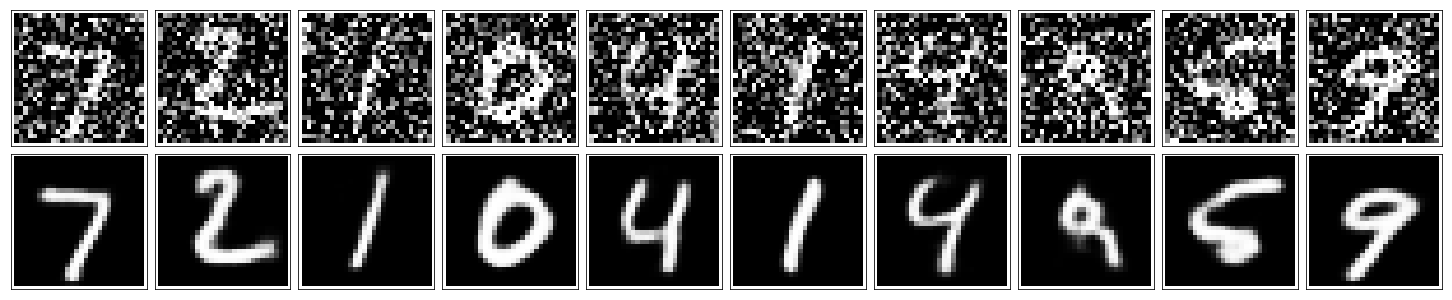

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)